## Imports

In [48]:
import numpy as np
from jax.config import config; config.update("jax_enable_x64", True)
import jax.numpy as jnp
import networkx as nx
from qibo import matrices, optimizers
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
%matplotlib inline

## MAXcut and Weighted MAXcut Hamiltonians

In [4]:
def maxcut(nqubits, norm=2, random_graph=False):
    """Builds maxcut hamiltonian"""
    if random_graph:
        aa = np.random.randint(1, nqubits*(nqubits-1)/2+1)
        graph = nx.random_graphs.dense_gnm_random_graph(nqubits, aa)
        V = nx.adjacency_matrix(graph).toarray()

    ham = jnp.zeros(shape=(2**nqubits,2**nqubits), dtype=np.float64)
    z = jnp.array([[1,0],[0,-1]], dtype=np.float64)
    iden = jnp.array([[1,0],[0,1]], dtype=np.float64)
    for i in range(nqubits):
        for j in range(nqubits):
            h = jnp.eye(1)
            for k in range(nqubits):
                if (k == i) ^ (k == j):
                    h = jnp.kron(h, z)
                else:
                    h = jnp.kron(h, iden)            
            M = jnp.eye(2**nqubits) - h
            if random_graph:
                ham += V[i,j] * M
            else:
                ham += M
    return - 1/norm * ham    


def weighted_maxcut(nqubits, norm=2, random_graph=False):
    """Builds maxcut hamiltonian"""
    weights = jnp.array([[0.5488135 , 0.71518937, 0.60276338, 0.54488318, 0.4236548 ],
                         [0.64589411, 0.43758721, 0.891773  , 0.96366276, 0.38344152],
                         [0.79172504, 0.52889492, 0.56804456, 0.92559664, 0.07103606],
                         [0.0871293 , 0.0202184 , 0.83261985, 0.77815675, 0.87001215],
                         [0.97861834, 0.79915856, 0.46147936, 0.78052918, 0.11827443]], 
                        dtype=np.float64)
    if random_graph:
        aa = np.random.randint(1, nqubits*(nqubits-1)/2+1)
        graph = nx.random_graphs.dense_gnm_random_graph(nqubits, aa)
        V = nx.adjacency_matrix(graph).toarray()

    ham = jnp.zeros(shape=(2**nqubits,2**nqubits), dtype=np.float64)
    z = jnp.array([[1,0],[0,-1]], dtype=np.float64)
    iden = jnp.array([[1,0],[0,1]], dtype=np.float64)
    for i in range(nqubits):
        for j in range(nqubits):
            h = jnp.eye(1)
            for k in range(nqubits):
                if (k == i) ^ (k == j):
                    h = jnp.kron(h, z)
                else:
                    h = jnp.kron(h, iden)            
            M = jnp.eye(2**nqubits) - h
            if random_graph:
                ham += V[i,j] * weights[i,j] * M
            else:
                ham += M * weights[i,j]
    return - 1/norm * ham    

## Optimization class

In [5]:
def Qu(beta, eps=1e-3, deltal=1):
    return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


class FragmentedQuITE:
    
    def __init__(self, nqubits, hamiltonian, query, eps=1e-3):
        """Test function for optimization."""
        self.n = nqubits
        energy = jnp.linalg.eigvalsh(hamiltonian)
        self.E = energy/((np.max(energy)-np.min(energy))/2)
        self.Emin = np.min(self.E)
        self.query = query
        self.eps = eps

    def minimize(self, schedule, r, b, initial_parameters=None, method='BFGS', options=None):
        """Optimizes scheduling function."""
        from scipy.optimize import minimize
        
        # imposes differences to be positive
        def derivative(p):
            return np.diff([schedule(step/r, p) for step in range(1, r+1)])
        
        con1 = {'type': 'ineq', 'fun': derivative}
        m = minimize(lambda p, _: self.compute_query(p, schedule, r, b),
                        initial_parameters, 
                        method, options=options, constraints=con1)
        return m.fun, m.x        
        
    def compute_query(self, params, schedule, r, b):
        """Compute query optimization."""
        beta = np.array([ b * schedule(step/r, params) for step in range(1, r+1)])
        
        # k == 0
        PsucBr = self.Psuc(beta[r-1])
        eps_prime = self.eps / (2 * 4.0**(r-1)) * np.sqrt(PsucBr)
        Sigma = self.query(beta[0]-0, eps=eps_prime, deltal=1)

        # k > 0
        DeltaBeta = np.diff(beta)
        for k in range(r-1):
            PsucBk = self.Psuc(beta[k+1])
            eps_prime = self.eps / 4.0**(r-(k+1)) * np.sqrt(PsucBr/PsucBk)
            Sigma += PsucBk * self.query(DeltaBeta[k], eps=eps_prime, deltal=1)
        
        Psbeta = self.Psuc(beta[r-1])        
        return 1/Psbeta * Sigma

    def Psuc(self, beta):
        Z = np.sum(np.exp(-beta * self.E))
        Zt =  Z * np.exp(beta * self.Emin)
        N = 2**self.n        
        return Zt / N
    
    def Qfrac_linear(self, r, b):
        """Return linear query prediction."""
        return self.compute_query(params=None, schedule=lambda t, _: t, r=r, b=b)
    
    def Q(self, beta):        
        Psbeta = self.Psuc(beta)
        bquery = self.query(beta=beta, eps=self.eps / 2 * np.sqrt(Psbeta), deltal=1)
        return 1/Psbeta * bquery
    
    def Qampl(self, beta):
        Psbeta = self.Psuc(beta)                
        return 1/np.sqrt(Psbeta) * self.query(beta=beta, eps=self.eps / 2 * np.sqrt(Psbeta), deltal=1)

## Example


Reference value: 55.14033784355961
Optimized value: 54.34097674815433
Best params: [-1.07142847]
Cross-check: 54.34097674815433

Reference value: 55.14033784355961
Optimized value: 51.17589533535576
Best params: [-5.38043234  2.44565084]
Cross-check: 51.17589533535576



<ipython-input-4-fc673c59eb0a>:28: RuntimeWarning: invalid value encountered in log
  return beta + np.log(r/eps) / np.log(np.e + np.log(r/eps)/beta)
<ipython-input-4-fc673c59eb0a>:28: RuntimeWarning: invalid value encountered in log
  return beta + np.log(r/eps) / np.log(np.e + np.log(r/eps)/beta)


Reference value: 55.14033784355961
Optimized value: 47.05174305297194
Best params: [-14.84095793  15.31807799  -5.65011056]
Cross-check: 47.05174305297194



<ipython-input-4-fc673c59eb0a>:28: RuntimeWarning: invalid value encountered in log
  return beta + np.log(r/eps) / np.log(np.e + np.log(r/eps)/beta)


Reference value: 55.14033784355961
Optimized value: 43.496917338670116
Best params: [-32.1653551   55.56680409 -45.57110585  14.28545002]
Cross-check: 43.496917338670116


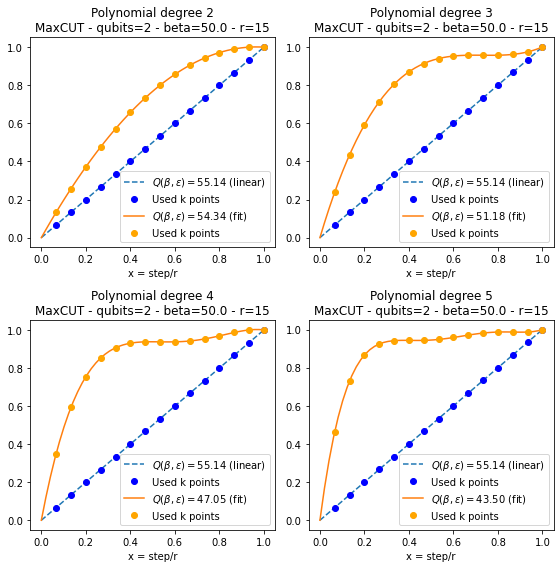

In [7]:
# setup
nqubits = 2
r = 15
beta = 50

model = FragmentedQuITE(maxcut(nqubits, norm=40.0, random_graph=True), r, beta, Qu)

def myschedule(t, params):
    f = sum(p * t ** (i + 2) for i, p in enumerate(params))
    f += (1 - np.sum(params)) * t
    return f
    

plt.figure(figsize=(8,8))
for d in range(4):
    print()
    plt.subplot(2,2,d+1)
    plt.tight_layout()
    initial_guess = np.zeros(d+1)
    initial_guess[0] = 0.1
    result, params = model.minimize(myschedule, initial_parameters=initial_guess, 
                                    method='COBYLA', options={'maxiter':50000})
    reference = model.reference_query()
    print('Reference value:', reference)
    print('Optimized value:', result)
    print('Best params:', params)
    print('Cross-check:', model.compute_query(params, myschedule))

    # plot
    x = np.linspace(0,1,50)
    xr = np.array(range(1,r+1))/r
    plt.title('Polynomial degree %d\nMaxCUT - qubits=%d - beta=%.1f - r=%d' % (len(initial_guess)+1,nqubits, beta, r))
    plt.plot(x, [i for i in x], '--', label=r'$Q(\beta,\epsilon)=%.2f$ (linear)' % reference);
    plt.plot(xr, xr, 'o', color='blue', label='Used k points')
    plt.plot(x, [myschedule(i, params) for i in x], label=r'$Q(\beta,\epsilon)=%.2f$ (fit)' % result);
    plt.plot(xr,[myschedule(ixr, params) for ixr in xr], 'o', color='orange', label='Used k points')
    plt.xlabel('x = step/r')
    plt.legend();

## Example 2

<ipython-input-2-fc673c59eb0a>:28: RuntimeWarning: invalid value encountered in log
  return beta + np.log(r/eps) / np.log(np.e + np.log(r/eps)/beta)
<ipython-input-2-fc673c59eb0a>:28: RuntimeWarning: invalid value encountered in log
  return beta + np.log(r/eps) / np.log(np.e + np.log(r/eps)/beta)


Reference value: 39.22904632154152
Optimized value: 30.66116919041711
Best params: [-9.97295968  4.00794168  5.96606137 -4.33883888]
Cross-check: 30.66116919041711
Reference value: 71.13731330403408
Optimized value: 44.486368549883565
Best params: [-32.45074555  55.42963534 -44.58139951  13.61992473]
Cross-check: 44.486368549883565


<ipython-input-2-fc673c59eb0a>:28: RuntimeWarning: invalid value encountered in log
  return beta + np.log(r/eps) / np.log(np.e + np.log(r/eps)/beta)
<ipython-input-2-fc673c59eb0a>:28: RuntimeWarning: invalid value encountered in log
  return beta + np.log(r/eps) / np.log(np.e + np.log(r/eps)/beta)


Reference value: 71.13731330403408
Optimized value: 44.486368549883565
Best params: [-32.45074555  55.42963534 -44.58139951  13.61992473]
Cross-check: 44.486368549883565
Reference value: 71.13731330403408
Optimized value: 44.486368549883565
Best params: [-32.45074555  55.42963534 -44.58139951  13.61992473]
Cross-check: 44.486368549883565
Reference value: 39.22904632154152
Optimized value: 30.66116919041711
Best params: [-9.97295968  4.00794168  5.96606137 -4.33883888]
Cross-check: 30.66116919041711


<ipython-input-2-fc673c59eb0a>:28: RuntimeWarning: invalid value encountered in log
  return beta + np.log(r/eps) / np.log(np.e + np.log(r/eps)/beta)
<ipython-input-2-fc673c59eb0a>:28: RuntimeWarning: invalid value encountered in log
  return beta + np.log(r/eps) / np.log(np.e + np.log(r/eps)/beta)


Reference value: 412.976585726458
Optimized value: 401.39380159261947
Best params: [-2.39898421  1.23831164  0.84188499 -0.62742249]
Cross-check: 401.39380159261947


<ipython-input-2-fc673c59eb0a>:28: RuntimeWarning: invalid value encountered in log
  return beta + np.log(r/eps) / np.log(np.e + np.log(r/eps)/beta)


Reference value: 744.9603470285257
Optimized value: 720.5822766821117
Best params: [-2.0391489   0.81018994  1.4189532  -1.03623585]
Cross-check: 720.5822766821117


<ipython-input-2-fc673c59eb0a>:28: RuntimeWarning: invalid value encountered in log
  return beta + np.log(r/eps) / np.log(np.e + np.log(r/eps)/beta)


Reference value: 144.5080878751085
Optimized value: 119.59622625586101
Best params: [-5.2470345   0.96533792  2.47509243 -1.27845721]
Cross-check: 119.59622625586101


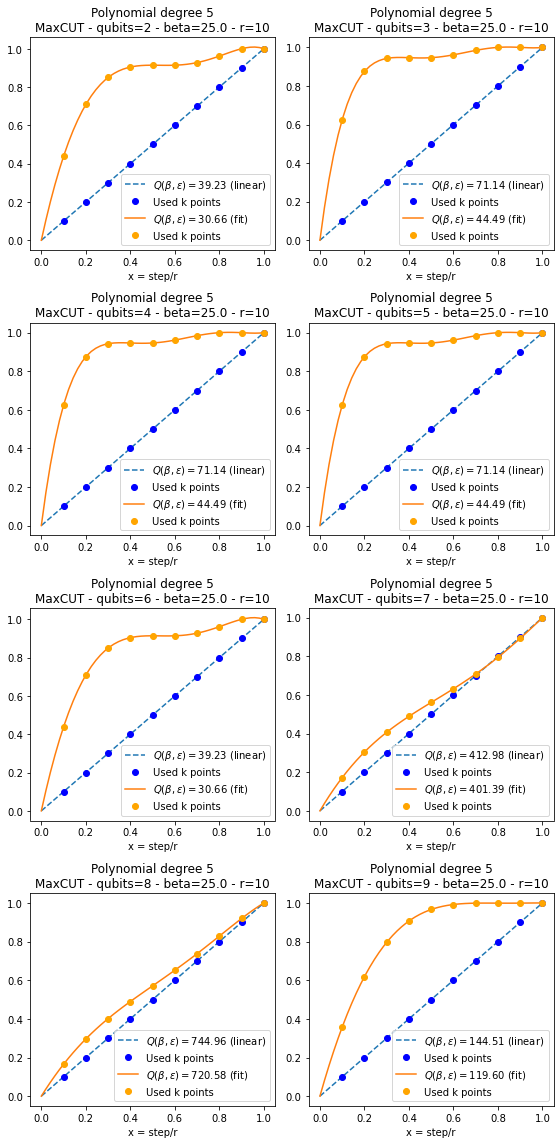

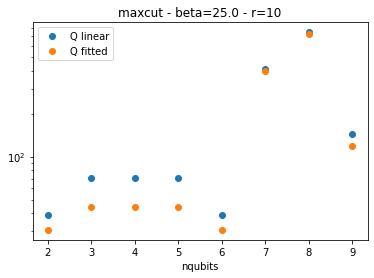

In [41]:
# setup
r = 10
beta = 25

qref = []
qopt = []

plt.figure(figsize=(8,16))
for nqubits in range(2, 10):
    plt.subplot(4,2,nqubits-1)
    plt.tight_layout()    
    
    model = FragmentedQuITE(maxcut(nqubits, norm=40.0, random_graph=True), r, beta, Qu)

    def myschedule(t, params):
        f = sum(p * t ** (i + 2) for i, p in enumerate(params))
        f += (1 - np.sum(params)) * t
        return f

    initial_guess = np.zeros(4)
    initial_guess[0] = 0.1
    result, params = model.minimize(myschedule, initial_parameters=initial_guess, 
                                    method='COBYLA', options={'maxiter':50000})
    reference = model.reference_query()
    print('Reference value:', reference)
    print('Optimized value:', result)
    print('Best params:', params)
    print('Cross-check:', model.compute_query(params, myschedule))
    qref.append(reference)
    qopt.append(result)
    
    # plot
    x = np.linspace(0,1,50)
    xr = np.array(range(1,r+1))/r
    plt.title('Polynomial degree %d\nMaxCUT - qubits=%d - beta=%.1f - r=%d' % (len(initial_guess)+1,nqubits, beta, r))
    plt.plot(x, [i for i in x], '--', label=r'$Q(\beta,\epsilon)=%.2f$ (linear)' % reference);
    plt.plot(xr, xr, 'o', color='blue', label='Used k points')
    plt.plot(x, [myschedule(i, params) for i in x], label=r'$Q(\beta,\epsilon)=%.2f$ (fit)' % result);
    plt.plot(xr,[myschedule(ixr, params) for ixr in xr], 'o', color='orange', label='Used k points')
    plt.xlabel('x = step/r')
    plt.legend();
plt.savefig('maxcut_beta%d_r%d_pol%d.png' % (beta, r, len(initial_guess)+1))

plt.figure()
plt.title('maxcut - beta=%.1f - r=%d' % (beta, r))
plt.plot(range(2,10), qref, 'o', label='Q linear')
plt.plot(range(2,10), qopt, 'o', label='Q fitted')
plt.yscale('log')
plt.legend();
plt.xlabel('nqubits')
plt.savefig('all_maxcut_beta%d_r%d_pol%d.png' % (beta, r, len(initial_guess)+1))

## Example 3

Reference value: 5.193893674612351
Optimized value: 5.193893674612351
Best params: [0.1 0.  0.  0. ]
Cross-check: 5.193893674612351
Reference value: 6.19705532772187
Optimized value: 6.19705532772187
Best params: [0.1 0.  0.  0. ]
Cross-check: 6.19705532772187
Reference value: 11.425696597488782
Optimized value: 9.091727995482584
Best params: [-0.11367251 -0.32050877 -0.37392684 -0.40063593]
Cross-check: 9.091727995482584
Reference value: 14.96950434946173
Optimized value: 13.12269509095543
Best params: [-0.11367274 -0.32050876 -0.37392676 -0.40063589]
Cross-check: 13.12269509095543
Reference value: 20.57295205246205
Optimized value: 19.16830167025402
Best params: [-0.11367244 -0.32050878 -0.37392683 -0.40063597]
Cross-check: 19.16830167025402


<ipython-input-2-fc673c59eb0a>:28: RuntimeWarning: invalid value encountered in log
  return beta + np.log(r/eps) / np.log(np.e + np.log(r/eps)/beta)


Reference value: 13.204433220700135
Optimized value: 10.929497983867495
Best params: [-3.69952912 -2.22097183  0.20198834  2.2741182 ]
Cross-check: 10.929497983867495


<ipython-input-2-fc673c59eb0a>:28: RuntimeWarning: invalid value encountered in log
  return beta + np.log(r/eps) / np.log(np.e + np.log(r/eps)/beta)


Reference value: 22.9948513596238
Optimized value: 17.626905118923506
Best params: [-2.08827723 -1.33307303  0.00842584  1.15986921]
Cross-check: 17.626905118923506
Reference value: 25.178779037674303
Optimized value: 22.355537088501567
Best params: [-3.69955168 -2.22093074  0.20196093  2.27412318]
Cross-check: 22.355537088501567


<ipython-input-2-fc673c59eb0a>:28: RuntimeWarning: invalid value encountered in log
  return beta + np.log(r/eps) / np.log(np.e + np.log(r/eps)/beta)
<ipython-input-2-fc673c59eb0a>:28: RuntimeWarning: invalid value encountered in log
  return beta + np.log(r/eps) / np.log(np.e + np.log(r/eps)/beta)
<ipython-input-2-fc673c59eb0a>:28: RuntimeWarning: divide by zero encountered in true_divide
  return beta + np.log(r/eps) / np.log(np.e + np.log(r/eps)/beta)
<ipython-input-2-fc673c59eb0a>:28: RuntimeWarning: invalid value encountered in log
  return beta + np.log(r/eps) / np.log(np.e + np.log(r/eps)/beta)
<ipython-input-2-fc673c59eb0a>:28: RuntimeWarning: divide by zero encountered in true_divide
  return beta + np.log(r/eps) / np.log(np.e + np.log(r/eps)/beta)


Reference value: 33.2259107650509
Optimized value: 27.273695316895903
Best params: [-2.21372911 -1.31531159  0.02813772  1.13997626]
Cross-check: 27.273695316895903
Reference value: 19.675351626391393
Optimized value: 17.143434263164934
Best params: [-2.11865769 -1.38059908 -0.03451741  1.19997961]
Cross-check: 17.143434263164934


<ipython-input-2-fc673c59eb0a>:28: RuntimeWarning: invalid value encountered in log
  return beta + np.log(r/eps) / np.log(np.e + np.log(r/eps)/beta)


Reference value: 60.78986728037438
Optimized value: 48.58474655481744
Best params: [-2.22772408 -1.3057083   0.03737425  1.13113684]
Cross-check: 48.58474655481744


<ipython-input-2-fc673c59eb0a>:28: RuntimeWarning: invalid value encountered in log
  return beta + np.log(r/eps) / np.log(np.e + np.log(r/eps)/beta)


Reference value: 29.26743933783735
Optimized value: 25.117306000316233
Best params: [-1.28969736 -0.85522761 -0.07765144  0.59911132]
Cross-check: 25.117306000316233


<ipython-input-2-fc673c59eb0a>:28: RuntimeWarning: invalid value encountered in log
  return beta + np.log(r/eps) / np.log(np.e + np.log(r/eps)/beta)


Reference value: 30.17213492800561
Optimized value: 27.882474002973062
Best params: [-0.74802568 -0.58733507 -0.13420792  0.29901632]
Cross-check: 27.882474002973062


<ipython-input-2-fc673c59eb0a>:28: RuntimeWarning: invalid value encountered in log
  return beta + np.log(r/eps) / np.log(np.e + np.log(r/eps)/beta)


Reference value: 75.54463532732419
Optimized value: 73.69413618644278
Best params: [-2.67476607  0.11445566  0.87875393 -0.31348702]
Cross-check: 73.69413618644278


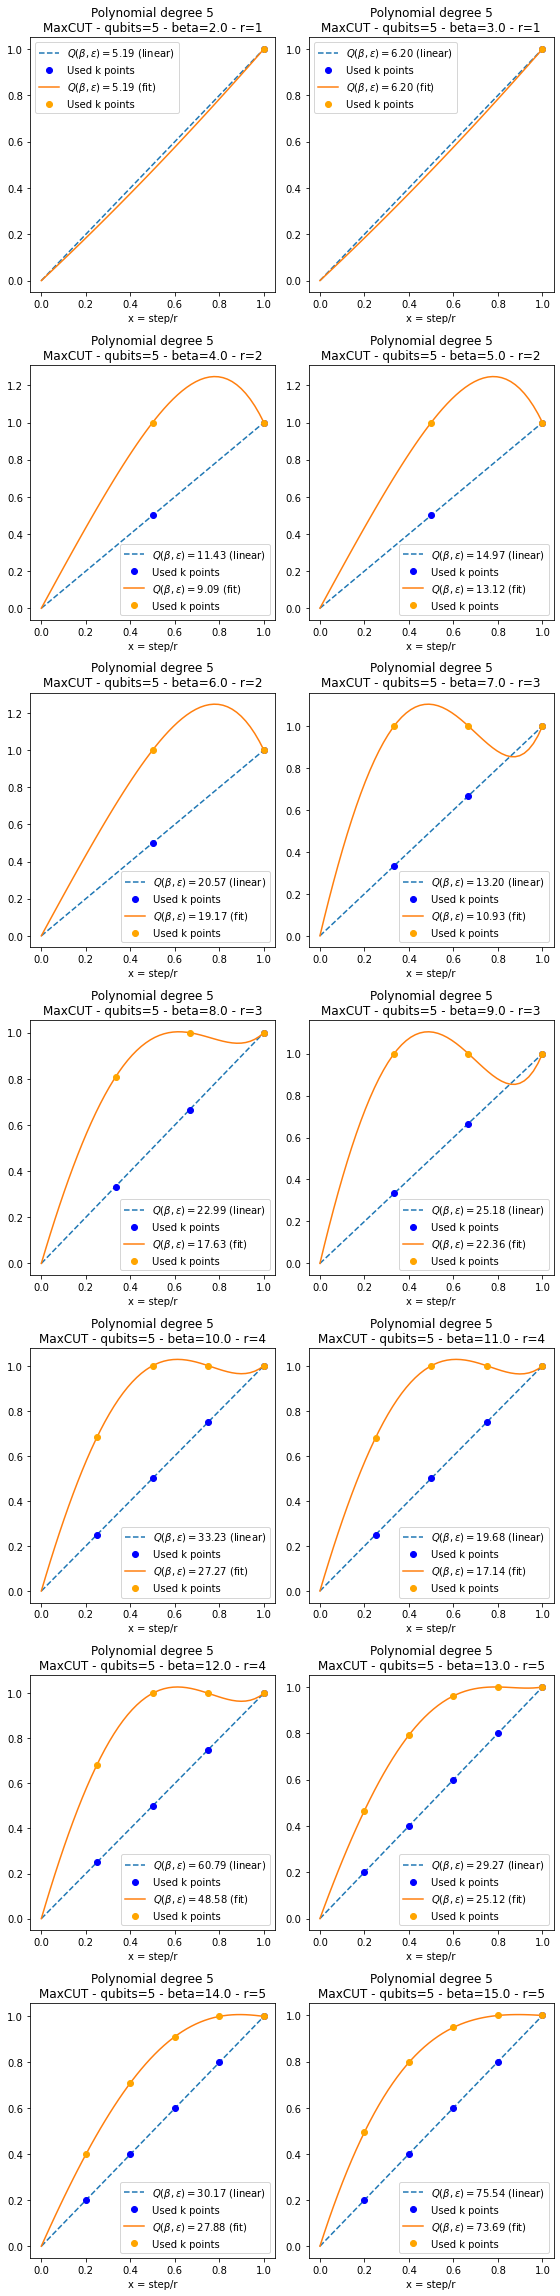

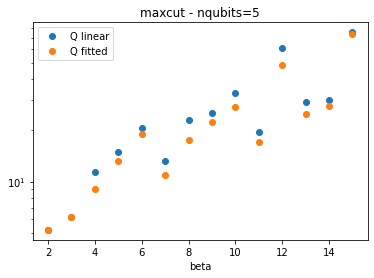

In [58]:
# setup
nqubits = 5

qref = []
qopt = []

plt.figure(figsize=(8,32))
for beta in range(2, 16):    
    plt.subplot(7,2,beta-1)
    plt.tight_layout()    
    r = np.int64(np.ceil(beta/3))
    model = FragmentedQuITE(maxcut(nqubits, norm=40.0, random_graph=True), r, beta, Qu)

    def myschedule(t, params):
        f = sum(p * t ** (i + 2) for i, p in enumerate(params))
        f += (1 - np.sum(params)) * t
        return f

    initial_guess = np.zeros(4)
    initial_guess[0] = 0.1
    result, params = model.minimize(myschedule, initial_parameters=initial_guess, 
                                    method='COBYLA', options={'maxiter':50000})
    reference = model.reference_query()
    print('Reference value:', reference)
    print('Optimized value:', result)
    print('Best params:', params)
    print('Cross-check:', model.compute_query(params, myschedule))
    qref.append(reference)
    qopt.append(result)
    
    # plot
    x = np.linspace(0,1,50)
    xr = np.array(range(1,r+1))/r
    plt.title('Polynomial degree %d\nMaxCUT - qubits=%d - beta=%.1f - r=%d' % (len(initial_guess)+1,nqubits, beta, r))
    plt.plot(x, [i for i in x], '--', label=r'$Q(\beta,\epsilon)=%.2f$ (linear)' % reference);
    plt.plot(xr, xr, 'o', color='blue', label='Used k points')
    plt.plot(x, [myschedule(i, params) for i in x], label=r'$Q(\beta,\epsilon)=%.2f$ (fit)' % result);
    plt.plot(xr,[myschedule(ixr, params) for ixr in xr], 'o', color='orange', label='Used k points')
    plt.xlabel('x = step/r')
    plt.legend();
plt.savefig('p2_maxcut_nqubits%d_pol%d.png' % (nqubits, len(initial_guess)+1))


plt.figure()
plt.title('maxcut - nqubits=%d' % nqubits)
plt.plot(range(2, 16), qref, 'o', label='Q linear')
plt.plot(range(2, 16), qopt, 'o', label='Q fitted')
plt.yscale('log')
plt.legend();
plt.xlabel('beta')
plt.savefig('p2_all_maxcut_nqubits%d_pol%d.png' % (nqubits, len(initial_guess)+1))

## Example 4 - Average vs qubits

In [4]:
ntrials = 10

# setup
r = 10
beta = 14
npol = 5

qref = []
qopt = []
qampl = []
qc = []
parameters = []

def myschedule(t, params):
    f = sum(p * t ** (i + 2) for i, p in enumerate(params))
    f += (1 - np.sum(params)) * t
    return f

for nqubits in range(2, 10):
    print('nqubits', nqubits)
    qref.append(np.zeros(ntrials))
    qopt.append(np.zeros(ntrials))
    qampl.append(np.zeros(ntrials))
    qc.append(np.zeros(ntrials))    
    parameters.append(np.zeros(shape=(ntrials,npol-1)))
    for nt in range(ntrials):
        model = FragmentedQuITE(nqubits, maxcut(nqubits, norm=40.0, random_graph=True), Qu)
        reference = model.reference_query(r, beta)
        a_ref, qampl_reference = model.reference_query_no_fragmentation(beta)
        
        initial_guess = np.zeros(npol-1)
        initial_guess[0] = 0.1
        result, params = model.minimize(myschedule, initial_parameters=initial_guess, 
                                        r=r, b=beta,
                                        method='COBYLA', options={'maxiter':50000})
        qref[nqubits-2][nt] = reference        
        qopt[nqubits-2][nt] = result
        qampl[nqubits-2][nt] = qampl_reference
        parameters[nqubits-2][nt] = params
        qc[nqubits-2][nt] = a_ref

nqubits 2


<ipython-input-3-7a2820d156f4>:2: RuntimeWarning: invalid value encountered in log
  return beta + np.log(r/eps) / np.log(np.e + np.log(r/eps)/beta)


nqubits 3
nqubits 4
nqubits 5
nqubits 6
nqubits 7
nqubits 8
nqubits 9


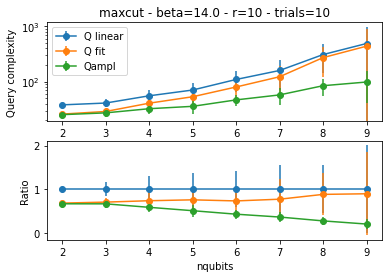

In [5]:
fig, axs = plt.subplots(2)
axs[0].set_title('maxcut - beta=%.1f - r=%d - trials=%d' % (beta, r, ntrials))
axs[0].errorbar(range(2,10), np.mean(qref, axis=1), 
             yerr=np.std(qref, axis=1), marker='o', label='Q linear')
axs[0].errorbar(range(2,10), np.nanmean(qopt, axis=1), 
             yerr=np.nanstd(qopt, axis=1), marker='o', label='Q fit')
axs[0].errorbar(range(2,10), np.nanmean(qampl, axis=1), 
             yerr=np.nanstd(qampl, axis=1), marker='o', label='Qampl')
axs[0].set_yscale('log')
axs[0].legend();
axs[0].set_ylabel('Query complexity')
axs[1].errorbar(range(2,10), np.mean(qref, axis=1)/np.mean(qref, axis=1), 
             yerr=np.std(qref, axis=1)/np.mean(qref, axis=1), marker='o')
axs[1].errorbar(range(2,10), np.nanmean(qopt, axis=1)/np.mean(qref, axis=1), 
             yerr=np.nanstd(qopt, axis=1)/np.mean(qref, axis=1), marker='o')
axs[1].errorbar(range(2,10), np.nanmean(qampl, axis=1)/np.mean(qref, axis=1), 
             yerr=np.nanstd(qampl, axis=1)/np.mean(qref, axis=1), marker='o')
axs[1].set_xlabel('nqubits')
axs[1].set_ylabel('Ratio');
plt.savefig('avg_maxcut_beta%d_r%d_pol5.png' % (beta, r), bbox_inches='tight')

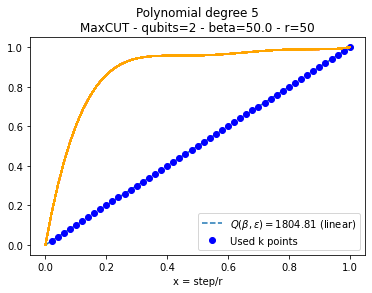

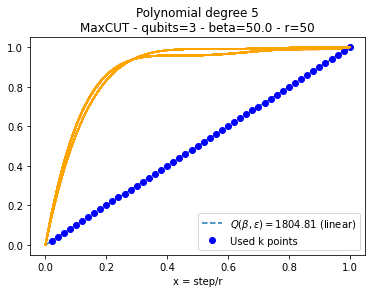

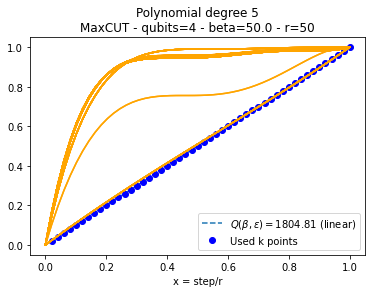

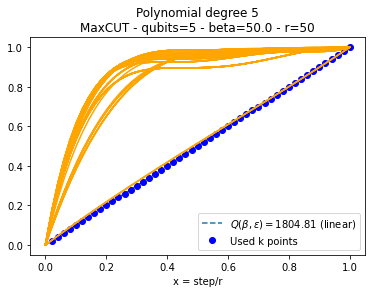

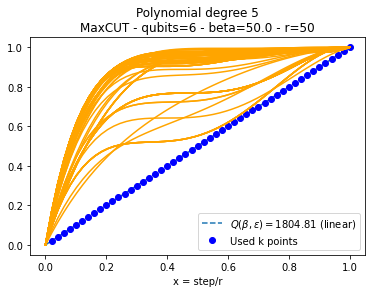

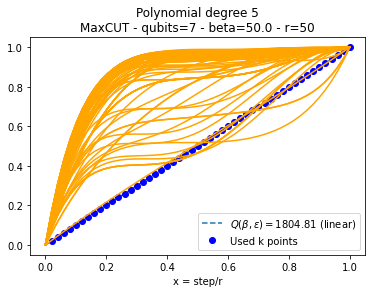

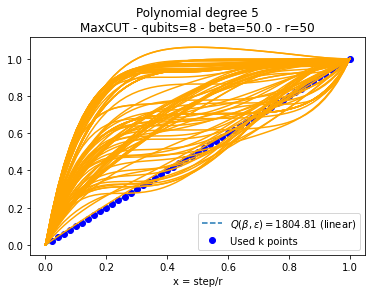

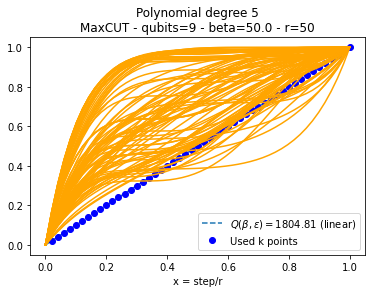

In [48]:
# plot
x = np.linspace(0,1,50)
xr = np.array(range(1,r+1))/r
for nqubits in range(2, 10):
    plt.figure()
    plt.title('Polynomial degree %d\nMaxCUT - qubits=%d - beta=%.1f - r=%d' % (len(initial_guess)+1,nqubits, beta, r))
    plt.plot(x, [i for i in x], '--', label=r'$Q(\beta,\epsilon)=%.2f$ (linear)' % reference);
    plt.plot(xr, xr, 'o', color='blue', label='Used k points')
    for j in range(parameters[nqubits-2].shape[0]):
        plt.plot(x, [myschedule(i, parameters[nqubits-2][j]) for i in x], color='orange');
        #plt.plot(xr,[myschedule(ixr, parameters[nqubits-2][j]) for ixr in xr], 'o', color='orange')
    plt.xlabel('x = step/r')
    plt.legend();

## Example 5 - Average vs beta

In [31]:
# setup
ntrials = 1
nqubits = 5
npol = 5

qref = []
qopt = []
qampl = []
qc = []
parameters = []

def myschedule(t, params):
    f = sum(p * t ** (i + 2) for i, p in enumerate(params))
    f += (1 - np.sum(params)) * t
    return f

beta_max = 50
beta_range = range(2, beta_max+1, 2)
qref = np.zeros(shape=(len(beta_range),ntrials))
qopt = np.zeros(shape=(len(beta_range),ntrials))
qampl = np.zeros(shape=(len(beta_range),ntrials))
qc = np.zeros(shape=(len(beta_range),ntrials))
parameters = np.zeros(shape=(len(beta_range), ntrials, npol-1))

for nt in range(ntrials):
    print(f'trial={nt}')
    model = FragmentedQuITE(nqubits, weighted_maxcut(nqubits, norm=40.0, 
                            random_graph=True), Qu)
    for ii, beta in enumerate(beta_range):
        r = np.int64(np.ceil(beta/2))
        print(f' beta={beta}, r={r}')
        
        reference = model.Qfrac_linear(r, beta)
        a_ref = model.Q(beta)
        ampl_ref = model.Qampl(beta)

        initial_guess = np.zeros(npol-1)
        initial_guess[0] = 0.1
        result, params = model.minimize(myschedule, initial_parameters=initial_guess, 
                                        r=r, b=beta,
                                        method='COBYLA', options={'maxiter':50000})

        qref[ii][nt] = reference
        qopt[ii][nt] = result
        qampl[ii][nt] = ampl_ref
        parameters[ii][nt] = params
        qc[ii][nt] = a_ref

trial=0
 beta=2, r=1
 beta=4, r=2
 beta=6, r=3


<ipython-input-10-d2fc4f10a7e3>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-10-d2fc4f10a7e3>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + np.log(1.0/eps)/(beta*np.e*deltal))


 beta=8, r=4
 beta=10, r=5
 beta=12, r=6
 beta=14, r=7
 beta=16, r=8
 beta=18, r=9
 beta=20, r=10
 beta=22, r=11
 beta=24, r=12
 beta=26, r=13
 beta=28, r=14
 beta=30, r=15
 beta=32, r=16
 beta=34, r=17
 beta=36, r=18
 beta=38, r=19
 beta=40, r=20
 beta=42, r=21
 beta=44, r=22
 beta=46, r=23
 beta=48, r=24
 beta=50, r=25


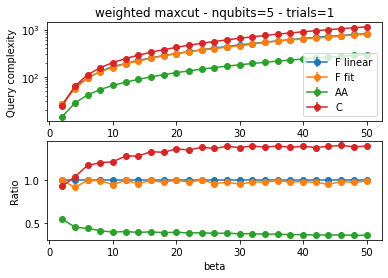

In [32]:
fig, axs = plt.subplots(2)
axs[0].set_title('weighted maxcut - nqubits=%d - trials=%d' % (nqubits, ntrials))
axs[0].errorbar(beta_range, np.mean(qref, axis=1), 
             yerr=np.std(qref, axis=1), marker='o', label='F linear')
axs[0].errorbar(beta_range, np.nanmean(qopt, axis=1), 
             yerr=np.nanstd(qopt, axis=1), marker='o', label='F fit')
axs[0].errorbar(beta_range, np.nanmean(qampl, axis=1), 
             yerr=np.nanstd(qampl, axis=1), marker='o', label='AA')
axs[0].errorbar(beta_range, np.nanmean(qc, axis=1), 
             yerr=np.nanstd(qc, axis=1), marker='o', label='C')
axs[0].set_yscale('log')
axs[0].legend();
axs[0].set_ylabel('Query complexity')
axs[1].errorbar(beta_range, np.mean(qref, axis=1)/np.mean(qref, axis=1), 
             yerr=np.std(qref, axis=1)/np.mean(qref, axis=1), marker='o')
axs[1].errorbar(beta_range, np.nanmean(qopt, axis=1)/np.mean(qref, axis=1), 
             yerr=np.nanstd(qopt, axis=1)/np.mean(qref, axis=1), marker='o')
axs[1].errorbar(beta_range, np.nanmean(qampl, axis=1)/np.mean(qref, axis=1), 
             yerr=np.nanstd(qampl, axis=1)/np.mean(qref, axis=1), marker='o')
axs[1].errorbar(beta_range, np.nanmean(qc, axis=1)/np.mean(qref, axis=1), 
             yerr=np.nanstd(qc, axis=1)/np.mean(qref, axis=1), marker='o')
axs[1].set_xlabel('beta')
axs[1].set_ylabel('Ratio');
plt.savefig('avg_maxcut_nqubits%d_pol5.png' % (nqubits), bbox_inches='tight')

In [42]:
# setup
ntrials = 100
nqubits = 5
npol = 5

qref = []
qopt = []
qampl = []
qc = []
parameters = []

def myschedule(t, params):
    f = sum(p * t ** (i + 2) for i, p in enumerate(params))
    f += (1 - np.sum(params)) * t
    return f

r_range = range(1, 15) 
beta_max = 150
beta_range = range(2, beta_max+1, 5)
qref = np.zeros(shape=(len(beta_range),ntrials))
qampl = np.zeros(shape=(len(beta_range),ntrials))
qc = np.zeros(shape=(len(beta_range),ntrials))
bestr = np.zeros(shape=(len(beta_range), ntrials))

for nt in range(ntrials):
    print(f'trial={nt}')
    model = FragmentedQuITE(nqubits, weighted_maxcut(nqubits, norm=40.0, 
                            random_graph=True), Qu)
    
    for ii, beta in enumerate(beta_range):
        a_ref = model.Q(beta)
        ampl_ref = model.Qampl(beta)
        qampl[ii][nt] = ampl_ref
        qc[ii][nt] = a_ref
        
        values = []
        for r in r_range:           
            reference = model.Qfrac_linear(r, beta)
            values.append(reference)
            print(f' beta={beta}, r={r}, reference={reference}')
        
        qref[ii][nt] = np.min(values)
        bestr[ii][nt] = r_range[np.argmin(values)]

trial=0
 beta=2, r=1, reference=22.908429903230186
 beta=2, r=2, reference=22.364842492456244
 beta=2, r=3, reference=25.40772308521029
 beta=2, r=4, reference=29.68872636424635
 beta=2, r=5, reference=34.65890758215651
 beta=2, r=6, reference=40.12755159186934
 beta=2, r=7, reference=46.01249270963635
 beta=2, r=8, reference=52.27255916156061
 beta=2, r=9, reference=58.88449763354353
 beta=2, r=10, reference=65.8337823858233
 beta=2, r=11, reference=73.11052054705023
 beta=2, r=12, reference=80.70746236834007
 beta=2, r=13, reference=88.61896391745269
 beta=2, r=14, reference=96.84041345495916
 beta=7, r=1, reference=63.87646132652306
 beta=7, r=2, reference=54.077771679038996
 beta=7, r=3, reference=53.83137852310454
 beta=7, r=4, reference=56.303462450955244
 beta=7, r=5, reference=60.12738370423639
 beta=7, r=6, reference=64.82040458761568
 beta=7, r=7, reference=70.159240948322
 beta=7, r=8, reference=76.02348832801147
 beta=7, r=9, reference=82.34135108808236
 beta=7, r=10, refer

 beta=77, r=6, reference=250.1863790687031
 beta=77, r=7, reference=254.9621377869948
 beta=77, r=8, reference=261.5662438486767
 beta=77, r=9, reference=269.38281371962745
 beta=77, r=10, reference=278.05138773202145
 beta=77, r=11, reference=287.3505419997846
 beta=77, r=12, reference=297.139238655867
 beta=77, r=13, reference=307.32509833375474
 beta=77, r=14, reference=317.846270153643
 beta=82, r=1, reference=478.1019137389193
 beta=82, r=2, reference=322.9607649584484
 beta=82, r=3, reference=279.5518109993917
 beta=82, r=4, reference=264.1604223902687
 beta=82, r=5, reference=259.98166021441045
 beta=82, r=6, reference=261.38886664952105
 beta=82, r=7, reference=265.96512830922256
 beta=82, r=8, reference=272.50575050687235
 beta=82, r=9, reference=280.3488085368556
 beta=82, r=10, reference=289.10520526718824
 beta=82, r=11, reference=298.53479210263504
 beta=82, r=12, reference=308.48385461068244
 beta=82, r=13, reference=318.8512153694857
 beta=82, r=14, reference=329.5688043

 beta=2, r=1, reference=31.915503808915116
 beta=2, r=2, reference=29.125680581405263
 beta=2, r=3, reference=32.6974055697349
 beta=2, r=4, reference=38.24520215537148
 beta=2, r=5, reference=44.812769297016445
 beta=2, r=6, reference=52.08583044073768
 beta=2, r=7, reference=59.93462634430605
 beta=2, r=8, reference=68.29633442206186
 beta=2, r=9, reference=77.13648155131312
 beta=2, r=10, reference=86.43404957403797
 beta=2, r=11, reference=96.17500608461437
 beta=2, r=12, reference=106.34922716219884
 beta=2, r=13, reference=116.94892244305355
 beta=2, r=14, reference=127.96777834905826
 beta=7, r=1, reference=230.92635316631547
 beta=7, r=2, reference=168.82934839051657
 beta=7, r=3, reference=152.8134590984825
 beta=7, r=4, reference=150.55488703489888
 beta=7, r=5, reference=154.93828670468736
 beta=7, r=6, reference=163.31028895851625
 beta=7, r=7, reference=174.419989892105
 beta=7, r=8, reference=187.59375967310578
 beta=7, r=9, reference=202.43510259156685
 beta=7, r=10, ref

 beta=77, r=14, reference=584.7747290936717
 beta=82, r=1, reference=1922.903725053736
 beta=82, r=2, reference=1110.86016502044
 beta=82, r=3, reference=854.7397176538369
 beta=82, r=4, reference=736.5950732955188
 beta=82, r=5, reference=672.923616685166
 beta=82, r=6, reference=636.0041430517583
 beta=82, r=7, reference=614.0620433098888
 beta=82, r=8, reference=601.2964162008584
 beta=82, r=9, reference=594.5495898429213
 beta=82, r=10, reference=591.973479423761
 beta=82, r=11, reference=592.4241900161826
 beta=82, r=12, reference=595.1608668039828
 beta=82, r=13, reference=599.6850950194466
 beta=82, r=14, reference=605.6504210936482
 beta=87, r=1, reference=2031.8603088082466
 beta=87, r=2, reference=1169.18669342689
 beta=87, r=3, reference=896.5092966661402
 beta=87, r=4, reference=770.3718473913898
 beta=87, r=5, reference=702.1486134221147
 beta=87, r=6, reference=662.3958191805939
 beta=87, r=7, reference=638.591766206136
 beta=87, r=8, reference=624.5577159208124
 beta=87,

 beta=2, r=1, reference=18.16428577770742
 beta=2, r=2, reference=18.80395943246524
 beta=2, r=3, reference=22.441874507269986
 beta=2, r=4, reference=26.955486418035765
 beta=2, r=5, reference=31.954569994577163
 beta=2, r=6, reference=37.32536935903334
 beta=2, r=7, reference=43.02513275928747
 beta=2, r=8, reference=49.034512004006295
 beta=2, r=9, reference=55.3432152945035
 beta=2, r=10, reference=61.94488791480492
 beta=2, r=11, reference=68.83505512809334
 beta=2, r=12, reference=76.01021864834728
 beta=2, r=13, reference=83.46743094211672
 beta=2, r=14, reference=91.2040825949511
 beta=7, r=1, reference=110.14217031854763
 beta=7, r=2, reference=85.84004742638169
 beta=7, r=3, reference=83.9226095991295
 beta=7, r=4, reference=88.3785235811776
 beta=7, r=5, reference=95.77860245244425
 beta=7, r=6, reference=104.92967629930362
 beta=7, r=7, reference=115.31059450444714
 beta=7, r=8, reference=126.65949694609813
 beta=7, r=9, reference=138.83093368653948
 beta=7, r=10, reference

 beta=67, r=10, reference=544.9072624725741
 beta=67, r=11, reference=551.1424255469101
 beta=67, r=12, reference=559.4379932506674
 beta=67, r=13, reference=569.404665684954
 beta=67, r=14, reference=580.7701278338574
 beta=72, r=1, reference=1680.1559971123013
 beta=72, r=2, reference=980.3528636323175
 beta=72, r=3, reference=762.6716636610346
 beta=72, r=4, reference=664.8057232379766
 beta=72, r=5, reference=614.1921404042168
 beta=72, r=6, reference=586.7804249282242
 beta=72, r=7, reference=572.3969705380051
 beta=72, r=8, reference=566.0554183995885
 beta=72, r=9, reference=565.0556969028048
 beta=72, r=10, reference=567.8246173190988
 beta=72, r=11, reference=573.3913542075748
 beta=72, r=12, reference=581.127787275492
 beta=72, r=13, reference=590.6108546225765
 beta=72, r=14, reference=601.5455099715087
 beta=77, r=1, reference=1794.2163937541727
 beta=77, r=2, reference=1041.6583215862088
 beta=77, r=3, reference=806.6080140797337
 beta=77, r=4, reference=700.3112670124522


 beta=137, r=7, reference=879.7813619958583
 beta=137, r=8, reference=853.9233316196601
 beta=137, r=9, reference=838.6242243294577
 beta=137, r=10, reference=830.6130453666017
 beta=137, r=11, reference=827.8385186488646
 beta=137, r=12, reference=828.9580951306849
 beta=137, r=13, reference=833.0622770564302
 beta=137, r=14, reference=839.5170460456094
 beta=142, r=1, reference=3228.579441762871
 beta=142, r=2, reference=1807.8921659228376
 beta=142, r=3, reference=1351.735350770985
 beta=142, r=4, reference=1136.5919834123363
 beta=142, r=5, reference=1017.6235904137225
 beta=142, r=6, reference=946.4540775867856
 beta=142, r=7, reference=902.333460422743
 beta=142, r=8, reference=874.9073662745672
 beta=142, r=9, reference=858.4556915070697
 beta=142, r=10, reference=849.5791819022187
 beta=142, r=11, reference=846.1438675309784
 beta=142, r=12, reference=846.7515523713238
 beta=142, r=13, reference=850.4540412764114
 beta=142, r=14, reference=856.5897094260043
 beta=147, r=1, refe

 beta=67, r=11, reference=264.4173874612521
 beta=67, r=12, reference=273.84898286476533
 beta=67, r=13, reference=283.63971200601094
 beta=67, r=14, reference=293.73978305557245
 beta=72, r=1, reference=423.6204935399097
 beta=72, r=2, reference=288.6458464635681
 beta=72, r=3, reference=251.709160386033
 beta=72, r=4, reference=239.30036432197323
 beta=72, r=5, reference=236.66921589138602
 beta=72, r=6, reference=238.88603901552924
 beta=72, r=7, reference=243.84156991058768
 beta=72, r=8, reference=250.4908490587744
 beta=72, r=9, reference=258.2642496101723
 beta=72, r=10, reference=266.82999625029476
 beta=72, r=11, reference=275.98534965263093
 beta=72, r=12, reference=285.6018768884061
 beta=72, r=13, reference=295.5959241421042
 beta=72, r=14, reference=305.91179841320326
 beta=77, r=1, reference=450.8648060815584
 beta=77, r=2, reference=305.81324744660736
 beta=77, r=3, reference=265.64889921219316
 beta=77, r=4, reference=251.75861540667228
 beta=77, r=5, reference=248.3640

 beta=2, r=1, reference=20.72993892445906
 beta=2, r=2, reference=20.72968848702115
 beta=2, r=3, reference=24.346351478418313
 beta=2, r=4, reference=29.04046788289988
 beta=2, r=5, reference=34.31894381069593
 beta=2, r=6, reference=40.031220986690016
 beta=2, r=7, reference=46.11839892580836
 beta=2, r=8, reference=52.55298229148611
 beta=2, r=9, reference=59.32011228367209
 beta=2, r=10, reference=66.41064827529343
 beta=2, r=11, reference=73.81829206428581
 beta=2, r=12, reference=81.53827808781021
 beta=2, r=13, reference=89.56673154993382
 beta=2, r=14, reference=97.90033392167504
 beta=7, r=1, reference=133.25509502304857
 beta=7, r=2, reference=101.71443821429158
 beta=7, r=3, reference=97.33635605724571
 beta=7, r=4, reference=100.78263680077325
 beta=7, r=5, reference=107.87320400127929
 beta=7, r=6, reference=117.12903113552952
 beta=7, r=7, reference=127.89221035638369
 beta=7, r=8, reference=139.82618384062175
 beta=7, r=9, reference=152.7409269014038
 beta=7, r=10, refer

 beta=82, r=5, reference=674.5179725996893
 beta=82, r=6, reference=638.8493238371157
 beta=82, r=7, reference=618.3599269228803
 beta=82, r=8, reference=607.215493196995
 beta=82, r=9, reference=602.2369344333481
 beta=82, r=10, reference=601.5621296231758
 beta=82, r=11, reference=604.037674040873
 beta=82, r=12, reference=608.9160454331469
 beta=82, r=13, reference=615.6939880354435
 beta=82, r=14, reference=624.0213982335928
 beta=87, r=1, reference=2031.3076092163744
 beta=87, r=2, reference=1168.8860759892793
 beta=87, r=3, reference=896.4813570050826
 beta=87, r=4, reference=770.9077868895603
 beta=87, r=5, reference=703.5521630825239
 beta=87, r=6, reference=664.9175093681386
 beta=87, r=7, reference=642.433251048079
 beta=87, r=8, reference=629.886621813914
 beta=87, r=9, reference=623.8862165455675
 beta=87, r=10, reference=622.4424693765876
 beta=87, r=11, reference=624.3216890945947
 beta=87, r=12, reference=628.723909834368
 beta=87, r=13, reference=635.1106302582066
 beta

 beta=2, r=1, reference=22.660234479364238
 beta=2, r=2, reference=22.178548422932852
 beta=2, r=3, reference=25.222176493480514
 beta=2, r=4, reference=29.48186491413139
 beta=2, r=5, reference=34.42033034487888
 beta=2, r=6, reference=39.850931619666575
 beta=2, r=7, reference=45.69320746387754
 beta=2, r=8, reference=51.90680709396129
 beta=2, r=9, reference=58.46891942837965
 beta=2, r=10, reference=65.36527997853607
 beta=2, r=11, reference=72.58616284011848
 beta=2, r=12, reference=80.12443249152345
 beta=2, r=13, reference=87.97452789276063
 beta=2, r=14, reference=96.13190057700697
 beta=7, r=1, reference=63.79212882860079
 beta=7, r=2, reference=54.01989791269476
 beta=7, r=3, reference=53.81970304075566
 beta=7, r=4, reference=56.346086723027014
 beta=7, r=5, reference=60.22204086645028
 beta=7, r=6, reference=64.96295519975561
 beta=7, r=7, reference=70.34620521355177
 beta=7, r=8, reference=76.25241903340891
 beta=7, r=9, reference=82.61068441188148
 beta=7, r=10, reference

 beta=77, r=12, reference=297.13963368671085
 beta=77, r=13, reference=307.3259311079224
 beta=77, r=14, reference=317.8478393250186
 beta=82, r=1, reference=478.1019137389193
 beta=82, r=2, reference=322.9607649584484
 beta=82, r=3, reference=279.5518109993917
 beta=82, r=4, reference=264.16042239026876
 beta=82, r=5, reference=259.9816602144676
 beta=82, r=6, reference=261.38886665408444
 beta=82, r=7, reference=265.96512841171295
 beta=82, r=8, reference=272.5057515489668
 beta=82, r=9, reference=280.3488147871926
 beta=82, r=10, reference=289.105231188146
 beta=82, r=11, reference=298.53487434157836
 beta=82, r=12, reference=308.4840681596394
 beta=82, r=13, reference=318.8516909519098
 beta=82, r=14, reference=329.5697436508698
 beta=87, r=1, reference=505.3330127325234
 beta=87, r=2, reference=340.09155308377353
 beta=87, r=3, reference=293.42344856462233
 beta=87, r=4, reference=276.5138505179908
 beta=87, r=5, reference=271.53253040284596
 beta=87, r=6, reference=272.5060366763

 beta=2, r=1, reference=21.81221390697095
 beta=2, r=2, reference=21.542030994183037
 beta=2, r=3, reference=25.2298495256015
 beta=2, r=4, reference=30.085601461707295
 beta=2, r=5, reference=35.56562694504354
 beta=2, r=6, reference=41.504341566087774
 beta=2, r=7, reference=47.83718930423655
 beta=2, r=8, reference=54.53415690187951
 beta=2, r=9, reference=61.57910427483904
 beta=2, r=10, reference=68.9621591474326
 beta=2, r=11, reference=76.67656014359493
 beta=2, r=12, reference=84.71722037874665
 beta=2, r=13, reference=93.08002402279017
 beta=2, r=14, reference=101.76145990410086
 beta=7, r=1, reference=162.34786417930007
 beta=7, r=2, reference=121.70071731562756
 beta=7, r=3, reference=114.78887514365596
 beta=7, r=4, reference=117.72533200381262
 beta=7, r=5, reference=125.27089375424553
 beta=7, r=6, reference=135.54572635101417
 beta=7, r=7, reference=147.70399705375036
 beta=7, r=8, reference=161.30958991373933
 beta=7, r=9, reference=176.11511014155673
 beta=7, r=10, ref

 beta=82, r=8, reference=601.7551616430527
 beta=82, r=9, reference=595.3239425364719
 beta=82, r=10, reference=593.1656228227284
 beta=82, r=11, reference=594.139371343806
 beta=82, r=12, reference=597.5048285646623
 beta=82, r=13, reference=602.7623889264997
 beta=82, r=14, reference=609.5633695262069
 beta=87, r=1, reference=2031.8602949279987
 beta=87, r=2, reference=1169.1866858773167
 beta=87, r=3, reference=896.5094697700921
 beta=87, r=4, reference=770.3753558896505
 beta=87, r=5, reference=702.1699079843896
 beta=87, r=6, reference=662.468130379706
 beta=87, r=7, reference=638.768367960404
 beta=87, r=8, reference=624.9087174193874
 beta=87, r=9, reference=617.5324493499048
 beta=87, r=10, reference=614.6728197207657
 beta=87, r=11, reference=615.1107259635934
 beta=87, r=12, reference=618.055169487553
 beta=87, r=13, reference=622.9728233714272
 beta=87, r=14, reference=629.4919924035437
 beta=92, r=1, reference=2140.7933273339304
 beta=92, r=2, reference=1227.4570628433012
 

 beta=2, r=5, reference=45.30565261757142
 beta=2, r=6, reference=52.535144861411176
 beta=2, r=7, reference=60.36202481225623
 beta=2, r=8, reference=68.71743715950252
 beta=2, r=9, reference=77.56319694240625
 beta=2, r=10, reference=86.87589514759068
 beta=2, r=11, reference=96.63989453413218
 beta=2, r=12, reference=106.84395414635813
 beta=2, r=13, reference=117.47948098783225
 beta=2, r=14, reference=128.53956840028852
 beta=7, r=1, reference=215.7848157131007
 beta=7, r=2, reference=158.42208130212626
 beta=7, r=3, reference=144.01145661038686
 beta=7, r=4, reference=142.12481841040218
 beta=7, r=5, reference=146.20322009433698
 beta=7, r=6, reference=153.8604802943378
 beta=7, r=7, reference=163.9862753303626
 beta=7, r=8, reference=175.9845261737671
 beta=7, r=9, reference=189.5034619573156
 beta=7, r=10, reference=204.32069217781083
 beta=7, r=11, reference=220.28787668798645
 beta=7, r=12, reference=237.3016376222511
 beta=7, r=13, reference=255.28721501229595
 beta=7, r=14,

 beta=67, r=13, reference=536.5102160963016
 beta=67, r=14, reference=543.2570204688471
 beta=72, r=1, reference=1704.9011789606807
 beta=72, r=2, reference=993.9966348145758
 beta=72, r=3, reference=770.8525614034645
 beta=72, r=4, reference=668.5558641262388
 beta=72, r=5, reference=613.8673704104838
 beta=72, r=6, reference=582.5267499375179
 beta=72, r=7, reference=564.2637902472088
 beta=72, r=8, reference=554.0371162704984
 beta=72, r=9, reference=549.1107938432552
 beta=72, r=10, reference=547.8864373825697
 beta=72, r=11, reference=549.3749324775207
 beta=72, r=12, reference=552.9347427145325
 beta=72, r=13, reference=558.1329440603399
 beta=72, r=14, reference=564.667241213155
 beta=77, r=1, reference=1813.9191963072199
 beta=77, r=2, reference=1052.4675955166958
 beta=77, r=3, reference=812.8605467190952
 beta=77, r=4, reference=702.6651687285967
 beta=77, r=5, reference=643.5095419007798
 beta=77, r=6, reference=609.4042858843586
 beta=77, r=7, reference=589.3296628378598
 b

 beta=147, r=14, reference=853.7022759266806
trial=8
 beta=2, r=1, reference=25.741877903370288
 beta=2, r=2, reference=24.491631157102205
 beta=2, r=3, reference=28.097692609916862
 beta=2, r=4, reference=33.18902368185677
 beta=2, r=5, reference=39.06141920855662
 beta=2, r=6, reference=45.49004625119934
 beta=2, r=7, reference=52.38406730685124
 beta=2, r=8, reference=59.70016005969546
 beta=2, r=9, reference=67.41472163900406
 beta=2, r=10, reference=75.51333612605237
 beta=2, r=11, reference=83.98627879579826
 beta=2, r=12, reference=92.82641325805669
 beta=2, r=13, reference=102.0281327171389
 beta=2, r=14, reference=111.58679303940349
 beta=7, r=1, reference=171.2801624464959
 beta=7, r=2, reference=127.83799314020658
 beta=7, r=3, reference=118.85426585462847
 beta=7, r=4, reference=119.94317060874815
 beta=7, r=5, reference=125.83351631358263
 beta=7, r=6, reference=134.6048905363231
 beta=7, r=7, reference=145.3706943469131
 beta=7, r=8, reference=157.66165329495198
 beta=7, 

 beta=72, r=5, reference=614.2706317122207
 beta=72, r=6, reference=583.329314907204
 beta=72, r=7, reference=565.5830906798537
 beta=72, r=8, reference=555.9699017503668
 beta=72, r=9, reference=551.7370913792631
 beta=72, r=10, reference=551.2739449995884
 beta=72, r=11, reference=553.5825315309878
 beta=72, r=12, reference=558.0150701736487
 beta=72, r=13, reference=564.1342416089378
 beta=72, r=14, reference=571.6346891084868
 beta=77, r=1, reference=1813.9041582422326
 beta=77, r=2, reference=1052.4593452654703
 beta=77, r=3, reference=812.8721190110232
 beta=77, r=4, reference=702.768092869079
 beta=77, r=5, reference=643.8209605172841
 beta=77, r=6, reference=610.0496642355258
 beta=77, r=7, reference=590.4219450677759
 beta=77, r=8, reference=579.5017459504483
 beta=77, r=9, reference=574.3284059395502
 beta=77, r=10, reference=573.1674436072713
 beta=77, r=11, reference=574.9436282466704
 beta=77, r=12, reference=578.9590749798306
 beta=77, r=13, reference=584.7429878093446
 b

 beta=2, r=1, reference=18.16428577770742
 beta=2, r=2, reference=18.80395943246524
 beta=2, r=3, reference=22.441874507269986
 beta=2, r=4, reference=26.955486418035765
 beta=2, r=5, reference=31.954569994577163
 beta=2, r=6, reference=37.32536935903334
 beta=2, r=7, reference=43.02513275928747
 beta=2, r=8, reference=49.034512004006295
 beta=2, r=9, reference=55.3432152945035
 beta=2, r=10, reference=61.94488791480492
 beta=2, r=11, reference=68.83505512809334
 beta=2, r=12, reference=76.01021864834728
 beta=2, r=13, reference=83.46743094211672
 beta=2, r=14, reference=91.2040825949511
 beta=7, r=1, reference=110.14217031854763
 beta=7, r=2, reference=85.84004742638169
 beta=7, r=3, reference=83.9226095991295
 beta=7, r=4, reference=88.3785235811776
 beta=7, r=5, reference=95.77860245244425
 beta=7, r=6, reference=104.92967629930362
 beta=7, r=7, reference=115.31059450444714
 beta=7, r=8, reference=126.65949694609813
 beta=7, r=9, reference=138.83093368653948
 beta=7, r=10, reference

 beta=77, r=10, reference=590.0645598834207
 beta=77, r=11, reference=594.9758595294126
 beta=77, r=12, reference=602.1700547719587
 beta=77, r=13, reference=611.1894144029013
 beta=77, r=14, reference=621.7154465742052
 beta=82, r=1, reference=1907.2864142728397
 beta=82, r=2, reference=1102.33092289346
 beta=82, r=3, reference=850.00028378495
 beta=82, r=4, reference=735.2870697383606
 beta=82, r=5, reference=674.9976400615249
 beta=82, r=6, reference=641.478373561257
 beta=82, r=7, reference=622.9870718631394
 beta=82, r=8, reference=613.7439193284227
 beta=82, r=9, reference=610.606394838543
 beta=82, r=10, reference=611.7378844160759
 beta=82, r=11, reference=616.003376251132
 beta=82, r=12, reference=622.6688825958979
 beta=82, r=13, reference=631.2412033565358
 beta=82, r=14, reference=641.3777345201244
 beta=87, r=1, reference=2019.5294067787013
 beta=87, r=2, reference=1162.4798753167818
 beta=87, r=3, reference=892.9474359951082
 beta=87, r=4, reference=769.8312794252095
 bet

 beta=147, r=7, reference=924.8221438108093
 beta=147, r=8, reference=895.819401710498
 beta=147, r=9, reference=878.2073957374155
 beta=147, r=10, reference=868.4589542316587
 beta=147, r=11, reference=864.3575842886521
 beta=147, r=12, reference=864.4495033569513
 beta=147, r=13, reference=867.747807447526
 beta=147, r=14, reference=873.5632078948438
trial=10
 beta=2, r=1, reference=16.27712084265581
 beta=2, r=2, reference=17.387506578776225
 beta=2, r=3, reference=20.751791065802884
 beta=2, r=4, reference=24.832187479679508
 beta=2, r=5, reference=29.334451703657933
 beta=2, r=6, reference=34.168342503201316
 beta=2, r=7, reference=39.29829239523673
 beta=2, r=8, reference=44.70748788525464
 beta=2, r=9, reference=50.38664528995205
 beta=2, r=10, reference=56.329872593039184
 beta=2, r=11, reference=62.53295523649014
 beta=2, r=12, reference=68.99258065075138
 beta=2, r=13, reference=75.7059618469654
 beta=2, r=14, reference=82.67064349761779
 beta=7, r=1, reference=63.91555944017

 beta=72, r=4, reference=383.1405380947167
 beta=72, r=5, reference=365.14047327739416
 beta=72, r=6, reference=358.5936318246344
 beta=72, r=7, reference=358.5472372532726
 beta=72, r=8, reference=362.5369272591205
 beta=72, r=9, reference=369.21206032650855
 beta=72, r=10, reference=377.77976406382857
 beta=72, r=11, reference=387.7499978903707
 beta=72, r=12, reference=398.80740081262525
 beta=72, r=13, reference=410.74221575269223
 beta=72, r=14, reference=423.4109730083641
 beta=77, r=1, reference=903.6468173301656
 beta=77, r=2, reference=553.5074392951102
 beta=77, r=3, reference=447.4328573679833
 beta=77, r=4, reference=402.59579013322974
 beta=77, r=5, reference=382.33483788461723
 beta=77, r=6, reference=374.3451234040817
 beta=77, r=7, reference=373.3305671536774
 beta=77, r=8, reference=376.6495090461022
 beta=77, r=9, reference=382.8494244363801
 beta=77, r=10, reference=391.07448164539846
 beta=77, r=11, reference=400.793697982965
 beta=77, r=12, reference=411.6640997022

 beta=137, r=12, reference=561.5172295372254
 beta=137, r=13, reference=571.6926069384946
 beta=137, r=14, reference=583.1105712296287
 beta=142, r=1, reference=1611.9957383646429
 beta=142, r=2, reference=953.8485516613978
 beta=142, r=3, reference=746.3242971512059
 beta=142, r=4, reference=651.5909982425959
 beta=142, r=5, reference=602.0741359756628
 beta=142, r=6, reference=575.2371187942954
 beta=142, r=7, reference=561.4001598024892
 beta=142, r=8, reference=555.7062785139224
 beta=142, r=9, reference=555.4481636642904
 beta=142, r=10, reference=558.9989075189247
 beta=142, r=11, reference=565.3246250478014
 beta=142, r=12, reference=573.739477676717
 beta=142, r=13, reference=583.7728493194493
 beta=142, r=14, reference=595.0928702458297
 beta=147, r=1, reference=1666.399099547664
 beta=147, r=2, reference=984.531290144396
 beta=147, r=3, reference=769.1705193952581
 beta=147, r=4, reference=670.582776637555
 beta=147, r=5, reference=618.8059965122978
 beta=147, r=6, reference=

 beta=62, r=9, reference=235.4899353126493
 beta=62, r=10, reference=243.8060347875969
 beta=62, r=11, reference=252.63874797827944
 beta=62, r=12, reference=261.88507096786765
 beta=62, r=13, reference=271.4788040788302
 beta=62, r=14, reference=281.37637981056855
 beta=67, r=1, reference=396.3674397620013
 beta=67, r=2, reference=271.4545613990708
 beta=67, r=3, reference=237.72564195514744
 beta=67, r=4, reference=226.77569764233408
 beta=67, r=5, reference=224.88444415545217
 beta=67, r=6, reference=227.47271618925754
 beta=67, r=7, reference=232.58647094871833
 beta=67, r=8, reference=239.26157486211778
 beta=67, r=9, reference=246.97529040693635
 beta=67, r=10, reference=255.42516139500188
 beta=67, r=11, reference=264.427766477648
 beta=67, r=12, reference=273.8678611696321
 beta=67, r=13, reference=283.6709996104181
 beta=67, r=14, reference=293.7879957458121
 beta=72, r=1, reference=423.6204935399097
 beta=72, r=2, reference=288.6458464635681
 beta=72, r=3, reference=251.70916

 beta=127, r=13, reference=415.92592520444424
 beta=127, r=14, reference=428.028315251542
 beta=132, r=1, reference=750.252389076676
 beta=132, r=2, reference=493.8124716126585
 beta=132, r=3, reference=417.3963821183506
 beta=132, r=4, reference=386.31534601438267
 beta=132, r=5, reference=373.5444124622843
 beta=132, r=6, reference=370.02020874921465
 beta=132, r=7, reference=371.8253062167922
 beta=132, r=8, reference=376.98244661943284
 beta=132, r=9, reference=384.38397999154864
 beta=132, r=10, reference=393.3619191843107
 beta=132, r=11, reference=403.4911597952586
 beta=132, r=12, reference=414.4901037636642
 beta=132, r=13, reference=426.1664663580636
 beta=132, r=14, reference=438.3858569085338
 beta=137, r=1, reference=777.4548072312003
 beta=137, r=2, reference=510.86116765099393
 beta=137, r=3, reference=431.1099026210335
 beta=137, r=4, reference=398.41655718551965
 beta=137, r=5, reference=384.73653430518726
 beta=137, r=6, reference=380.665276578746
 beta=137, r=7, refe

 beta=52, r=10, reference=365.91564991876396
 beta=52, r=11, reference=377.41577006080547
 beta=52, r=12, reference=389.89562999911635
 beta=52, r=13, reference=403.20489757224414
 beta=52, r=14, reference=417.24049103152
 beta=57, r=1, reference=823.8781201482856
 beta=57, r=2, reference=507.0539698226572
 beta=57, r=3, reference=416.53038395626135
 beta=57, r=4, reference=381.2421419749239
 beta=57, r=5, reference=367.4229704510303
 beta=57, r=6, reference=364.03132583986115
 beta=57, r=7, reference=366.46223501299437
 beta=57, r=8, reference=372.4917293644637
 beta=57, r=9, reference=380.9335868231093
 beta=57, r=10, reference=391.1073690581079
 beta=57, r=11, reference=402.60007897962515
 beta=57, r=12, reference=415.14924809250687
 beta=57, r=13, reference=428.5814643364128
 beta=57, r=14, reference=442.77821872829117
 beta=62, r=1, reference=913.3153403608613
 beta=62, r=2, reference=557.038453534762
 beta=62, r=3, reference=453.9986474491227
 beta=62, r=4, reference=412.92107331

 beta=127, r=14, reference=759.2294183834712
 beta=132, r=1, reference=2306.0591788293564
 beta=132, r=2, reference=1318.025528155229
 beta=132, r=3, reference=1011.5946426411522
 beta=132, r=4, reference=873.0730410075723
 beta=132, r=5, reference=801.0924133873345
 beta=132, r=6, reference=762.0790570585981
 beta=132, r=7, reference=741.7004487001975
 beta=132, r=8, reference=732.8232635999317
 beta=132, r=9, reference=731.5122485363524
 beta=132, r=10, reference=735.4307679652118
 beta=132, r=11, reference=743.1132065769152
 beta=132, r=12, reference=753.6006056596788
 beta=132, r=13, reference=766.2441298817697
 beta=132, r=14, reference=780.5926301898168
 beta=137, r=1, reference=2414.789208737706
 beta=137, r=2, reference=1376.6765330197527
 beta=137, r=3, reference=1054.028642901326
 beta=137, r=4, reference=907.6412071571095
 beta=137, r=5, reference=831.1166969065999
 beta=137, r=6, reference=789.224453606837
 beta=137, r=7, reference=766.9227926739112
 beta=137, r=8, referenc

 beta=52, r=10, reference=470.71777625011856
 beta=52, r=11, reference=479.07595246073623
 beta=52, r=12, reference=489.1876759625792
 beta=52, r=13, reference=500.75873129646976
 beta=52, r=14, reference=513.5805739279417
 beta=57, r=1, reference=1330.260924973266
 beta=57, r=2, reference=791.3552107603083
 beta=57, r=3, reference=626.3635062441873
 beta=57, r=4, reference=553.8529526691225
 beta=57, r=5, reference=517.662142945344
 beta=57, r=6, reference=499.2975289219774
 beta=57, r=7, reference=490.9956005166181
 beta=57, r=8, reference=488.9785566150122
 beta=57, r=9, reference=491.2105304464107
 beta=57, r=10, reference=496.50654534580565
 beta=57, r=11, reference=504.1330899502605
 beta=57, r=12, reference=513.6123976723017
 beta=57, r=13, reference=524.6196349040423
 beta=57, r=14, reference=536.9257236704848
 beta=62, r=1, reference=1448.3519047057632
 beta=62, r=2, reference=855.3380639582091
 beta=62, r=3, reference=672.687761295639
 beta=62, r=4, reference=591.720613968035

 beta=122, r=6, reference=847.0527415567386
 beta=122, r=7, reference=811.6510424781978
 beta=122, r=8, reference=790.4424594741178
 beta=122, r=9, reference=778.5528717986327
 beta=122, r=10, reference=773.0981891563264
 beta=122, r=11, reference=772.276183688843
 beta=122, r=12, reference=774.9114732158206
 beta=122, r=13, reference=780.2104028670744
 beta=122, r=14, reference=787.6212312456751
 beta=127, r=1, reference=2901.1975547035568
 beta=127, r=2, reference=1633.399658052988
 beta=127, r=3, reference=1227.908335800377
 beta=127, r=4, reference=1037.8409556612098
 beta=127, r=5, reference=933.6348543608161
 beta=127, r=6, reference=872.0181485935185
 beta=127, r=7, reference=834.4515001348447
 beta=127, r=8, reference=811.7025294585698
 beta=127, r=9, reference=798.6845858630401
 beta=127, r=10, reference=792.3842489795422
 beta=127, r=11, reference=790.9161216117967
 beta=127, r=12, reference=793.0490787032741
 beta=127, r=13, reference=797.9509146135388
 beta=127, r=14, refer

 beta=47, r=6, reference=267.1095924716221
 beta=47, r=7, reference=267.50396618041236
 beta=47, r=8, reference=270.3448331597657
 beta=47, r=9, reference=274.83820300569084
 beta=47, r=10, reference=280.5272656009
 beta=47, r=11, reference=287.1336902964814
 beta=47, r=12, reference=294.4796439701457
 beta=47, r=13, reference=302.4467683085272
 beta=47, r=14, reference=310.9533999065166
 beta=52, r=1, reference=631.614666151329
 beta=52, r=2, reference=398.6689315756253
 beta=52, r=3, reference=329.9045301126698
 beta=52, r=4, reference=301.6838532353184
 beta=52, r=5, reference=289.3700131745503
 beta=52, r=6, reference=284.8360884844394
 beta=52, r=7, reference=284.66471131982786
 beta=52, r=8, reference=287.193372298021
 beta=52, r=9, reference=291.52964771583015
 beta=52, r=10, reference=297.158742261486
 beta=52, r=11, reference=303.766601832196
 beta=52, r=12, reference=311.15267725726943
 beta=52, r=13, reference=319.1838373544248
 beta=52, r=14, reference=327.76865827116694
 b

 beta=117, r=13, reference=509.3345202028343
 beta=117, r=14, reference=518.8029616046448
 beta=122, r=1, reference=1394.3583811283333
 beta=122, r=2, reference=831.0423078528964
 beta=122, r=3, reference=654.7764411370204
 beta=122, r=4, reference=575.2474101649672
 beta=122, r=5, reference=534.3240125104661
 beta=122, r=6, reference=512.6011361705438
 beta=122, r=7, reference=501.7570765083381
 beta=122, r=8, reference=497.6374477630327
 beta=122, r=9, reference=497.94572185874034
 beta=122, r=10, reference=501.31667450412925
 beta=122, r=11, reference=506.8935269668977
 beta=122, r=12, reference=514.1155790941681
 beta=122, r=13, reference=522.6034084216585
 beta=122, r=14, reference=532.0931082138584
 beta=127, r=1, reference=1448.773371295999
 beta=127, r=2, reference=861.7576340066474
 beta=127, r=3, reference=677.6859532721988
 beta=127, r=4, reference=594.3508743987705
 beta=127, r=5, reference=551.2389856298087
 beta=127, r=6, reference=528.1473828778165
 beta=127, r=7, refere

 beta=47, r=14, reference=242.07103692338737
 beta=52, r=1, reference=314.5321381515276
 beta=52, r=2, reference=219.67722348944912
 beta=52, r=3, reference=195.4104306060169
 beta=52, r=4, reference=188.66041437703188
 beta=52, r=5, reference=188.8116523198767
 beta=52, r=6, reference=192.34627996663733
 beta=52, r=7, reference=197.7807521882194
 beta=52, r=8, reference=204.39419276314794
 beta=52, r=9, reference=211.80232354412735
 beta=52, r=10, reference=219.78654341173277
 beta=52, r=11, reference=228.216385775702
 beta=52, r=12, reference=237.01106383192703
 beta=52, r=13, reference=246.11907221049293
 beta=52, r=14, reference=255.5067820279445
 beta=57, r=1, reference=341.82641676046416
 beta=57, r=2, reference=236.97813424835118
 beta=57, r=3, reference=209.5894213693151
 beta=57, r=4, reference=201.4738438048012
 beta=57, r=5, reference=200.97802954188322
 beta=57, r=6, reference=204.22856641475244
 beta=57, r=7, reference=209.58422945500385
 beta=57, r=8, reference=216.242789

 beta=122, r=13, reference=405.59763868354986
 beta=122, r=14, reference=417.5761627202225
 beta=127, r=1, reference=723.0484673780461
 beta=127, r=2, reference=476.7593609638666
 beta=127, r=3, reference=403.6741212543932
 beta=127, r=4, reference=374.1997921493104
 beta=127, r=5, reference=362.33130798060324
 beta=127, r=6, reference=359.3467686568227
 beta=127, r=7, reference=361.47682372129685
 beta=127, r=8, reference=366.8198850217102
 beta=127, r=9, reference=374.3117188520304
 beta=127, r=10, reference=383.3114679095623
 beta=127, r=11, reference=393.4120906452641
 beta=127, r=12, reference=404.34458915399415
 beta=127, r=13, reference=415.9257682737331
 beta=127, r=14, reference=428.0279499407797
 beta=132, r=1, reference=750.252389076676
 beta=132, r=2, reference=493.8124716126585
 beta=132, r=3, reference=417.3963821183506
 beta=132, r=4, reference=386.31534601438267
 beta=132, r=5, reference=373.544412462284
 beta=132, r=6, reference=370.0202087491571
 beta=132, r=7, refere

 beta=42, r=5, reference=120.43908398102838
 beta=42, r=6, reference=127.67794437081139
 beta=42, r=7, reference=135.4282427809065
 beta=42, r=8, reference=143.5066701548384
 beta=42, r=9, reference=151.82308650614448
 beta=42, r=10, reference=160.33229195170202
 beta=42, r=11, reference=169.0120113562081
 beta=42, r=12, reference=177.8520357004634
 beta=42, r=13, reference=186.84857911086928
 beta=42, r=14, reference=196.00124292778585
 beta=47, r=1, reference=142.9733283167226
 beta=47, r=2, reference=120.35801979743515
 beta=47, r=3, reference=119.19733719167206
 beta=47, r=4, reference=123.41872963500228
 beta=47, r=5, reference=129.77385919583236
 beta=47, r=6, reference=137.17712626949145
 beta=47, r=7, reference=145.17206669269478
 beta=47, r=8, reference=153.5419312002569
 beta=47, r=9, reference=162.17691812335312
 beta=47, r=10, reference=171.01981710590638
 beta=47, r=11, reference=180.0408961435084
 beta=47, r=12, reference=189.2253103051235
 beta=47, r=13, reference=198.56

 beta=122, r=12, reference=334.4626910919061
 beta=122, r=13, reference=347.41983990868874
 beta=122, r=14, reference=360.6273216982026
 beta=127, r=1, reference=360.85417775269394
 beta=127, r=2, reference=284.89849392989834
 beta=127, r=3, reference=267.273457734366
 beta=127, r=4, reference=264.6950246295905
 beta=127, r=5, reference=268.41370448304133
 beta=127, r=6, reference=275.4491773272195
 beta=127, r=7, reference=284.48162529520096
 beta=127, r=8, reference=294.8239138056216
 beta=127, r=9, reference=306.07777043370237
 beta=127, r=10, reference=317.99493740158954
 beta=127, r=11, reference=330.41287024599643
 beta=127, r=12, reference=343.2216187773804
 beta=127, r=13, reference=356.3452555108803
 beta=127, r=14, reference=369.73072725635564
 beta=132, r=1, reference=374.4552957057047
 beta=132, r=2, reference=295.1272047837973
 beta=132, r=3, reference=276.41380045233853
 beta=132, r=4, reference=273.3340426291987
 beta=132, r=5, reference=276.79938877382216
 beta=132, r=6

 beta=52, r=2, reference=758.9381919336769
 beta=52, r=3, reference=600.9428553553633
 beta=52, r=4, reference=529.5711687543753
 beta=52, r=5, reference=492.15394642788914
 beta=52, r=6, reference=471.3547292970603
 beta=52, r=7, reference=459.89264462291567
 beta=52, r=8, reference=454.2201403948643
 beta=52, r=9, reference=452.4215818094116
 beta=52, r=10, reference=453.3796031600968
 beta=52, r=11, reference=456.40145143221423
 beta=52, r=12, reference=461.0356477437509
 beta=52, r=13, reference=466.9754318263315
 beta=52, r=14, reference=474.00488899689117
 beta=57, r=1, reference=1377.563365291897
 beta=57, r=2, reference=817.9330644575276
 beta=57, r=3, reference=643.7817229372374
 beta=57, r=4, reference=564.7975965211581
 beta=57, r=5, reference=523.1583779713732
 beta=57, r=6, reference=499.7915149916489
 beta=57, r=7, reference=486.6684100710757
 beta=57, r=8, reference=479.87041548670356
 beta=57, r=9, reference=477.28006726879704
 beta=57, r=10, reference=477.6628107686659

 beta=117, r=13, reference=738.9615896262651
 beta=117, r=14, reference=743.6311346864109
 beta=122, r=1, reference=2794.0542419821963
 beta=122, r=2, reference=1576.2622108057017
 beta=122, r=3, reference=1186.844613434043
 beta=122, r=4, reference=1003.86220996268
 beta=122, r=5, reference=902.8968880379795
 beta=122, r=6, reference=842.4977565149671
 beta=122, r=7, reference=804.9444812527414
 beta=122, r=8, reference=781.4269760648828
 beta=122, r=9, reference=767.097912538324
 beta=122, r=10, reference=759.0893842141097
 beta=122, r=11, reference=755.6091925905391
 beta=122, r=12, reference=755.4881486338288
 beta=122, r=13, reference=757.9362428523369
 beta=122, r=14, reference=762.403625721748
 beta=127, r=1, reference=2902.8920656371556
 beta=127, r=2, reference=1634.3004958428362
 beta=127, r=3, reference=1228.1216878547107
 beta=127, r=4, reference=1036.9257993925492
 beta=127, r=5, reference=931.1882315540859
 beta=127, r=6, reference=867.7482533131608
 beta=127, r=7, refere

 beta=52, r=5, reference=290.70513381431516
 beta=52, r=6, reference=287.15248802684215
 beta=52, r=7, reference=288.12837148374547
 beta=52, r=8, reference=291.9399170079633
 beta=52, r=9, reference=297.6737794008008
 beta=52, r=10, reference=304.80012875803783
 beta=52, r=11, reference=312.99355666312823
 beta=52, r=12, reference=322.04460930170853
 beta=52, r=13, reference=331.8130123691243
 beta=52, r=14, reference=342.2015466379353
 beta=57, r=1, reference=686.0487504534158
 beta=57, r=2, reference=429.7596753335165
 beta=57, r=3, reference=353.67889162159133
 beta=57, r=4, reference=322.3914996021944
 beta=57, r=5, reference=308.8631191350546
 beta=57, r=6, reference=304.1139979539502
 beta=57, r=7, reference=304.33351819054593
 beta=57, r=8, reference=307.65105129740937
 beta=57, r=9, reference=313.0540801013411
 beta=57, r=10, reference=319.95395433879236
 beta=57, r=11, reference=327.98881903594327
 beta=57, r=12, reference=336.92586472653016
 beta=57, r=13, reference=346.6094

 beta=132, r=12, reference=541.9035417985143
 beta=132, r=13, reference=550.7811298997142
 beta=132, r=14, reference=560.7951994860407
 beta=137, r=1, reference=1557.592809871276
 beta=137, r=2, reference=923.1604191293447
 beta=137, r=3, reference=723.4537788723613
 beta=137, r=4, reference=632.4809027238384
 beta=137, r=5, reference=584.9749359146523
 beta=137, r=6, reference=559.1541705454274
 beta=137, r=7, reference=545.6772334989646
 beta=137, r=8, reference=539.8753718782423
 beta=137, r=9, reference=539.1605762613456
 beta=137, r=10, reference=541.9874787026179
 beta=137, r=11, reference=547.3805319409278
 beta=137, r=12, reference=554.6969068821936
 beta=137, r=13, reference=563.4983667980952
 beta=137, r=14, reference=573.4777868853583
 beta=142, r=1, reference=1611.997987737533
 beta=142, r=2, reference=953.8497391155989
 beta=142, r=3, reference=746.3152342723583
 beta=142, r=4, reference=651.508934989284
 beta=142, r=5, reference=601.7814351026011
 beta=142, r=6, reference

 beta=52, r=9, reference=467.4955014665814
 beta=52, r=10, reference=472.418879011005
 beta=52, r=11, reference=479.55761707087896
 beta=52, r=12, reference=488.4541453537574
 beta=52, r=13, reference=498.7963211136221
 beta=52, r=14, reference=510.3636026195334
 beta=57, r=1, reference=1365.7867651359827
 beta=57, r=2, reference=811.3158576541886
 beta=57, r=3, reference=639.9889353872327
 beta=57, r=4, reference=563.6815125634612
 beta=57, r=5, reference=524.8246695566315
 beta=57, r=6, reference=504.40365972085925
 beta=57, r=7, reference=494.40638350260895
 beta=57, r=8, reference=490.91433747918387
 beta=57, r=9, reference=491.8034856541003
 beta=57, r=10, reference=495.8307256884151
 beta=57, r=11, reference=502.2233098956321
 beta=57, r=12, reference=510.47667269097406
 beta=57, r=13, reference=520.2475509216034
 beta=57, r=14, reference=531.2941387118655
 beta=62, r=1, reference=1478.341975336153
 beta=62, r=2, reference=872.0702114726794
 beta=62, r=3, reference=683.8311266520

 beta=122, r=10, reference=765.5156814412757
 beta=122, r=11, reference=763.5865500259374
 beta=122, r=12, reference=765.1317027995217
 beta=122, r=13, reference=769.3543375794962
 beta=122, r=14, reference=775.6990698958101
 beta=127, r=1, reference=2902.819806470852
 beta=127, r=2, reference=1634.2620813219412
 beta=127, r=3, reference=1228.1497543437902
 beta=127, r=4, reference=1037.1873559741737
 beta=127, r=5, reference=931.9147933538685
 beta=127, r=6, reference=869.1663980092558
 beta=127, r=7, reference=830.4548523590581
 beta=127, r=8, reference=806.5684250809628
 beta=127, r=9, reference=792.4277254457636
 beta=127, r=10, reference=785.0213494298855
 beta=127, r=11, reference=782.463694540511
 beta=127, r=12, reference=783.5222250611911
 beta=127, r=13, reference=787.3624963036256
 beta=127, r=14, reference=793.4026087306818
 beta=132, r=1, reference=3011.6726551859756
 beta=132, r=2, reference=1692.2929957718868
 beta=132, r=3, reference=1269.3892385441154
 beta=132, r=4, r

 beta=47, r=10, reference=429.82292505320424
 beta=47, r=11, reference=433.71084480972866
 beta=47, r=12, reference=439.1675890725024
 beta=47, r=13, reference=445.91119363884803
 beta=47, r=14, reference=453.74132017942594
 beta=52, r=1, reference=1268.3131749351883
 beta=52, r=2, reference=758.937927307343
 beta=52, r=3, reference=600.9442352627899
 beta=52, r=4, reference=529.5863430937861
 beta=52, r=5, reference=492.21295326952264
 beta=52, r=6, reference=471.5011775491572
 beta=52, r=7, reference=460.1768493262541
 beta=52, r=8, reference=454.69474570166216
 beta=52, r=9, reference=453.13923100065864
 beta=52, r=10, reference=454.3915979477854
 beta=52, r=11, reference=457.75688558893313
 beta=52, r=12, reference=462.7808429728841
 beta=52, r=13, reference=469.1536144951514
 beta=52, r=14, reference=476.65606420433704
 beta=57, r=1, reference=1377.5632426488446
 beta=57, r=2, reference=817.9329955441143
 beta=57, r=3, reference=643.7823368374599
 beta=57, r=4, reference=564.80567

 beta=122, r=6, reference=842.4981186235024
 beta=122, r=7, reference=804.9461950894373
 beta=122, r=8, reference=781.4324446351351
 beta=122, r=9, reference=767.1113628311921
 beta=122, r=10, reference=759.117010036008
 beta=122, r=11, reference=755.6590385923182
 beta=122, r=12, reference=755.5698527441799
 beta=122, r=13, reference=758.0607383270371
 beta=122, r=14, reference=762.5828629043583
 beta=127, r=1, reference=2902.892065637155
 beta=127, r=2, reference=1634.3004958428357
 beta=127, r=3, reference=1228.121687856978
 beta=127, r=4, reference=1036.9258001425299
 beta=127, r=5, reference=931.1882552470142
 beta=127, r=6, reference=867.7484861425829
 beta=127, r=7, reference=828.1478960385334
 beta=127, r=8, reference=803.2038638856408
 beta=127, r=9, reference=787.8603778835685
 beta=127, r=10, reference=779.1236837479645
 beta=127, r=11, reference=775.121468247858
 beta=127, r=12, reference=774.6314099683003
 beta=127, r=13, reference=776.8271262563148
 beta=127, r=14, refere

 beta=47, r=13, reference=475.71925905556924
 beta=47, r=14, reference=489.09056833890276
 beta=52, r=1, reference=1210.531728205384
 beta=52, r=2, reference=726.2114856352373
 beta=52, r=3, reference=578.9515128734918
 beta=52, r=4, reference=514.885349581751
 beta=52, r=5, reference=483.4589079016017
 beta=52, r=6, reference=468.07384397545906
 beta=52, r=7, reference=461.7829111106099
 beta=52, r=8, reference=461.2121729325875
 beta=52, r=9, reference=464.54376412610327
 beta=52, r=10, reference=470.71777625011856
 beta=52, r=11, reference=479.07595246073623
 beta=52, r=12, reference=489.1876759625792
 beta=52, r=13, reference=500.75873129646976
 beta=52, r=14, reference=513.5805739279417
 beta=57, r=1, reference=1330.260924973266
 beta=57, r=2, reference=791.3552107603083
 beta=57, r=3, reference=626.3635062441873
 beta=57, r=4, reference=553.8529526691225
 beta=57, r=5, reference=517.662142945344
 beta=57, r=6, reference=499.2975289219774
 beta=57, r=7, reference=490.9956005166181

 beta=132, r=1, reference=3010.4107312188285
 beta=132, r=2, reference=1691.6234797583384
 beta=132, r=3, reference=1269.2371511071237
 beta=132, r=4, reference=1070.812064807782
 beta=132, r=5, reference=961.6913627840648
 beta=132, r=6, reference=896.8991977925816
 beta=132, r=7, reference=857.1574462741767
 beta=132, r=8, reference=832.8585626280033
 beta=132, r=9, reference=818.704080283853
 beta=132, r=10, reference=811.5516132605479
 beta=132, r=11, reference=809.4327452605838
 beta=132, r=12, reference=811.0606225835052
 beta=132, r=13, reference=815.5644172227469
 beta=132, r=14, reference=822.3376418466661
 beta=137, r=1, reference=3119.5315878273186
 beta=137, r=2, reference=1749.783680362483
 beta=137, r=3, reference=1310.5096593875126
 beta=137, r=4, reference=1103.7260827637358
 beta=137, r=5, reference=989.6845213297089
 beta=137, r=6, reference=921.7079215561861
 beta=137, r=7, reference=879.7813619958583
 beta=137, r=8, reference=853.9233316196601
 beta=137, r=9, refere

 beta=47, r=10, reference=171.01981710590638
 beta=47, r=11, reference=180.0408961435084
 beta=47, r=12, reference=189.2253103051235
 beta=47, r=13, reference=198.5664254051583
 beta=47, r=14, reference=208.0621405575205
 beta=52, r=1, reference=156.62639803220605
 beta=52, r=2, reference=130.75603480518254
 beta=52, r=3, reference=128.67955431672416
 beta=52, r=4, reference=132.61200439172006
 beta=52, r=5, reference=138.9498850294048
 beta=52, r=6, reference=146.4800559767085
 beta=52, r=7, reference=154.68573744221976
 beta=52, r=8, reference=163.3169397077467
 beta=52, r=9, reference=172.24393897420146
 beta=52, r=10, reference=181.3970454547677
 beta=52, r=11, reference=190.73854324559858
 beta=52, r=12, reference=200.24844644766995
 beta=52, r=13, reference=209.91682613463212
 beta=52, r=14, reference=219.7395034424253
 beta=57, r=1, reference=170.2692257896767
 beta=57, r=2, reference=141.12220865864896
 beta=57, r=3, reference=138.10056990312245
 beta=57, r=4, reference=141.710

 beta=127, r=13, reference=356.3452555108803
 beta=127, r=14, reference=369.73072725635564
 beta=132, r=1, reference=374.4552957057047
 beta=132, r=2, reference=295.1272047837973
 beta=132, r=3, reference=276.41380045233853
 beta=132, r=4, reference=273.3340426291987
 beta=132, r=5, reference=276.79938877382216
 beta=132, r=6, reference=283.7159081998464
 beta=132, r=7, reference=292.7140342623278
 beta=132, r=8, reference=303.08055682257054
 beta=132, r=9, reference=314.40156829995095
 beta=132, r=10, reference=326.41843309624426
 beta=132, r=11, reference=338.9611934921955
 beta=132, r=12, reference=351.9143329921427
 beta=132, r=13, reference=365.19760971616176
 beta=132, r=14, reference=378.75456244076287
 beta=137, r=1, reference=388.05572124981603
 beta=137, r=2, reference=305.3534793070351
 beta=137, r=3, reference=285.54881696063063
 beta=137, r=4, reference=281.96371817869573
 beta=137, r=5, reference=285.1707045882625
 beta=137, r=6, reference=291.96241732686235
 beta=137, r=

 beta=47, r=13, reference=466.4659499671527
 beta=47, r=14, reference=477.15111174629453
 beta=52, r=1, reference=1265.0185328320495
 beta=52, r=2, reference=757.0717608934549
 beta=52, r=3, reference=600.067308187958
 beta=52, r=4, reference=529.9587044834647
 beta=52, r=5, reference=494.08824329562947
 beta=52, r=6, reference=475.0693596714999
 beta=52, r=7, reference=465.58370578518526
 beta=52, r=8, reference=462.0619980878827
 beta=52, r=9, reference=462.5772094656698
 beta=52, r=10, reference=466.0060976158662
 beta=52, r=11, reference=471.6524889882742
 beta=52, r=12, reference=479.0623022498678
 beta=52, r=13, reference=487.92624280592827
 beta=52, r=14, reference=498.0256615072087
 beta=57, r=1, reference=1375.5439059975033
 beta=57, r=2, reference=816.7983283291919
 beta=57, r=3, reference=643.3306637073832
 beta=57, r=4, reference=565.3350460046003
 beta=57, r=5, reference=524.986333214824
 beta=57, r=6, reference=503.1554920866175
 beta=57, r=7, reference=491.7698011610126


 beta=117, r=9, reference=748.2918749221639
 beta=117, r=10, reference=741.7672983989171
 beta=117, r=11, reference=739.6702187918609
 beta=117, r=12, reference=740.8778980653356
 beta=117, r=13, reference=744.6311073305868
 beta=117, r=14, reference=750.4010047238623
 beta=122, r=1, reference=2794.051853272575
 beta=122, r=2, reference=1576.260938176969
 beta=122, r=3, reference=1186.8494779149864
 beta=122, r=4, reference=1003.9108279258301
 beta=122, r=5, reference=903.0732955603489
 beta=122, r=6, reference=842.9152562190801
 beta=122, r=7, reference=805.7252157577199
 beta=122, r=8, reference=782.6902465153456
 beta=122, r=9, reference=768.9553839136023
 beta=122, r=10, reference=761.643826752999
 beta=122, r=11, reference=758.9547814372494
 beta=122, r=12, reference=759.7113949155475
 beta=122, r=13, reference=763.1171410665818
 beta=122, r=14, reference=768.6168222365812
 beta=127, r=1, reference=2902.8906661265896
 beta=127, r=2, reference=1634.2997518330171
 beta=127, r=3, ref

 beta=47, r=14, reference=536.2351024161028
 beta=52, r=1, reference=1238.8858327502735
 beta=52, r=2, reference=742.2701359368157
 beta=52, r=3, reference=591.1647606012223
 beta=52, r=4, reference=526.4151101268925
 beta=52, r=5, reference=496.02138226227106
 beta=52, r=6, reference=482.69665705981697
 beta=52, r=7, reference=479.1057242075883
 beta=52, r=8, reference=481.64072890819847
 beta=52, r=9, reference=488.33956711731184
 beta=52, r=10, reference=498.0532575473767
 beta=52, r=11, reference=510.0690109335771
 beta=52, r=12, reference=523.9233589284895
 beta=52, r=13, reference=539.3028078194815
 beta=52, r=14, reference=555.9879931687318
 beta=57, r=1, reference=1356.6969095904917
 beta=57, r=2, reference=806.2084442334783
 beta=57, r=3, reference=637.289547492338
 beta=57, r=4, reference=563.7359683695348
 beta=57, r=5, reference=528.1400278597675
 beta=57, r=6, reference=511.3975413173017
 beta=57, r=7, reference=505.38761378894964
 beta=57, r=8, reference=506.1072456651718

 beta=127, r=6, reference=870.4015394835983
 beta=127, r=7, reference=832.5954504452843
 beta=127, r=8, reference=809.8691711413198
 beta=127, r=9, reference=797.1281264012313
 beta=127, r=10, reference=791.3412870610508
 beta=127, r=11, reference=790.6019250706706
 beta=127, r=12, reference=793.6567769848808
 beta=127, r=13, reference=799.6521791904947
 beta=127, r=14, reference=807.9890767428763
 beta=132, r=1, reference=3011.6417409717874
 beta=132, r=2, reference=1692.2765941735445
 beta=132, r=3, reference=1269.4073019917264
 beta=132, r=4, reference=1070.3248465613046
 beta=132, r=5, reference=960.5465124606153
 beta=132, r=6, reference=895.2450288948831
 beta=132, r=7, reference=855.2127682668391
 beta=132, r=8, reference=830.8645899312444
 beta=132, r=9, reference=816.9003947336623
 beta=132, r=10, reference=810.1649502066246
 beta=132, r=11, reference=808.6721352320844
 beta=132, r=12, reference=811.1157232008318
 beta=132, r=13, reference=816.6055149423213
 beta=132, r=14, re

 beta=52, r=8, reference=287.3753807111754
 beta=52, r=9, reference=291.83091563507554
 beta=52, r=10, reference=297.6099915763276
 beta=52, r=11, reference=304.3949072955015
 beta=52, r=12, reference=311.9806944429986
 beta=52, r=13, reference=320.2296787262672
 beta=52, r=14, reference=329.04615453043
 beta=57, r=1, reference=686.2210752308338
 beta=57, r=2, reference=429.8562845531044
 beta=57, r=3, reference=353.6218149372541
 beta=57, r=4, reference=321.9525863551041
 beta=57, r=5, reference=307.8063143161472
 beta=57, r=6, reference=302.2478030189356
 beta=57, r=7, reference=301.5127433163332
 beta=57, r=8, reference=303.76548183155893
 beta=57, r=9, reference=308.0171061655942
 beta=57, r=10, reference=313.69409603237114
 beta=57, r=11, reference=320.44403898464435
 beta=57, r=12, reference=328.0399295933953
 beta=57, r=13, reference=336.329648479725
 beta=57, r=14, reference=345.20775957127097
 beta=62, r=1, reference=740.7907169298675
 beta=62, r=2, reference=460.9568357598753

 beta=122, r=3, reference=654.7764411370281
 beta=122, r=4, reference=575.2474101755264
 beta=122, r=5, reference=534.3240132963977
 beta=122, r=6, reference=512.6011499446292
 beta=122, r=7, reference=501.75718258953725
 beta=122, r=8, reference=497.63793756695065
 beta=122, r=9, reference=497.94733196566733
 beta=122, r=10, reference=501.32085027521896
 beta=122, r=11, reference=506.90264573202523
 beta=122, r=12, reference=514.1330866417378
 beta=122, r=13, reference=522.6338561547302
 beta=122, r=14, reference=532.1421026385095
 beta=127, r=1, reference=1448.773371295999
 beta=127, r=2, reference=861.7576340066474
 beta=127, r=3, reference=677.6859532722011
 beta=127, r=4, reference=594.3508744031423
 beta=127, r=5, reference=551.2389860198423
 beta=127, r=6, reference=528.1473905878472
 beta=127, r=7, reference=516.4092156189421
 beta=127, r=8, reference=511.69503088412466
 beta=127, r=9, reference=511.6094596048993
 beta=127, r=10, reference=514.7271046096628
 beta=127, r=11, ref

 beta=52, r=7, reference=461.7829111106099
 beta=52, r=8, reference=461.2121729325875
 beta=52, r=9, reference=464.54376412610327
 beta=52, r=10, reference=470.71777625011856
 beta=52, r=11, reference=479.07595246073623
 beta=52, r=12, reference=489.1876759625792
 beta=52, r=13, reference=500.75873129646976
 beta=52, r=14, reference=513.5805739279417
 beta=57, r=1, reference=1330.260924973266
 beta=57, r=2, reference=791.3552107603083
 beta=57, r=3, reference=626.3635062441873
 beta=57, r=4, reference=553.8529526691225
 beta=57, r=5, reference=517.662142945344
 beta=57, r=6, reference=499.2975289219774
 beta=57, r=7, reference=490.9956005166181
 beta=57, r=8, reference=488.9785566150122
 beta=57, r=9, reference=491.2105304464107
 beta=57, r=10, reference=496.50654534580565
 beta=57, r=11, reference=504.1330899502605
 beta=57, r=12, reference=513.6123976723017
 beta=57, r=13, reference=524.6196349040423
 beta=57, r=14, reference=536.9257236704848
 beta=62, r=1, reference=1448.3519047057

 beta=117, r=14, reference=770.0608419642999
 beta=122, r=1, reference=2791.8677147479607
 beta=122, r=2, reference=1575.097299414673
 beta=122, r=3, reference=1186.5113004659963
 beta=122, r=4, reference=1004.8014946582207
 beta=122, r=5, reference=905.5034639143789
 beta=122, r=6, reference=847.0527415567386
 beta=122, r=7, reference=811.6510424781978
 beta=122, r=8, reference=790.4424594741178
 beta=122, r=9, reference=778.5528717986327
 beta=122, r=10, reference=773.0981891563264
 beta=122, r=11, reference=772.276183688843
 beta=122, r=12, reference=774.9114732158206
 beta=122, r=13, reference=780.2104028670744
 beta=122, r=14, reference=787.6212312456751
 beta=127, r=1, reference=2901.1975547035568
 beta=127, r=2, reference=1633.399658052988
 beta=127, r=3, reference=1227.908335800377
 beta=127, r=4, reference=1037.8409556612098
 beta=127, r=5, reference=933.6348543608161
 beta=127, r=6, reference=872.0181485935185
 beta=127, r=7, reference=834.4515001348447
 beta=127, r=8, refere

 beta=52, r=10, reference=463.08600439029817
 beta=52, r=11, reference=468.582887261726
 beta=52, r=12, reference=475.8973874991442
 beta=52, r=13, reference=484.7073192838935
 beta=52, r=14, reference=494.7838324166172
 beta=57, r=1, reference=1377.4329689158387
 beta=57, r=2, reference=817.8597944449749
 beta=57, r=3, reference=643.8013310961704
 beta=57, r=4, reference=565.1047610968408
 beta=57, r=5, reference=524.0337164010807
 beta=57, r=6, reference=501.53890142732917
 beta=57, r=7, reference=489.58416895785075
 beta=57, r=8, reference=484.23147922988653
 beta=57, r=9, reference=483.34105826108635
 beta=57, r=10, reference=485.6569554054272
 beta=57, r=11, reference=490.3957395641413
 beta=57, r=12, reference=497.04383512137895
 beta=57, r=13, reference=505.2503066913312
 beta=57, r=14, reference=514.766772032294
 beta=62, r=1, reference=1486.6723472158076
 beta=62, r=2, reference=876.7181065708055
 beta=62, r=3, reference=686.3678455986225
 beta=62, r=4, reference=599.883979234

 beta=122, r=8, reference=781.7244723194374
 beta=122, r=9, reference=767.6197613496423
 beta=122, r=10, reference=759.9176656661167
 beta=122, r=11, reference=756.83103040064
 beta=122, r=12, reference=757.1933582269171
 beta=122, r=13, reference=760.2156323863218
 beta=122, r=14, reference=765.3478214276627
 beta=127, r=1, reference=2902.892062722049
 beta=127, r=2, reference=1634.3004942931032
 beta=127, r=3, reference=1228.1217542202646
 beta=127, r=4, reference=1036.9275423498214
 beta=127, r=5, reference=931.2004896783807
 beta=127, r=6, reference=867.7937769411899
 beta=127, r=7, reference=828.2646978487247
 beta=127, r=8, reference=803.4445363560408
 beta=127, r=9, reference=788.2875674262236
 beta=127, r=10, reference=779.8067641763537
 beta=127, r=11, reference=776.1336768477377
 beta=127, r=12, reference=776.0477513970787
 beta=127, r=13, reference=778.7229189040536
 beta=127, r=14, reference=783.5831423494026
 beta=132, r=1, reference=3011.7220323954257
 beta=132, r=2, refe

 beta=52, r=5, reference=483.4589079016017
 beta=52, r=6, reference=468.07384397545906
 beta=52, r=7, reference=461.7829111106099
 beta=52, r=8, reference=461.2121729325875
 beta=52, r=9, reference=464.54376412610327
 beta=52, r=10, reference=470.71777625011856
 beta=52, r=11, reference=479.07595246073623
 beta=52, r=12, reference=489.1876759625792
 beta=52, r=13, reference=500.75873129646976
 beta=52, r=14, reference=513.5805739279417
 beta=57, r=1, reference=1330.260924973266
 beta=57, r=2, reference=791.3552107603083
 beta=57, r=3, reference=626.3635062441873
 beta=57, r=4, reference=553.8529526691225
 beta=57, r=5, reference=517.662142945344
 beta=57, r=6, reference=499.2975289219774
 beta=57, r=7, reference=490.9956005166181
 beta=57, r=8, reference=488.9785566150122
 beta=57, r=9, reference=491.2105304464107
 beta=57, r=10, reference=496.50654534580565
 beta=57, r=11, reference=504.1330899502605
 beta=57, r=12, reference=513.6123976723017
 beta=57, r=13, reference=524.61963490404

 beta=117, r=14, reference=770.0608419642999
 beta=122, r=1, reference=2791.8677147479607
 beta=122, r=2, reference=1575.097299414673
 beta=122, r=3, reference=1186.5113004659963
 beta=122, r=4, reference=1004.8014946582207
 beta=122, r=5, reference=905.5034639143789
 beta=122, r=6, reference=847.0527415567386
 beta=122, r=7, reference=811.6510424781978
 beta=122, r=8, reference=790.4424594741178
 beta=122, r=9, reference=778.5528717986327
 beta=122, r=10, reference=773.0981891563264
 beta=122, r=11, reference=772.276183688843
 beta=122, r=12, reference=774.9114732158206
 beta=122, r=13, reference=780.2104028670744
 beta=122, r=14, reference=787.6212312456751
 beta=127, r=1, reference=2901.1975547035568
 beta=127, r=2, reference=1633.399658052988
 beta=127, r=3, reference=1227.908335800377
 beta=127, r=4, reference=1037.8409556612098
 beta=127, r=5, reference=933.6348543608161
 beta=127, r=6, reference=872.0181485935185
 beta=127, r=7, reference=834.4515001348447
 beta=127, r=8, refere

 beta=52, r=7, reference=463.98334835041294
 beta=52, r=8, reference=459.867636041395
 beta=52, r=9, reference=459.75486389146704
 beta=52, r=10, reference=462.5109700153726
 beta=52, r=11, reference=467.43196047631443
 beta=52, r=12, reference=474.05856062145847
 beta=52, r=13, reference=482.0783516573971
 beta=52, r=14, reference=491.2710925968424
 beta=57, r=1, reference=1376.9968421844967
 beta=57, r=2, reference=817.6147340318723
 beta=57, r=3, reference=643.7217182927241
 beta=57, r=4, reference=565.250641176165
 beta=57, r=5, reference=524.3979895525076
 beta=57, r=6, reference=502.05236908039336
 beta=57, r=7, reference=490.14211680730733
 beta=57, r=8, reference=484.71360801298806
 beta=57, r=9, reference=483.6237444956981
 beta=57, r=10, reference=485.62001566223984
 beta=57, r=11, reference=489.9256788101327
 beta=57, r=12, reference=496.0350170671721
 beta=57, r=13, reference=503.6049910850931
 beta=57, r=14, reference=512.3945958267366
 beta=62, r=1, reference=1486.4257511

 beta=122, r=13, reference=761.0520650863884
 beta=122, r=14, reference=766.2318158401044
 beta=127, r=1, reference=2902.89198341713
 beta=127, r=2, reference=1634.300452132908
 beta=127, r=3, reference=1228.1222773148204
 beta=127, r=4, reference=1036.9349166274403
 beta=127, r=5, reference=931.2335618977099
 beta=127, r=6, reference=867.8805781653741
 beta=127, r=7, reference=828.433503020084
 beta=127, r=8, reference=803.7172822094535
 beta=127, r=9, reference=788.6770711617821
 beta=127, r=10, reference=780.3164199259002
 beta=127, r=11, reference=776.7583241513797
 beta=127, r=12, reference=776.7749616502189
 beta=127, r=13, reference=779.5343411734189
 beta=127, r=14, reference=784.4557551202099
 beta=132, r=1, reference=3011.721990708175
 beta=132, r=2, reference=1692.3191708328511
 beta=132, r=3, reference=1269.3646889735148
 beta=132, r=4, reference=1069.9446246894
 beta=132, r=5, reference=959.4455643172993
 beta=132, r=6, reference=893.0191132008666
 beta=132, r=7, reference

 beta=52, r=3, reference=600.9428527143874
 beta=52, r=4, reference=529.5715136257942
 beta=52, r=5, reference=492.15884909541336
 beta=52, r=6, reference=471.38100535010176
 beta=52, r=7, reference=459.97897179517776
 beta=52, r=8, reference=454.43153666681235
 beta=52, r=9, reference=452.8483518451166
 beta=52, r=10, reference=454.13276660856155
 beta=52, r=11, reference=457.60690884434524
 beta=52, r=12, reference=462.8285719882726
 beta=52, r=13, reference=469.4955829393007
 beta=52, r=14, reference=477.39303375576753
 beta=57, r=1, reference=1377.5633655534891
 beta=57, r=2, reference=817.9330646045169
 beta=57, r=3, reference=643.7817205389481
 beta=57, r=4, reference=564.7976785316735
 beta=57, r=5, reference=523.160225561847
 beta=57, r=6, reference=499.80350110172355
 beta=57, r=7, reference=486.712793905864
 beta=57, r=8, reference=479.9887496636071
 beta=57, r=9, reference=477.53486972105964
 beta=57, r=10, reference=478.1359450421648
 beta=57, r=11, reference=481.0434476596

 beta=127, r=14, reference=781.0062544065917
 beta=132, r=1, reference=3011.7220337327594
 beta=132, r=2, reference=1692.319193659632
 beta=132, r=3, reference=1269.3642982975273
 beta=132, r=4, reference=1069.9379480136074
 beta=132, r=5, reference=959.4101734129235
 beta=132, r=6, reference=892.9114033024237
 beta=132, r=7, reference=851.2444577242811
 beta=132, r=8, reference=824.8525372151282
 beta=132, r=9, reference=808.468210131658
 beta=132, r=10, reference=798.9686448122034
 beta=132, r=11, reference=794.3983152938387
 beta=132, r=12, reference=793.4792477712775
 beta=132, r=13, reference=795.3469719284482
 beta=132, r=14, reference=799.3997135471116
 beta=137, r=1, reference=3120.5449841458267
 beta=137, r=2, reference=1750.3203267282884
 beta=137, r=3, reference=1310.5758720538076
 beta=137, r=4, reference=1102.903563085436
 beta=137, r=5, reference=987.5690468371936
 beta=137, r=6, reference=917.9948189745364
 beta=137, r=7, reference=874.2463956093294
 beta=137, r=8, refer

 beta=57, r=1, reference=170.2692257896767
 beta=57, r=2, reference=141.12220865864896
 beta=57, r=3, reference=138.10056990312245
 beta=57, r=4, reference=141.71083268812438
 beta=57, r=5, reference=147.99749480306917
 beta=57, r=6, reference=155.6219746798007
 beta=57, r=7, reference=164.0083073659435
 beta=57, r=8, reference=172.8736849405657
 beta=57, r=9, reference=182.0684403201119
 beta=57, r=10, reference=191.51014407217377
 beta=57, r=11, reference=201.15273298938558
 beta=57, r=12, reference=210.97069468124846
 beta=57, r=13, reference=220.95044136807502
 beta=57, r=14, reference=231.08539365958814
 beta=62, r=1, reference=183.90416797611167
 beta=62, r=2, reference=151.4634463479138
 beta=62, r=3, reference=147.4728412613512
 beta=62, r=4, reference=150.73323440647408
 beta=62, r=5, reference=156.93967986523697
 beta=62, r=6, reference=164.630015205741
 beta=62, r=7, reference=173.1702217790916
 beta=62, r=8, reference=182.24521700716198
 beta=62, r=9, reference=191.68552936

 beta=127, r=14, reference=369.73072725635564
 beta=132, r=1, reference=374.4552957057047
 beta=132, r=2, reference=295.1272047837973
 beta=132, r=3, reference=276.41380045233853
 beta=132, r=4, reference=273.3340426291987
 beta=132, r=5, reference=276.79938877382216
 beta=132, r=6, reference=283.7159081998464
 beta=132, r=7, reference=292.7140342623278
 beta=132, r=8, reference=303.08055682257054
 beta=132, r=9, reference=314.40156829995095
 beta=132, r=10, reference=326.41843309624426
 beta=132, r=11, reference=338.9611934921955
 beta=132, r=12, reference=351.9143329921427
 beta=132, r=13, reference=365.19760971616176
 beta=132, r=14, reference=378.75456244076287
 beta=137, r=1, reference=388.05572124981603
 beta=137, r=2, reference=305.3534793070351
 beta=137, r=3, reference=285.54881696063063
 beta=137, r=4, reference=281.96371817869573
 beta=137, r=5, reference=285.1707045882625
 beta=137, r=6, reference=291.96241732686235
 beta=137, r=7, reference=300.91975534028
 beta=137, r=8, 

 beta=52, r=10, reference=297.62027000422063
 beta=52, r=11, reference=304.41283438630904
 beta=52, r=12, reference=312.0090540786153
 beta=52, r=13, reference=320.27135658454995
 beta=52, r=14, reference=329.10401962017073
 beta=57, r=1, reference=686.2210752315224
 beta=57, r=2, reference=429.8562845534905
 beta=57, r=3, reference=353.62181491363526
 beta=57, r=4, reference=321.95258598271744
 beta=57, r=5, reference=307.8063162596431
 beta=57, r=6, reference=302.247848237012
 beta=57, r=7, reference=301.5130215392574
 beta=57, r=8, reference=303.7664962281313
 beta=57, r=9, reference=308.01980584788566
 beta=57, r=10, reference=313.6999153601812
 beta=57, r=11, reference=320.4548459734751
 beta=57, r=12, reference=328.0579208334091
 beta=57, r=13, reference=336.3572290285708
 beta=57, r=14, reference=345.24743282794594
 beta=62, r=1, reference=740.7907169299971
 beta=62, r=2, reference=460.9568357599476
 beta=62, r=3, reference=377.19723302952804
 beta=62, r=4, reference=342.0248163

 beta=122, r=13, reference=522.6339206378851
 beta=122, r=14, reference=532.142264183372
 beta=127, r=1, reference=1448.773371295999
 beta=127, r=2, reference=861.7576340066474
 beta=127, r=3, reference=677.6859532722011
 beta=127, r=4, reference=594.3508744031368
 beta=127, r=5, reference=551.2389860194469
 beta=127, r=6, reference=528.1473905813477
 beta=127, r=7, reference=516.4092155728935
 beta=127, r=8, reference=511.69503069844643
 beta=127, r=9, reference=511.60945914980186
 beta=127, r=10, reference=514.7271041509482
 beta=127, r=11, reference=520.1525684841653
 beta=127, r=12, reference=527.2994118523613
 beta=127, r=13, reference=535.7705673079553
 beta=127, r=14, reference=545.2897605951957
 beta=132, r=1, reference=1503.1847190582193
 beta=132, r=2, reference=892.4633398538658
 beta=132, r=3, reference=700.5777705043893
 beta=132, r=4, reference=613.4269297491816
 beta=132, r=5, reference=568.1157550149543
 beta=132, r=6, reference=543.6441083635403
 beta=132, r=7, referen

 beta=42, r=10, reference=404.71778717155064
 beta=42, r=11, reference=409.3395954053183
 beta=42, r=12, reference=415.50835045213694
 beta=42, r=13, reference=422.969441126277
 beta=42, r=14, reference=431.5400259915585
 beta=47, r=1, reference=1158.9610280179415
 beta=47, r=2, reference=699.7199557144544
 beta=47, r=3, reference=557.764647821378
 beta=47, r=4, reference=493.9175497524959
 beta=47, r=5, reference=460.6863446921183
 beta=47, r=6, reference=442.48930008675376
 beta=47, r=7, reference=432.80706640432913
 beta=47, r=8, reference=428.47339242769436
 beta=47, r=9, reference=427.78131618187143
 beta=47, r=10, reference=429.73425896515954
 beta=47, r=11, reference=433.7118440054156
 beta=47, r=12, reference=439.3068156589647
 beta=47, r=13, reference=446.2396398436473
 beta=47, r=14, reference=454.3110956430796
 beta=52, r=1, reference=1268.313537834744
 beta=52, r=2, reference=758.9381328634818
 beta=52, r=3, reference=600.9433606166605
 beta=52, r=4, reference=529.577774414

 beta=127, r=5, reference=931.1882370087922
 beta=127, r=6, reference=867.7483198776597
 beta=127, r=7, reference=828.1471093811498
 beta=127, r=8, reference=803.201382644223
 beta=127, r=9, reference=787.8543913439754
 beta=127, r=10, reference=779.1116983102379
 beta=127, r=11, reference=775.1005148016442
 beta=127, r=12, reference=774.5983340859035
 beta=127, r=13, reference=776.7788967072958
 beta=127, r=14, reference=781.0672259092718
 beta=132, r=1, reference=3011.7220337327594
 beta=132, r=2, reference=1692.319193659632
 beta=132, r=3, reference=1269.364298297604
 beta=132, r=4, reference=1069.9379480725538
 beta=132, r=5, reference=959.4101764757514
 beta=132, r=6, reference=892.9114448830528
 beta=132, r=7, reference=851.2447205797453
 beta=132, r=8, reference=824.8535691245463
 beta=132, r=9, reference=808.4711602344379
 beta=132, r=10, reference=798.9753992811978
 beta=132, r=11, reference=794.4114679087395
 beta=132, r=12, reference=793.5019136360695
 beta=132, r=13, refere

 beta=42, r=10, reference=264.80273894708233
 beta=42, r=11, reference=271.8986288717755
 beta=42, r=12, reference=279.7603368207738
 beta=42, r=13, reference=288.27538445795057
 beta=42, r=14, reference=297.3639940038747
 beta=47, r=1, reference=576.9605223969461
 beta=47, r=2, reference=367.3710061696961
 beta=47, r=3, reference=306.0104141113175
 beta=47, r=4, reference=281.1828788422574
 beta=47, r=5, reference=270.67942319673887
 beta=47, r=6, reference=267.2084960858095
 beta=47, r=7, reference=267.72300855542875
 beta=47, r=8, reference=270.748333999265
 beta=47, r=9, reference=275.4941432383214
 beta=47, r=10, reference=281.502680323364
 beta=47, r=11, reference=288.49175622399855
 beta=47, r=12, reference=296.27818229959473
 beta=47, r=13, reference=304.7377403636976
 beta=47, r=14, reference=313.7830167025806
 beta=52, r=1, reference=631.6146589180458
 beta=52, r=2, reference=398.6689274881414
 beta=52, r=3, reference=329.9046914670169
 beta=52, r=4, reference=301.68683324063

 beta=117, r=6, reference=497.000463734974
 beta=117, r=7, reference=487.03860405295444
 beta=117, r=8, reference=483.50288383735943
 beta=117, r=9, reference=484.1970258062319
 beta=117, r=10, reference=487.81787928923507
 beta=117, r=11, reference=493.5496203809025
 beta=117, r=12, reference=500.8599126715852
 beta=117, r=13, reference=509.38971441276175
 beta=117, r=14, reference=518.8901737488234
 beta=122, r=1, reference=1394.3583811283333
 beta=122, r=2, reference=831.0423078528964
 beta=122, r=3, reference=654.7764411370448
 beta=122, r=4, reference=575.2474101899343
 beta=122, r=5, reference=534.3240140755463
 beta=122, r=6, reference=512.601160657172
 beta=122, r=7, reference=501.75725075192224
 beta=122, r=8, reference=497.6382081815537
 beta=122, r=9, reference=497.9481230981546
 beta=122, r=10, reference=501.3227299703225
 beta=122, r=11, reference=506.9065061863492
 beta=122, r=12, reference=514.140217870015
 beta=122, r=13, reference=522.6460194397955
 beta=122, r=14, ref

 beta=32, r=11, reference=354.5715088570916
 beta=32, r=12, reference=360.9746207201315
 beta=32, r=13, reference=368.47974003257275
 beta=32, r=14, reference=376.94401736123666
 beta=37, r=1, reference=939.79765649748
 beta=37, r=2, reference=580.3176908878633
 beta=37, r=3, reference=469.97779327866095
 beta=37, r=4, reference=420.7841934912862
 beta=37, r=5, reference=395.55960695233404
 beta=37, r=6, reference=382.16185928299103
 beta=37, r=7, reference=375.52152538961116
 beta=37, r=8, reference=373.173255910658
 beta=37, r=9, reference=373.78252750610307
 beta=37, r=10, reference=376.5659751871025
 beta=37, r=11, reference=381.03328138983863
 beta=37, r=12, reference=386.86106840704406
 beta=37, r=13, reference=393.8265980175796
 beta=37, r=14, reference=401.77075352361226
 beta=42, r=1, reference=1049.4730967743028
 beta=42, r=2, reference=640.2123019224639
 beta=42, r=3, reference=514.1512955611129
 beta=42, r=4, reference=457.68963734300826
 beta=42, r=5, reference=428.4825135

 beta=112, r=14, reference=724.6490212640452
 beta=117, r=1, reference=2685.2075859728793
 beta=117, r=2, reference=1518.201993114855
 beta=117, r=3, reference=1145.5291234983554
 beta=117, r=4, reference=970.7415562240612
 beta=117, r=5, reference=874.5289296183385
 beta=117, r=6, reference=817.1512942250445
 beta=117, r=7, reference=781.627958675566
 beta=117, r=8, reference=759.5229961221966
 beta=117, r=9, reference=746.1995708168865
 beta=117, r=10, reference=738.9174310819419
 beta=117, r=11, reference=735.9661213556751
 beta=117, r=12, reference=736.2309381531957
 beta=117, r=13, reference=738.9593055218621
 beta=117, r=14, reference=743.6277060713471
 beta=122, r=1, reference=2794.0542419821963
 beta=122, r=2, reference=1576.2622108057017
 beta=122, r=3, reference=1186.8446134340413
 beta=122, r=4, reference=1003.8622099610782
 beta=122, r=5, reference=902.896887936619
 beta=122, r=6, reference=842.4977549730417
 beta=122, r=7, reference=804.9444707688451
 beta=122, r=8, refere

 beta=32, r=11, reference=236.5471953535874
 beta=32, r=12, reference=244.3097958574942
 beta=32, r=13, reference=252.64754230879595
 beta=32, r=14, reference=261.4983650461986
 beta=37, r=1, reference=467.43713624582244
 beta=37, r=2, reference=304.29467537499255
 beta=37, r=3, reference=257.4795056693247
 beta=37, r=4, reference=239.21811119735602
 beta=37, r=5, reference=232.15435013489025
 beta=37, r=6, reference=230.62618530829542
 beta=37, r=7, reference=232.27456556838712
 beta=37, r=8, reference=235.95611327563336
 beta=37, r=9, reference=241.0550836378322
 beta=37, r=10, reference=247.212602574005
 beta=37, r=11, reference=254.20606381995032
 beta=37, r=12, reference=261.8901992332482
 beta=37, r=13, reference=270.1661147583813
 beta=37, r=14, reference=278.96402977021063
 beta=42, r=1, reference=522.2427430169133
 beta=42, r=2, reference=335.92911677808405
 beta=42, r=3, reference=281.8911567798426
 beta=42, r=4, reference=260.38620073584923
 beta=42, r=5, reference=251.62969

 beta=112, r=14, reference=505.4857255541795
 beta=117, r=1, reference=1339.9392951181508
 beta=117, r=2, reference=800.3162064609998
 beta=117, r=3, reference=631.8471963907243
 beta=117, r=4, reference=556.113521303283
 beta=117, r=5, reference=517.3668337573088
 beta=117, r=6, reference=497.00047924884836
 beta=117, r=7, reference=487.0386880926207
 beta=117, r=8, reference=483.5031724998395
 beta=117, r=9, reference=484.19775263575315
 beta=117, r=10, reference=487.8193364603802
 beta=117, r=11, reference=493.5520589031943
 beta=117, r=12, reference=500.86339769425007
 beta=117, r=13, reference=509.3939624615922
 beta=117, r=14, reference=518.8943980516116
 beta=122, r=1, reference=1394.3583811283333
 beta=122, r=2, reference=831.0423078528964
 beta=122, r=3, reference=654.7764411370671
 beta=122, r=4, reference=575.2474102056151
 beta=122, r=5, reference=534.3240148211921
 beta=122, r=6, reference=512.6011700142216
 beta=122, r=7, reference=501.7573058660311
 beta=122, r=8, refere

 beta=32, r=7, reference=345.67046951658784
 beta=32, r=8, reference=344.5656156762917
 beta=32, r=9, reference=346.1942631298716
 beta=32, r=10, reference=349.87328765836014
 beta=32, r=11, reference=355.16939221143934
 beta=32, r=12, reference=361.7926111439438
 beta=32, r=13, reference=369.54028826916783
 beta=32, r=14, reference=378.2656567130355
 beta=37, r=1, reference=939.7983315035511
 beta=37, r=2, reference=580.3180857705341
 beta=37, r=3, reference=469.97681645602364
 beta=37, r=4, reference=420.7765453951554
 beta=37, r=5, reference=395.54123177381865
 beta=37, r=6, reference=382.1385979802792
 beta=37, r=7, reference=375.5112253045052
 beta=37, r=8, reference=373.2026487985491
 beta=37, r=9, reference=373.8828015359098
 beta=37, r=10, reference=376.76913359994853
 beta=37, r=11, reference=381.3697965086867
 beta=37, r=12, reference=387.3586512823757
 beta=37, r=13, reference=394.50973866929996
 beta=37, r=14, reference=402.66072539059945
 beta=42, r=1, reference=1049.47322

 beta=102, r=8, reference=692.8962543551538
 beta=102, r=9, reference=682.4927297321892
 beta=102, r=10, reference=677.3064066570745
 beta=102, r=11, reference=675.8713170575098
 beta=102, r=12, reference=677.2351967545384
 beta=102, r=13, reference=680.7567720003984
 beta=102, r=14, reference=685.9907032736586
 beta=107, r=1, reference=2467.4829867545977
 beta=107, r=2, reference=1402.0043427670373
 beta=107, r=3, reference=1062.7638179403316
 beta=107, r=4, reference=904.3021331509101
 beta=107, r=5, reference=817.5289237745665
 beta=107, r=6, reference=766.1298732911326
 beta=107, r=7, reference=734.6062185282103
 beta=107, r=8, reference=715.2718499434296
 beta=107, r=9, reference=703.9114685419435
 beta=107, r=10, reference=698.0400510350661
 beta=107, r=11, reference=696.1102327400625
 beta=107, r=12, reference=697.1158231188286
 beta=107, r=13, reference=700.3787510568932
 beta=107, r=14, reference=705.4279733678018
 beta=112, r=1, reference=2576.350951859406
 beta=112, r=2, ref

 beta=32, r=12, reference=378.1672577359626
 beta=32, r=13, reference=392.3500132802011
 beta=32, r=14, reference=407.584846753705
 beta=37, r=1, reference=841.901261971127
 beta=37, r=2, reference=523.0588939329019
 beta=37, r=3, reference=428.8582005580266
 beta=37, r=4, reference=389.76048121967756
 beta=37, r=5, reference=372.35140746994745
 beta=37, r=6, reference=365.775960635285
 beta=37, r=7, reference=365.51685987657766
 beta=37, r=8, reference=369.3750741987582
 beta=37, r=9, reference=376.1536985207481
 beta=37, r=10, reference=385.14390166078795
 beta=37, r=11, reference=395.8972136457694
 beta=37, r=12, reference=408.11445178197414
 beta=37, r=13, reference=421.58721031178635
 beta=37, r=14, reference=436.16503174568464
 beta=42, r=1, reference=966.146216100874
 beta=42, r=2, reference=592.0754031468713
 beta=42, r=3, reference=480.3017777606879
 beta=42, r=4, reference=432.9829248257293
 beta=42, r=5, reference=410.96140918818696
 beta=42, r=6, reference=401.4709713089809

 beta=102, r=8, reference=703.9921778379214
 beta=102, r=9, reference=696.5348393511191
 beta=102, r=10, reference=694.4036762942088
 beta=102, r=11, reference=696.1302878926008
 beta=102, r=12, reference=700.7617976938103
 beta=102, r=13, reference=707.657329962582
 beta=102, r=14, reference=716.3724673114812
 beta=107, r=1, reference=2462.8325210029716
 beta=107, r=2, reference=1399.5081288719139
 beta=107, r=3, reference=1061.7411975134153
 beta=107, r=4, reference=905.1124354526801
 beta=107, r=5, reference=820.4971682602486
 beta=107, r=6, reference=771.4826603145544
 beta=107, r=7, reference=742.510687758822
 beta=107, r=8, reference=725.8638327981544
 beta=107, r=9, reference=717.3102931729188
 beta=107, r=10, reference=714.3562194084087
 beta=107, r=11, reference=715.4496359872537
 beta=107, r=12, reference=719.5821930664814
 beta=107, r=13, reference=726.0751246545232
 beta=107, r=14, reference=734.4575559605443
 beta=112, r=1, reference=2572.7280991885737
 beta=112, r=2, refe

 beta=27, r=12, reference=343.3388621061885
 beta=27, r=13, reference=352.9093091289791
 beta=27, r=14, reference=363.4552354630871
 beta=32, r=1, reference=829.7495403606557
 beta=32, r=2, reference=519.8280971635281
 beta=32, r=3, reference=425.06754561550935
 beta=32, r=4, reference=383.2113729771229
 beta=32, r=5, reference=362.28146984574056
 beta=32, r=6, reference=351.83818402375056
 beta=32, r=7, reference=347.50565390107374
 beta=32, r=8, reference=347.13862246364806
 beta=32, r=9, reference=349.5624286363017
 beta=32, r=10, reference=354.07799892725546
 beta=32, r=11, reference=360.24132952523513
 beta=32, r=12, reference=367.75539337418473
 beta=32, r=13, reference=376.4129458612095
 beta=32, r=14, reference=386.06429297294125
 beta=37, r=1, reference=939.7698467515421
 beta=37, r=2, reference=580.301422017663
 beta=37, r=3, reference=469.9905526111463
 beta=37, r=4, reference=420.91226857779907
 beta=37, r=5, reference=395.9346512061869
 beta=37, r=6, reference=382.92466444

 beta=112, r=11, reference=716.2480814933751
 beta=112, r=12, reference=716.9554391242663
 beta=112, r=13, reference=720.04382409924
 beta=112, r=14, reference=725.0174162582722
 beta=117, r=1, reference=2685.20758597287
 beta=117, r=2, reference=1518.2019931148502
 beta=117, r=3, reference=1145.5291235128116
 beta=117, r=4, reference=970.7415592862488
 beta=117, r=5, reference=874.5290051887042
 beta=117, r=6, reference=817.1519342131617
 beta=117, r=7, reference=781.6309058859885
 beta=117, r=8, reference=759.5322802706233
 beta=117, r=9, reference=746.2222931758648
 beta=117, r=10, reference=738.9640629130596
 beta=117, r=11, reference=736.0503564430726
 beta=117, r=12, reference=736.369265072496
 beta=117, r=13, reference=739.1704646887421
 beta=117, r=14, reference=743.9321454377233
 beta=122, r=1, reference=2794.054241982194
 beta=122, r=2, reference=1576.2622108057005
 beta=122, r=3, reference=1186.844613439831
 beta=122, r=4, reference=1003.8622115094246
 beta=122, r=5, referen

 beta=37, r=2, reference=167.35458026538043
 beta=37, r=3, reference=152.15975245132734
 beta=37, r=4, reference=149.2118109918605
 beta=37, r=5, reference=151.03258442919156
 beta=37, r=6, reference=155.18242005962955
 beta=37, r=7, reference=160.65486862269063
 beta=37, r=8, reference=166.97310977347803
 beta=37, r=9, reference=173.88921436126734
 beta=37, r=10, reference=181.26505531330383
 beta=37, r=11, reference=189.0193241642106
 beta=37, r=12, reference=197.10189585985893
 beta=37, r=13, reference=205.48060047746222
 beta=37, r=14, reference=214.13403253760083
 beta=42, r=1, reference=259.8698336324978
 beta=42, r=2, reference=184.88667047497333
 beta=42, r=3, reference=166.7285360762357
 beta=42, r=4, reference=162.57194732748567
 beta=42, r=5, reference=163.8884915784768
 beta=42, r=6, reference=167.8773549732901
 beta=42, r=7, reference=173.3729630062446
 beta=42, r=8, reference=179.818045705522
 beta=42, r=9, reference=186.92062407958466
 beta=42, r=10, reference=194.517263

 beta=102, r=13, reference=363.2674312696615
 beta=102, r=14, reference=374.68041688034486
 beta=107, r=1, reference=614.2136577111254
 beta=107, r=2, reference=408.49121647838626
 beta=107, r=3, reference=348.6757562093311
 beta=107, r=4, reference=325.55982061620546
 beta=107, r=5, reference=317.2212432885381
 beta=107, r=6, reference=316.3077897376661
 beta=107, r=7, reference=319.64603991217626
 beta=107, r=8, reference=325.64018501120404
 beta=107, r=9, reference=333.4020774671773
 beta=107, r=10, reference=342.4011149231681
 beta=107, r=11, reference=352.30364440795364
 beta=107, r=12, reference=362.89174143656004
 beta=107, r=13, reference=374.01892322012577
 beta=107, r=14, reference=385.5845314785533
 beta=112, r=1, reference=641.4257258896465
 beta=112, r=2, reference=425.5680050448108
 beta=112, r=3, reference=362.4443774342923
 beta=112, r=4, reference=337.75056927179287
 beta=112, r=5, reference=328.5430661520312
 beta=112, r=6, reference=327.1265447176669
 beta=112, r=7, 

 beta=32, r=10, reference=353.5345711418028
 beta=32, r=11, reference=365.1683292710074
 beta=32, r=12, reference=378.1672577359626
 beta=32, r=13, reference=392.3500132802011
 beta=32, r=14, reference=407.584846753705
 beta=37, r=1, reference=841.901261971127
 beta=37, r=2, reference=523.0588939329019
 beta=37, r=3, reference=428.8582005580266
 beta=37, r=4, reference=389.76048121967756
 beta=37, r=5, reference=372.35140746994745
 beta=37, r=6, reference=365.775960635285
 beta=37, r=7, reference=365.51685987657766
 beta=37, r=8, reference=369.3750741987582
 beta=37, r=9, reference=376.1536985207481
 beta=37, r=10, reference=385.14390166078795
 beta=37, r=11, reference=395.8972136457694
 beta=37, r=12, reference=408.11445178197414
 beta=37, r=13, reference=421.58721031178635
 beta=37, r=14, reference=436.16503174568464
 beta=42, r=1, reference=966.146216100874
 beta=42, r=2, reference=592.0754031468713
 beta=42, r=3, reference=480.3017777606879
 beta=42, r=4, reference=432.982924825729

 beta=102, r=3, reference=1019.8785185013443
 beta=102, r=4, reference=871.6169502628586
 beta=102, r=5, reference=791.8815840915407
 beta=102, r=6, reference=745.9903720101508
 beta=102, r=7, reference=719.1387057401861
 beta=102, r=8, reference=703.9921778379214
 beta=102, r=9, reference=696.5348393511191
 beta=102, r=10, reference=694.4036762942088
 beta=102, r=11, reference=696.1302878926008
 beta=102, r=12, reference=700.7617976938103
 beta=102, r=13, reference=707.657329962582
 beta=102, r=14, reference=716.3724673114812
 beta=107, r=1, reference=2462.8325210029716
 beta=107, r=2, reference=1399.5081288719139
 beta=107, r=3, reference=1061.7411975134153
 beta=107, r=4, reference=905.1124354526801
 beta=107, r=5, reference=820.4971682602486
 beta=107, r=6, reference=771.4826603145544
 beta=107, r=7, reference=742.510687758822
 beta=107, r=8, reference=725.8638327981544
 beta=107, r=9, reference=717.3102931729188
 beta=107, r=10, reference=714.3562194084087
 beta=107, r=11, referen

 beta=17, r=9, reference=252.76151870555938
 beta=17, r=10, reference=263.4086478554051
 beta=17, r=11, reference=275.4037454182814
 beta=17, r=12, reference=288.5716096361312
 beta=17, r=13, reference=302.7857270994657
 beta=17, r=14, reference=317.95194987629685
 beta=22, r=1, reference=562.6938295634086
 beta=22, r=2, reference=368.06407653384724
 beta=22, r=3, reference=310.922184832058
 beta=22, r=4, reference=287.7299732492506
 beta=22, r=5, reference=278.21526094928015
 beta=22, r=6, reference=275.8167780178873
 beta=22, r=7, reference=277.7854177110977
 beta=22, r=8, reference=282.7578450784824
 beta=22, r=9, reference=289.9712986665178
 beta=22, r=10, reference=298.95916920659926
 beta=22, r=11, reference=309.416141835561
 beta=22, r=12, reference=321.13185394759415
 beta=22, r=13, reference=333.95537794515906
 beta=22, r=14, reference=347.7748504074278
 beta=27, r=1, reference=687.9933853879731
 beta=27, r=2, reference=439.6562907029106
 beta=27, r=3, reference=365.7243288640

 beta=102, r=4, reference=871.0976753408903
 beta=102, r=5, reference=789.2707406093906
 beta=102, r=6, reference=741.2514970269945
 beta=102, r=7, reference=712.2727666647793
 beta=102, r=8, reference=695.0050625229628
 beta=102, r=9, reference=685.4246792992657
 beta=102, r=10, reference=681.1570577940182
 beta=102, r=11, reference=680.7220008652171
 beta=102, r=12, reference=683.1559045632766
 beta=102, r=13, reference=687.8086613215484
 beta=102, r=14, reference=694.2281770033376
 beta=107, r=1, reference=2467.4712228132894
 beta=107, r=2, reference=1401.99802826437
 beta=107, r=3, reference=1062.7753821930905
 beta=107, r=4, reference=904.4046247842774
 beta=107, r=5, reference=817.8519595553008
 beta=107, r=6, reference=766.8230352297392
 beta=107, r=7, reference=735.8137893389869
 beta=107, r=8, reference=717.122759930731
 beta=107, r=9, reference=706.5173369475891
 beta=107, r=10, reference=701.4965076592366
 beta=107, r=11, reference=700.4992783006951
 beta=107, r=12, referenc

 beta=17, r=10, reference=284.046407030136
 beta=17, r=11, reference=296.5481151820667
 beta=17, r=12, reference=310.3766459674595
 beta=17, r=13, reference=325.3814079331415
 beta=17, r=14, reference=341.4509194128155
 beta=22, r=1, reference=607.7386378483116
 beta=22, r=2, reference=395.8771330201103
 beta=22, r=3, reference=331.5748895391894
 beta=22, r=4, reference=304.11246021473494
 beta=22, r=5, reference=291.7777255882413
 beta=22, r=6, reference=287.42536238590196
 beta=22, r=7, reference=287.9973852256139
 beta=22, r=8, reference=291.94951688686496
 beta=22, r=9, reference=298.4069873888413
 beta=22, r=10, reference=306.83103079464513
 beta=22, r=11, reference=316.86829061109074
 beta=22, r=12, reference=328.27548602215364
 beta=22, r=13, reference=340.878548665065
 beta=22, r=14, reference=354.5489676668874
 beta=27, r=1, reference=719.3599827771783
 beta=27, r=2, reference=458.60986361186787
 beta=27, r=3, reference=379.12910218993244
 beta=27, r=4, reference=344.389460023

 beta=87, r=7, reference=638.6021580486328
 beta=87, r=8, reference=624.587505374009
 beta=87, r=9, reference=616.9929668902388
 beta=87, r=10, reference=613.8516687730222
 beta=87, r=11, reference=613.9472050299689
 beta=87, r=12, reference=616.4926344624668
 beta=87, r=13, reference=620.9590704560824
 beta=87, r=14, reference=626.9790779071182
 beta=92, r=1, reference=2140.793332289369
 beta=92, r=2, reference=1227.457065528532
 beta=92, r=3, reference=938.184807652274
 beta=92, r=4, reference=804.015184647212
 beta=92, r=5, reference=731.2026714829675
 beta=92, r=6, reference=688.584019599701
 beta=92, r=7, reference=662.8941802254815
 beta=92, r=8, reference=647.5814586296841
 beta=92, r=9, reference=639.071479526939
 beta=92, r=10, reference=635.2692897615644
 beta=92, r=11, reference=634.8777049398218
 beta=92, r=12, reference=637.0570879260001
 beta=92, r=13, reference=641.243280842513
 beta=92, r=14, reference=647.0447380806402
 beta=97, r=1, reference=2249.7063075483256
 beta=

 beta=17, r=9, reference=235.88697994515553
 beta=17, r=10, reference=247.66531017449884
 beta=17, r=11, reference=260.5163581115791
 beta=17, r=12, reference=274.3201811198162
 beta=17, r=13, reference=288.9908434541392
 beta=17, r=14, reference=304.4645389862889
 beta=22, r=1, reference=489.39648252970557
 beta=22, r=2, reference=322.8233067932042
 beta=22, r=3, reference=276.8001522844797
 beta=22, r=4, reference=260.6466104043418
 beta=22, r=5, reference=256.42785555459426
 beta=22, r=6, reference=258.29570165731656
 beta=22, r=7, reference=263.8172056364794
 beta=22, r=8, reference=271.8133763054944
 beta=22, r=9, reference=281.6463313151393
 beta=22, r=10, reference=292.93994212974405
 beta=22, r=11, reference=305.4564417753933
 beta=22, r=12, reference=319.03670653638954
 beta=22, r=13, reference=333.5691162079997
 beta=22, r=14, reference=348.9722579953472
 beta=27, r=1, reference=621.7475509440891
 beta=27, r=2, reference=399.63708814856454
 beta=27, r=3, reference=336.1078991

 beta=102, r=10, reference=690.3309031774434
 beta=102, r=11, reference=691.7071322282608
 beta=102, r=12, reference=696.0490438524156
 beta=102, r=13, reference=702.7005042225612
 beta=102, r=14, reference=711.2030332548576
 beta=107, r=1, reference=2466.45633144088
 beta=107, r=2, reference=1401.4532677126565
 beta=107, r=3, reference=1062.665938939989
 beta=107, r=4, reference=905.0336050966225
 beta=107, r=5, reference=819.4706873954035
 beta=107, r=6, reference=769.6029925429859
 beta=107, r=7, reference=739.8845894802996
 beta=107, r=8, reference=722.5972070577523
 beta=107, r=9, reference=713.5017368215979
 beta=107, r=10, reference=710.0935239680591
 beta=107, r=11, reference=710.8079220786377
 beta=107, r=12, reference=714.6231676809674
 beta=107, r=13, reference=720.8471558782219
 beta=107, r=14, reference=728.9963146005405
 beta=112, r=1, reference=2575.6059895019357
 beta=112, r=2, reference=1459.7183062741083
 beta=112, r=3, reference=1104.1301741276607
 beta=112, r=4, ref

 beta=32, r=13, reference=401.8377305706075
 beta=32, r=14, reference=414.9740979895453
 beta=37, r=1, reference=937.7723392839694
 beta=37, r=2, reference=579.1328725778651
 beta=37, r=3, reference=469.52616553937366
 beta=37, r=4, reference=421.5573734625563
 beta=37, r=5, reference=398.08389610236947
 beta=37, r=6, reference=386.89362616433067
 beta=37, r=7, reference=382.8435479916074
 beta=37, r=8, reference=383.40797264825596
 beta=37, r=9, reference=387.2050574368768
 beta=37, r=10, reference=393.4145264596952
 beta=37, r=11, reference=401.5172041075505
 beta=37, r=12, reference=411.1670772101229
 beta=37, r=13, reference=422.12359694743446
 beta=37, r=14, reference=434.21358863923365
 beta=42, r=1, reference=1048.5515910044608
 beta=42, r=2, reference=639.679883371852
 beta=42, r=3, reference=514.0255632162044
 beta=42, r=4, reference=458.38721416268874
 beta=42, r=5, reference=430.4768750339141
 beta=42, r=6, reference=416.38270673808955
 beta=42, r=7, reference=410.2467597445

 beta=112, r=11, reference=717.6764497091503
 beta=112, r=12, reference=718.9036560105561
 beta=112, r=13, reference=722.5915786706715
 beta=112, r=14, reference=728.2406371686228
 beta=117, r=1, reference=2685.2075811355135
 beta=117, r=2, reference=1518.2019905316954
 beta=117, r=3, reference=1145.5292180428455
 beta=117, r=4, reference=970.743919299573
 beta=117, r=5, reference=874.5451855468804
 beta=117, r=6, reference=817.2108865490952
 beta=117, r=7, reference=781.78081547655
 beta=117, r=8, reference=759.8368861944151
 beta=117, r=9, reference=746.7553238047528
 beta=117, r=10, reference=739.8041833628748
 beta=117, r=11, reference=737.2774568453094
 beta=117, r=12, reference=738.0620808623216
 beta=117, r=13, reference=741.4052327792398
 beta=117, r=14, reference=746.781972451293
 beta=122, r=1, reference=2794.0542398591465
 beta=122, r=2, reference=1576.2622096746081
 beta=122, r=3, reference=1186.8446685885822
 beta=122, r=4, reference=1003.8637837147016
 beta=122, r=5, refe

 beta=37, r=1, reference=841.9064998275591
 beta=37, r=2, reference=523.0619568902525
 beta=37, r=3, reference=428.8498643173909
 beta=37, r=4, reference=389.68122805568305
 beta=37, r=5, reference=372.07928941416753
 beta=37, r=6, reference=365.1570524423181
 beta=37, r=7, reference=364.3967541648811
 beta=37, r=8, reference=367.6153047213064
 beta=37, r=9, reference=373.6365233592263
 beta=37, r=10, reference=381.77130337357056
 beta=37, r=11, reference=391.5878236890222
 beta=37, r=12, reference=402.80016811560773
 beta=37, r=13, reference=415.21019297324915
 beta=37, r=14, reference=428.67525808109195
 beta=42, r=1, reference=966.1473350115353
 beta=42, r=2, reference=592.0760494314079
 beta=42, r=3, reference=480.2984364115147
 beta=42, r=4, reference=432.9455177541068
 beta=42, r=5, reference=410.81214063360096
 beta=42, r=6, reference=401.09404506486055
 beta=42, r=7, reference=398.46012420453195
 beta=42, r=8, reference=400.3328646025354
 beta=42, r=9, reference=405.32758013886

 beta=102, r=14, reference=715.9419118133508
 beta=107, r=1, reference=2462.832521002972
 beta=107, r=2, reference=1399.508128871914
 beta=107, r=3, reference=1061.7411975097875
 beta=107, r=4, reference=905.1124342744256
 beta=107, r=5, reference=820.4971299266073
 beta=107, r=6, reference=771.4822659197969
 beta=107, r=7, reference=742.5085883382986
 beta=107, r=8, reference=725.8564345895577
 beta=107, r=9, reference=717.2904974068134
 beta=107, r=10, reference=714.3125461951413
 beta=107, r=11, reference=715.365913269826
 beta=107, r=12, reference=719.4377616894446
 beta=107, r=13, reference=725.8454006171328
 beta=107, r=14, reference=734.1147778642401
 beta=112, r=1, reference=2572.7280991885737
 beta=112, r=2, reference=1458.177686785964
 beta=112, r=3, reference=1103.4488991414648
 beta=112, r=4, reference=938.4572920652984
 beta=112, r=5, reference=848.9548450354577
 beta=112, r=6, reference=796.8054830560396
 beta=112, r=7, reference=765.7004181691768
 beta=112, r=8, referenc

 beta=32, r=12, reference=386.7852338505611
 beta=32, r=13, reference=399.5405690799418
 beta=32, r=14, reference=413.35863232228087
 beta=37, r=1, reference=902.5254246729141
 beta=37, r=2, reference=558.5147926338294
 beta=37, r=3, reference=455.2201008588117
 beta=37, r=4, reference=411.3113478583013
 beta=37, r=5, reference=390.7866909318783
 beta=37, r=6, reference=381.87741262339887
 beta=37, r=7, reference=379.6743189219527
 beta=37, r=8, reference=381.7921428312168
 beta=37, r=9, reference=386.9392455758416
 beta=37, r=10, reference=394.35593023691143
 beta=37, r=11, reference=403.5651023162538
 beta=37, r=12, reference=414.2507696949948
 beta=37, r=13, reference=426.19425297304184
 beta=37, r=14, reference=439.23856785674263
 beta=42, r=1, reference=1022.3082656147525
 beta=42, r=2, reference=624.5179742455555
 beta=42, r=3, reference=503.93015643589257
 beta=42, r=4, reference=451.8337083805414
 beta=42, r=5, reference=426.680041889393
 beta=42, r=6, reference=414.83623686165

 beta=112, r=11, reference=724.8194815375621
 beta=112, r=12, reference=727.2281460063144
 beta=112, r=13, reference=732.0966027374374
 beta=112, r=14, reference=738.9201391546746
 beta=117, r=1, reference=2685.102294378369
 beta=117, r=2, reference=1518.145767270351
 beta=117, r=3, reference=1145.558478712449
 beta=117, r=4, reference=971.0441123185627
 beta=117, r=5, reference=875.3521918076638
 beta=117, r=6, reference=818.7331324029957
 beta=117, r=7, reference=784.1769567739395
 beta=117, r=8, reference=763.2189521524642
 beta=117, r=9, reference=751.1982788852212
 beta=117, r=10, reference=745.3553459565593
 beta=117, r=11, reference=743.9642219714177
 beta=117, r=12, reference=745.8978898029151
 beta=117, r=13, reference=750.3940720640192
 beta=117, r=14, reference=756.9217096026163
 beta=122, r=1, reference=2793.9832446389746
 beta=122, r=2, reference=1576.2243856737803
 beta=122, r=3, reference=1186.8718848236535
 beta=122, r=4, reference=1004.1179729926102
 beta=122, r=5, ref

 beta=37, r=7, reference=375.4828739166171
 beta=37, r=8, reference=373.2353168098704
 beta=37, r=9, reference=374.04573200581297
 beta=37, r=10, reference=377.1447691793464
 beta=37, r=11, reference=382.04806686074653
 beta=37, r=12, reference=388.4325794053463
 beta=37, r=13, reference=396.072370472162
 beta=37, r=14, reference=404.8031389565997
 beta=42, r=1, reference=1049.4732642902297
 beta=42, r=2, reference=640.2123987083211
 beta=42, r=3, reference=514.1506121939902
 beta=42, r=4, reference=457.6819011164069
 beta=42, r=5, reference=428.4551222339475
 beta=42, r=6, reference=412.60892734374164
 beta=42, r=7, reference=404.36490433525296
 beta=42, r=8, reference=400.9291453288667
 beta=42, r=9, reference=400.80152926529763
 beta=42, r=10, reference=403.108298066732
 beta=42, r=11, reference=407.30540025710326
 beta=42, r=12, reference=413.03455966942244
 beta=42, r=13, reference=420.0484156035874
 beta=42, r=14, reference=428.1692477076596
 beta=47, r=1, reference=1158.96150966

 beta=107, r=1, reference=2467.4829867545977
 beta=107, r=2, reference=1402.0043427670373
 beta=107, r=3, reference=1062.7638179403154
 beta=107, r=4, reference=904.3021331331049
 beta=107, r=5, reference=817.5289226097509
 beta=107, r=6, reference=766.1298547704731
 beta=107, r=7, reference=734.6060875794224
 beta=107, r=8, reference=715.2712935871647
 beta=107, r=9, reference=703.9097900549747
 beta=107, r=10, reference=698.036077322431
 beta=107, r=11, reference=696.1023685310187
 beta=107, r=12, reference=697.1022594960885
 beta=107, r=13, reference=700.3577836085068
 beta=107, r=14, reference=705.3983661553758
 beta=112, r=1, reference=2576.350951859406
 beta=112, r=2, reference=1460.117107213538
 beta=112, r=3, reference=1104.1706379633538
 beta=112, r=4, reference=937.5573625363086
 beta=112, r=5, reference=846.0761022539128
 beta=112, r=6, reference=791.6990416006021
 beta=112, r=7, reference=758.1859067961964
 beta=112, r=8, reference=737.4751820840451
 beta=112, r=9, referenc

 beta=32, r=14, reference=458.69384188090805
 beta=37, r=1, reference=861.9863759560391
 beta=37, r=2, reference=534.8046317924797
 beta=37, r=3, reference=439.52692505094797
 beta=37, r=4, reference=402.14287308899566
 beta=37, r=5, reference=387.7573132531189
 beta=37, r=6, reference=384.8455259248052
 beta=37, r=7, reference=388.56332082995976
 beta=37, r=8, reference=396.55074839642464
 beta=37, r=9, reference=407.53363513356805
 beta=37, r=10, reference=420.76839935699127
 beta=37, r=11, reference=435.7933666911671
 beta=37, r=12, reference=452.30690552289354
 beta=37, r=13, reference=470.10332793620603
 beta=37, r=14, reference=489.0371584965855
 beta=42, r=1, reference=992.4674813434243
 beta=42, r=2, reference=607.2793356372359
 beta=42, r=3, reference=492.9527404390853
 beta=42, r=4, reference=446.293326044912
 beta=42, r=5, reference=426.5268107663529
 beta=42, r=6, reference=420.14542262746363
 beta=42, r=7, reference=421.4483940952807
 beta=42, r=8, reference=427.6483123289

 beta=102, r=13, reference=714.6035711987215
 beta=102, r=14, reference=725.2065966826536
 beta=107, r=1, reference=2466.9448531360636
 beta=107, r=2, reference=1401.7154901425492
 beta=107, r=3, reference=1062.8022596289684
 beta=107, r=4, reference=905.178074834603
 beta=107, r=5, reference=819.8731944198717
 beta=107, r=6, reference=770.5496429679798
 beta=107, r=7, reference=741.6492290806347
 beta=107, r=8, reference=725.4241600146969
 beta=107, r=9, reference=717.6030022946445
 beta=107, r=10, reference=715.6514721548797
 beta=107, r=11, reference=717.979684749802
 beta=107, r=12, reference=723.5452125929963
 beta=107, r=13, reference=731.6394739423969
 beta=107, r=14, reference=741.7660308630279
 beta=112, r=1, reference=2575.982226162354
 beta=112, r=2, reference=1459.91971713429
 beta=112, r=3, reference=1104.2229020963591
 beta=112, r=4, reference=938.3103088088412
 beta=112, r=5, reference=848.1122159766477
 beta=112, r=6, reference=795.5931545183139
 beta=112, r=7, referenc

 beta=37, r=2, reference=580.1129270082251
 beta=37, r=3, reference=469.9625748983079
 beta=37, r=4, reference=421.2468315051117
 beta=37, r=5, reference=396.8773126551381
 beta=37, r=6, reference=384.7200242626279
 beta=37, r=7, reference=379.68382888571534
 beta=37, r=8, reference=379.2732174283783
 beta=37, r=9, reference=382.12295383862954
 beta=37, r=10, reference=387.4212501551201
 beta=37, r=11, reference=394.6525735030476
 beta=37, r=12, reference=403.47166516754476
 beta=37, r=13, reference=413.6370315893782
 beta=37, r=14, reference=424.97358763640125
 beta=42, r=1, reference=1049.3441024581057
 beta=42, r=2, reference=640.1377727540059
 beta=42, r=3, reference=514.1684729082356
 beta=42, r=4, reference=457.995996792027
 beta=42, r=5, reference=429.36727036142764
 beta=42, r=6, reference=414.44272185847524
 beta=42, r=7, reference=407.4197644959349
 beta=42, r=8, reference=405.462295079883
 beta=42, r=9, reference=407.0263085663742
 beta=42, r=10, reference=411.19964506319405

 beta=102, r=13, reference=682.3117528557478
 beta=102, r=14, reference=688.0502052016832
 beta=107, r=1, reference=2467.4829865320357
 beta=107, r=2, reference=1402.0043426475731
 beta=107, r=3, reference=1062.7638295926445
 beta=107, r=4, reference=904.3025925339581
 beta=107, r=5, reference=817.5330926586082
 beta=107, r=6, reference=766.1482956357543
 beta=107, r=7, reference=734.6604007062012
 beta=107, r=8, reference=715.3955193942504
 beta=107, r=9, reference=704.1497780496832
 beta=107, r=10, reference=698.4476787738029
 beta=107, r=11, reference=696.7491431294397
 beta=107, r=12, reference=698.0531393227091
 beta=107, r=13, reference=701.6849475227966
 beta=107, r=14, reference=707.1754474429625
 beta=112, r=1, reference=2576.3509517806006
 beta=112, r=2, reference=1460.1171071713509
 beta=112, r=3, reference=1104.1706438578826
 beta=112, r=4, reference=937.5576385372747
 beta=112, r=5, reference=846.0788754473054
 beta=112, r=6, reference=791.7121383442026
 beta=112, r=7, ref

 beta=27, r=13, reference=175.4587001458027
 beta=27, r=14, reference=183.52794782268526
 beta=32, r=1, reference=205.03961401878627
 beta=32, r=2, reference=149.6850098854397
 beta=32, r=3, reference=137.3701056584768
 beta=32, r=4, reference=135.55489561163694
 beta=32, r=5, reference=137.81500176982829
 beta=32, r=6, reference=142.070303588769
 beta=32, r=7, reference=147.46945612509217
 beta=32, r=8, reference=153.61202802199367
 beta=32, r=9, reference=160.29119408165738
 beta=32, r=10, reference=167.39246518074413
 beta=32, r=11, reference=174.84884509838656
 beta=32, r=12, reference=182.61921860868122
 beta=32, r=13, reference=190.67724856436703
 beta=32, r=14, reference=199.00537626015134
 beta=37, r=1, reference=232.48352126362664
 beta=37, r=2, reference=167.35458026608572
 beta=37, r=3, reference=152.1597517034485
 beta=37, r=4, reference=149.2117633772659
 beta=37, r=5, reference=151.03202428515831
 beta=37, r=6, reference=155.17957746526906
 beta=37, r=7, reference=160.645

 beta=97, r=8, reference=304.65459789122315
 beta=97, r=9, reference=312.4878533784933
 beta=97, r=10, reference=321.42601222591156
 beta=97, r=11, reference=331.1726733900456
 beta=97, r=12, reference=341.53563620493895
 beta=97, r=13, reference=352.3866877815434
 beta=97, r=14, reference=363.6384012752055
 beta=102, r=1, reference=586.9988132286899
 beta=102, r=2, reference=391.40644321960053
 beta=102, r=3, reference=334.89168079141945
 beta=102, r=4, reference=313.3443058842589
 beta=102, r=5, reference=305.8640442779225
 beta=102, r=6, reference=305.4423073771528
 beta=102, r=7, reference=309.0557720972
 beta=102, r=8, reference=315.1859770603273
 beta=102, r=9, reference=322.9894570874645
 beta=102, r=10, reference=331.9636051286111
 beta=102, r=11, reference=341.7933499963634
 beta=102, r=12, reference=352.27361046804367
 beta=102, r=13, reference=363.26703170894035
 beta=102, r=14, reference=374.6795651930022
 beta=107, r=1, reference=614.2136577111254
 beta=107, r=2, reference

 beta=17, r=8, reference=161.3077546134106
 beta=17, r=9, reference=168.36084596908563
 beta=17, r=10, reference=176.2466401541668
 beta=17, r=11, reference=184.8419194671864
 beta=17, r=12, reference=194.06322409779804
 beta=17, r=13, reference=203.85165692449445
 beta=17, r=14, reference=214.16417261325037
 beta=22, r=1, reference=301.8678301581311
 beta=22, r=2, reference=207.19618915914475
 beta=22, r=3, reference=181.2361101334614
 beta=22, r=4, reference=172.27561103410557
 beta=22, r=5, reference=170.21134386798315
 beta=22, r=6, reference=171.7444652508194
 beta=22, r=7, reference=175.47892681619876
 beta=22, r=8, reference=180.7202041638669
 beta=22, r=9, reference=187.08222574613083
 beta=22, r=10, reference=194.33237355702005
 beta=22, r=11, reference=202.3216495288148
 beta=22, r=12, reference=210.9498917610855
 beta=22, r=13, reference=220.14704903473387
 beta=22, r=14, reference=229.8624624345636
 beta=27, r=1, reference=357.3751593476105
 beta=27, r=2, reference=240.1065

 beta=102, r=6, reference=449.8111607189727
 beta=102, r=7, reference=442.4127894170455
 beta=102, r=8, reference=440.5489686598007
 beta=102, r=9, reference=442.32421684262425
 beta=102, r=10, reference=446.6198775031485
 beta=102, r=11, reference=452.73976511013115
 beta=102, r=12, reference=460.2322951387057
 beta=102, r=13, reference=468.79452329325784
 beta=102, r=14, reference=478.21738625064967
 beta=107, r=1, reference=1231.086611429535
 beta=107, r=2, reference=738.8260532444054
 beta=107, r=3, reference=585.9196625116141
 beta=107, r=4, reference=517.7400144248518
 beta=107, r=5, reference=483.30679344066925
 beta=107, r=6, reference=465.61235768863094
 beta=107, r=7, reference=457.3742472517437
 beta=107, r=8, reference=454.9668234745148
 beta=107, r=9, reference=456.39398756220777
 beta=107, r=10, reference=460.4754157813007
 beta=107, r=11, reference=466.4750309642463
 beta=107, r=12, reference=473.91443256042083
 beta=107, r=13, reference=482.47214343967465
 beta=107, r=1

 beta=22, r=2, reference=392.0812757956949
 beta=22, r=3, reference=329.25833183249006
 beta=22, r=4, reference=303.34470721465317
 beta=22, r=5, reference=292.6510833717764
 beta=22, r=6, reference=290.01109613959494
 beta=22, r=7, reference=292.35653087098217
 beta=22, r=8, reference=298.1387471888597
 beta=22, r=9, reference=306.48076588704805
 beta=22, r=10, reference=316.84243297855966
 beta=22, r=11, reference=328.86940711401905
 beta=22, r=12, reference=342.31768801010355
 beta=22, r=13, reference=357.0126903188149
 beta=22, r=14, reference=372.8255442887636
 beta=27, r=1, reference=716.9463385139785
 beta=27, r=2, reference=457.15128749855353
 beta=27, r=3, reference=378.40905745514067
 beta=27, r=4, reference=344.66687534653437
 beta=27, r=5, reference=329.11344494427294
 beta=27, r=6, reference=322.95278233134104
 beta=27, r=7, reference=322.462302929191
 beta=27, r=8, reference=325.7908051938996
 beta=27, r=9, reference=331.90625465742596
 beta=27, r=10, reference=340.181941

 beta=87, r=12, reference=618.055169487553
 beta=87, r=13, reference=622.9728233714272
 beta=87, r=14, reference=629.4919924035437
 beta=92, r=1, reference=2140.7933273339304
 beta=92, r=2, reference=1227.4570628433012
 beta=92, r=3, reference=938.184896249144
 beta=92, r=4, reference=804.0172864170153
 beta=92, r=5, reference=731.216622714904
 beta=92, r=6, reference=688.6337642522662
 beta=92, r=7, reference=663.0186215673042
 beta=92, r=8, reference=647.830798088476
 beta=92, r=9, reference=639.5021703929976
 beta=92, r=10, reference=635.9396600113594
 beta=92, r=11, reference=635.8449404979457
 beta=92, r=12, reference=638.375511648474
 beta=92, r=13, reference=642.9635991351515
 beta=92, r=14, reference=649.2139112698626
 beta=97, r=1, reference=2249.7063057831947
 beta=97, r=2, reference=1285.6792851026232
 beta=97, r=3, reference=979.7790410197963
 beta=97, r=4, reference=837.5434425492217
 beta=97, r=5, reference=760.115325045692
 beta=97, r=6, reference=714.6239689213597
 beta

 beta=22, r=5, reference=169.9787720706558
 beta=22, r=6, reference=171.2760790910653
 beta=22, r=7, reference=174.70641898822515
 beta=22, r=8, reference=179.59356150624646
 beta=22, r=9, reference=185.56639428236454
 beta=22, r=10, reference=192.40318247058525
 beta=22, r=11, reference=199.96234714369115
 beta=22, r=12, reference=208.1485624705119
 beta=22, r=13, reference=216.89480703948738
 beta=22, r=14, reference=226.1522345934567
 beta=27, r=1, reference=357.36602608987977
 beta=27, r=2, reference=240.1010615925287
 beta=27, r=3, reference=207.34099024488984
 beta=27, r=4, reference=195.3098944964457
 beta=27, r=5, reference=191.4921095002438
 beta=27, r=6, reference=191.822282626552
 beta=27, r=7, reference=194.60626899097645
 beta=27, r=8, reference=199.01941144363994
 beta=27, r=9, reference=204.6139082911102
 beta=27, r=10, reference=211.1256275932083
 beta=27, r=11, reference=218.38826525219736
 beta=27, r=12, reference=226.29142956746068
 beta=27, r=13, reference=234.75857

 beta=87, r=14, reference=436.01095826281164
 beta=92, r=1, reference=1067.7599090466013
 beta=92, r=2, reference=646.4674655628102
 beta=92, r=3, reference=516.80653412398
 beta=92, r=4, reference=459.8441433650114
 beta=92, r=5, reference=431.7599233945524
 beta=92, r=6, reference=417.95193974283296
 beta=92, r=7, reference=412.1836541190478
 beta=92, r=8, reference=411.3627336063832
 beta=92, r=9, reference=413.79559958532974
 beta=92, r=10, reference=418.4865154019745
 beta=92, r=11, reference=424.8178351321031
 beta=92, r=12, reference=432.3898654421096
 beta=92, r=13, reference=440.934791134966
 beta=92, r=14, reference=450.2677874601473
 beta=97, r=1, reference=1122.2097652716884
 beta=97, r=2, reference=677.2732442294973
 beta=97, r=3, reference=539.8791886368622
 beta=97, r=4, reference=479.19521778182644
 beta=97, r=5, reference=449.0130416314486
 beta=97, r=6, reference=433.9277308974153
 beta=97, r=7, reference=427.35329822535397
 beta=97, r=8, reference=426.0191467637848
 

 beta=17, r=8, reference=109.79024124030647
 beta=17, r=9, reference=115.91845139496114
 beta=17, r=10, reference=122.44022683542362
 beta=17, r=11, reference=129.3154774671896
 beta=17, r=12, reference=136.517281877015
 beta=17, r=13, reference=144.02665942895217
 beta=17, r=14, reference=151.8296558591916
 beta=22, r=1, reference=149.84245283926975
 beta=22, r=2, reference=113.65236808249496
 beta=22, r=3, reference=106.736908608547
 beta=22, r=4, reference=106.89441502187313
 beta=22, r=5, reference=109.82319696111752
 beta=22, r=6, reference=114.16394362062256
 beta=22, r=7, reference=119.37044207878367
 beta=22, r=8, reference=125.18657409274162
 beta=22, r=9, reference=131.47797534587164
 beta=22, r=10, reference=138.1677557750716
 beta=22, r=11, reference=145.2087312097096
 beta=22, r=12, reference=152.57022227803066
 beta=22, r=13, reference=160.23127528856153
 beta=22, r=14, reference=168.17695312447825
 beta=27, r=1, reference=177.50961192815043
 beta=27, r=2, reference=131.8

 beta=92, r=13, reference=341.3673054429705
 beta=92, r=14, reference=352.4508906481247
 beta=97, r=1, reference=559.7807774532266
 beta=97, r=2, reference=374.3125401470398
 beta=97, r=3, reference=321.09003575097046
 beta=97, r=4, reference=301.1008008037694
 beta=97, r=5, reference=294.46709754430907
 beta=97, r=6, reference=294.524620130273
 beta=97, r=7, reference=298.4006868808409
 beta=97, r=8, reference=304.6545990594557
 beta=97, r=9, reference=312.48786072190836
 beta=97, r=10, reference=321.4260440807172
 beta=97, r=11, reference=331.17277889936076
 beta=97, r=12, reference=341.53592166874296
 beta=97, r=13, reference=352.38734887580745
 beta=97, r=14, reference=363.63975630463995
 beta=102, r=1, reference=586.9988132286899
 beta=102, r=2, reference=391.40644321960053
 beta=102, r=3, reference=334.89168079141945
 beta=102, r=4, reference=313.3443058842589
 beta=102, r=5, reference=305.8640442779365
 beta=102, r=6, reference=305.44230737864086
 beta=102, r=7, reference=309.05

 beta=12, r=10, reference=208.46511745620447
 beta=12, r=11, reference=223.43807212110056
 beta=12, r=12, reference=239.2781059484701
 beta=12, r=13, reference=255.92195500318138
 beta=12, r=14, reference=273.3232657918183
 beta=17, r=1, reference=347.42701275815915
 beta=17, r=2, reference=237.69853435256883
 beta=17, r=3, reference=208.7709690470765
 beta=17, r=4, reference=200.37866071843908
 beta=17, r=5, reference=200.6832367980396
 beta=17, r=6, reference=205.73854329851665
 beta=17, r=7, reference=213.83128180297038
 beta=17, r=8, reference=224.08685544473994
 beta=17, r=9, reference=236.00738678427317
 beta=17, r=10, reference=249.28648712664517
 beta=17, r=11, reference=263.7242338769265
 beta=17, r=12, reference=279.1840187113036
 beta=17, r=13, reference=295.5689023001759
 beta=17, r=14, reference=312.8078598887479
 beta=22, r=1, reference=468.7301485087999
 beta=22, r=2, reference=310.0717266312433
 beta=22, r=3, reference=265.9602516457306
 beta=22, r=4, reference=250.2764

 beta=87, r=9, reference=632.6203896710131
 beta=87, r=10, reference=632.9377886766028
 beta=87, r=11, reference=636.5641895056617
 beta=87, r=12, reference=642.711550537072
 beta=87, r=13, reference=650.8505166305628
 beta=87, r=14, reference=660.6137663655621
 beta=92, r=1, reference=2131.090170158193
 beta=92, r=2, reference=1222.1991904645254
 beta=92, r=3, reference=935.532499999459
 beta=92, r=4, reference=804.0252891008141
 beta=92, r=5, reference=734.027733918423
 beta=92, r=6, reference=694.3474854911337
 beta=92, r=7, reference=671.7003909674992
 beta=92, r=8, reference=659.5244123839863
 beta=92, r=9, reference=654.238250897066
 beta=92, r=10, reference=653.7416059041486
 beta=92, r=11, reference=656.733153581307
 beta=92, r=12, reference=662.370268766595
 beta=92, r=13, reference=670.0868657544178
 beta=92, r=14, reference=679.4903688606684
 beta=97, r=1, reference=2242.0935590978725
 beta=97, r=2, reference=1281.5682473327358
 beta=97, r=3, reference=977.824139191738
 beta

 beta=12, r=9, reference=178.45166908452893
 beta=12, r=10, reference=191.26431096776795
 beta=12, r=11, reference=204.9058342731435
 beta=12, r=12, reference=219.3045860190124
 beta=12, r=13, reference=234.4096033226248
 beta=12, r=14, reference=250.1833098206343
 beta=17, r=1, reference=308.17044185507984
 beta=17, r=2, reference=212.8258547026589
 beta=17, r=3, reference=188.8680994859118
 beta=17, r=4, reference=182.95871966354298
 beta=17, r=5, reference=184.5804069163619
 beta=17, r=6, reference=190.25167961001776
 beta=17, r=7, reference=198.48727106608703
 beta=17, r=8, reference=208.54524614239324
 beta=17, r=9, reference=220.011798766889
 beta=17, r=10, reference=232.63645991993928
 beta=17, r=11, reference=246.257739855622
 beta=17, r=12, reference=260.7661338448421
 beta=17, r=13, reference=276.0842453876591
 beta=17, r=14, reference=292.15542586934333
 beta=22, r=1, reference=418.6378395308101
 beta=22, r=2, reference=279.1720700021647
 beta=22, r=3, reference=241.59183619

 beta=87, r=6, reference=663.7108827274157
 beta=87, r=7, reference=645.3345277182858
 beta=87, r=8, reference=636.5650161595665
 beta=87, r=9, reference=634.1384274071057
 beta=87, r=10, reference=636.1437462992324
 beta=87, r=11, reference=641.3974007070389
 beta=87, r=12, reference=649.132316522896
 beta=87, r=13, reference=658.8320777871888
 beta=87, r=14, reference=670.1374537969847
 beta=92, r=1, reference=2093.362441782179
 beta=92, r=2, reference=1201.7561650340017
 beta=92, r=3, reference=922.4016959530919
 beta=92, r=4, reference=795.4172817106358
 beta=92, r=5, reference=728.6461706727385
 beta=92, r=6, reference=691.50021198014
 beta=92, r=7, reference=670.9930065783138
 beta=92, r=8, reference=660.7231423817858
 beta=92, r=9, reference=657.2010838067844
 beta=92, r=10, reference=658.3809525910569
 beta=92, r=11, reference=662.9944694061888
 beta=92, r=12, reference=670.2193655947356
 beta=92, r=13, reference=679.5022125865963
 beta=92, r=14, reference=690.458360362107
 bet

 beta=17, r=5, reference=146.6315601606456
 beta=17, r=6, reference=148.65374878731413
 beta=17, r=7, reference=152.5375363074216
 beta=17, r=8, reference=157.7444367741183
 beta=17, r=9, reference=163.97033116728548
 beta=17, r=10, reference=171.02833361669335
 beta=17, r=11, reference=178.79602289565472
 beta=17, r=12, reference=187.1890895249611
 beta=17, r=13, reference=196.14707651536193
 beta=17, r=14, reference=205.62515582984574
 beta=22, r=1, reference=301.9829020138681
 beta=22, r=2, reference=207.26707465569342
 beta=22, r=3, reference=181.20019898032427
 beta=22, r=4, reference=171.96920406120952
 beta=22, r=5, reference=169.47490510707496
 beta=22, r=6, reference=170.46020657658875
 beta=22, r=7, reference=173.5684554294674
 beta=22, r=8, reference=178.13343867064216
 beta=22, r=9, reference=183.78749363755276
 beta=22, r=10, reference=190.30933416165018
 beta=22, r=11, reference=197.5566203251194
 beta=22, r=12, reference=205.43287715530704
 beta=22, r=13, reference=213.8

 beta=92, r=10, reference=418.44394076201905
 beta=92, r=11, reference=424.74486898656016
 beta=92, r=12, reference=432.27567741231303
 beta=92, r=13, reference=440.7681077336509
 beta=92, r=14, reference=450.03736338493957
 beta=97, r=1, reference=1122.2097652716914
 beta=97, r=2, reference=677.2732442294989
 beta=97, r=3, reference=539.8791886267746
 beta=97, r=4, reference=479.19521557787266
 beta=97, r=5, reference=449.0129869495233
 beta=97, r=6, reference=433.92727099936263
 beta=97, r=7, reference=427.35120815793994
 beta=97, r=8, reference=426.01267212968395
 beta=97, r=9, reference=428.11506972030156
 beta=97, r=10, reference=432.5990968901706
 beta=97, r=11, reference=438.8059504833239
 beta=97, r=12, reference=446.3084850904902
 beta=97, r=13, reference=454.82025155628486
 beta=97, r=14, reference=464.1436552644604
 beta=102, r=1, reference=1176.6516381259557
 beta=102, r=2, reference=708.0585493830116
 beta=102, r=3, reference=562.915381194556
 beta=102, r=4, reference=498.

 beta=17, r=4, reference=171.34542376693372
 beta=17, r=5, reference=176.0696059581453
 beta=17, r=6, reference=184.20499636555965
 beta=17, r=7, reference=194.4621995602873
 beta=17, r=8, reference=206.22279183490582
 beta=17, r=9, reference=219.15629640890415
 beta=17, r=10, reference=233.070588024818
 beta=17, r=11, reference=247.84605013635448
 beta=17, r=12, reference=263.40381849007053
 beta=17, r=13, reference=279.689294970305
 beta=17, r=14, reference=296.6630513603395
 beta=22, r=1, reference=397.0524330273449
 beta=22, r=2, reference=265.8609600238144
 beta=22, r=3, reference=233.23653437165325
 beta=22, r=4, reference=225.06818473658498
 beta=22, r=5, reference=226.72687513091654
 beta=22, r=6, reference=233.41875319772063
 beta=22, r=7, reference=243.13876772170073
 beta=22, r=8, reference=254.9151350194425
 beta=22, r=9, reference=268.22631783170254
 beta=22, r=10, reference=282.7698713119201
 beta=22, r=11, reference=298.3590621703973
 beta=22, r=12, reference=314.8723558

 beta=97, r=8, reference=690.1147741973224
 beta=97, r=9, reference=686.2391399193959
 beta=97, r=10, reference=687.6249664883051
 beta=97, r=11, reference=692.8645206918194
 beta=97, r=12, reference=701.0394264791396
 beta=97, r=13, reference=711.5276720505029
 beta=97, r=14, reference=723.894335633511
 beta=102, r=1, reference=2352.199587076708
 beta=102, r=2, reference=1340.4132871363545
 beta=102, r=3, reference=1019.9659638305386
 beta=102, r=4, reference=872.4609274838934
 beta=102, r=5, reference=793.907471798558
 beta=102, r=6, reference=749.5542650177808
 beta=102, r=7, reference=724.538850746991
 beta=102, r=8, reference=711.4861584535792
 beta=102, r=9, reference=706.3503400659205
 beta=102, r=10, reference=706.7441033266261
 beta=102, r=11, reference=711.1777803586291
 beta=102, r=12, reference=718.6792387365977
 beta=102, r=13, reference=728.5901060211852
 beta=102, r=14, reference=740.4502266666186
 beta=107, r=1, reference=2462.5850063659022
 beta=107, r=2, reference=139

 beta=17, r=7, reference=258.3469726845331
 beta=17, r=8, reference=266.0381843293448
 beta=17, r=9, reference=276.07867893021563
 beta=17, r=10, reference=288.00565441844475
 beta=17, r=11, reference=301.5116931428565
 beta=17, r=12, reference=316.3833714547594
 beta=17, r=13, reference=332.46719276713884
 beta=17, r=14, reference=349.64948088243284
 beta=22, r=1, reference=606.2879293450262
 beta=22, r=2, reference=394.9812739932554
 beta=22, r=3, reference=331.0659540722464
 beta=22, r=4, reference=304.0384917425289
 beta=22, r=5, reference=292.1891274376686
 beta=22, r=6, reference=288.3784609951973
 beta=22, r=7, reference=289.554236543698
 beta=22, r=8, reference=294.17353628978725
 beta=22, r=9, reference=301.35957205270347
 beta=22, r=10, reference=310.5698741226578
 beta=22, r=11, reference=321.44687311740915
 beta=22, r=12, reference=333.7432032919735
 beta=22, r=13, reference=347.28112366109184
 beta=22, r=14, reference=361.92895170813586
 beta=27, r=1, reference=718.8853249

 beta=92, r=13, reference=641.703807428986
 beta=92, r=14, reference=647.6326307929903
 beta=97, r=1, reference=2249.706307540248
 beta=97, r=2, reference=1285.6792860514715
 beta=97, r=3, reference=979.7789971181409
 beta=97, r=4, reference=837.5422636796102
 beta=97, r=5, reference=760.1070782988977
 beta=97, r=6, reference=714.5939411002562
 beta=97, r=7, reference=686.9962943546176
 beta=97, r=8, reference=670.3883630522411
 beta=97, r=9, reference=660.9859599469061
 beta=97, r=10, reference=656.5671486506147
 beta=97, r=11, reference=655.7535515377988
 beta=97, r=12, reference=657.6515418541387
 beta=97, r=13, reference=661.6600505751132
 beta=97, r=14, reference=667.3617906328205
 beta=102, r=1, reference=2358.6020816036153
 beta=102, r=2, reference=1343.8599069564611
 beta=102, r=3, reference=1021.3024022036991
 beta=102, r=4, reference=870.9671905412141
 beta=102, r=5, reference=788.8771363743681
 beta=102, r=6, reference=740.4351667322336
 beta=102, r=7, reference=710.88976579

 beta=17, r=2, reference=237.69853435256883
 beta=17, r=3, reference=208.7709690470765
 beta=17, r=4, reference=200.37866071843908
 beta=17, r=5, reference=200.6832367980396
 beta=17, r=6, reference=205.73854329851665
 beta=17, r=7, reference=213.83128180297038
 beta=17, r=8, reference=224.08685544473994
 beta=17, r=9, reference=236.00738678427317
 beta=17, r=10, reference=249.28648712664517
 beta=17, r=11, reference=263.7242338769265
 beta=17, r=12, reference=279.1840187113036
 beta=17, r=13, reference=295.5689023001759
 beta=17, r=14, reference=312.8078598887479
 beta=22, r=1, reference=468.7301485087999
 beta=22, r=2, reference=310.0717266312433
 beta=22, r=3, reference=265.9602516457306
 beta=22, r=4, reference=250.27648332309667
 beta=22, r=5, reference=246.2431328838921
 beta=22, r=6, reference=248.37210223231688
 beta=22, r=7, reference=254.32675498149342
 beta=22, r=8, reference=262.9339362933804
 beta=22, r=9, reference=273.5338452994369
 beta=22, r=10, reference=285.723477507

 beta=92, r=9, reference=654.238250897066
 beta=92, r=10, reference=653.7416059041486
 beta=92, r=11, reference=656.733153581307
 beta=92, r=12, reference=662.370268766595
 beta=92, r=13, reference=670.0868657544178
 beta=92, r=14, reference=679.4903688606684
 beta=97, r=1, reference=2242.0935590978725
 beta=97, r=2, reference=1281.5682473327358
 beta=97, r=3, reference=977.824139191738
 beta=97, r=4, reference=837.9357935728938
 beta=97, r=5, reference=763.0730081392074
 beta=97, r=6, reference=720.2933412724794
 beta=97, r=7, reference=695.5500286361687
 beta=97, r=8, reference=681.8937217281506
 beta=97, r=9, reference=675.5252899813426
 beta=97, r=10, reference=674.2129145109507
 beta=97, r=11, reference=676.5717706198558
 beta=97, r=12, reference=681.704252188848
 beta=97, r=13, reference=689.0070696962209
 beta=97, r=14, reference=698.0619262944679
 beta=102, r=1, reference=2352.6450763765724
 beta=102, r=2, reference=1340.6531042200584
 beta=102, r=3, reference=1019.878518501344

 beta=12, r=13, reference=221.32625540990355
 beta=12, r=14, reference=236.05531317487288
 beta=17, r=1, reference=297.77024405330707
 beta=17, r=2, reference=206.23801099297793
 beta=17, r=3, reference=183.9023545345059
 beta=17, r=4, reference=178.61355362067104
 beta=17, r=5, reference=180.34630172495102
 beta=17, r=6, reference=185.858401061045
 beta=17, r=7, reference=193.78068893121127
 beta=17, r=8, reference=203.42917641848825
 beta=17, r=9, reference=214.42031626154866
 beta=17, r=10, reference=226.52025072252977
 beta=17, r=11, reference=239.57706870994073
 beta=17, r=12, reference=253.48705085104947
 beta=17, r=13, reference=268.1764492920703
 beta=17, r=14, reference=283.59101160646213
 beta=22, r=1, reference=417.92600677196464
 beta=22, r=2, reference=278.73306342600097
 beta=22, r=3, reference=242.20288198345062
 beta=22, r=4, reference=230.67904760586538
 beta=22, r=5, reference=229.14773227185762
 beta=22, r=6, reference=232.79221105219938
 beta=22, r=7, reference=239.

 beta=87, r=9, reference=641.6670480512398
 beta=87, r=10, reference=643.8100238971174
 beta=87, r=11, reference=649.2887488330464
 beta=87, r=12, reference=657.2988404869317
 beta=87, r=13, reference=667.299855226736
 beta=87, r=14, reference=678.9172407250406
 beta=92, r=1, reference=2133.2552088886227
 beta=92, r=2, reference=1223.3723597278984
 beta=92, r=3, reference=936.5073773709616
 beta=92, r=4, reference=805.422455579227
 beta=92, r=5, reference=736.3233677561227
 beta=92, r=6, reference=697.8666371298984
 beta=92, r=7, reference=676.6603686102442
 beta=92, r=8, reference=666.0705500690832
 beta=92, r=9, reference=662.4669071577104
 beta=92, r=10, reference=663.7148206906847
 beta=92, r=11, reference=668.4884982611599
 beta=92, r=12, reference=675.9278403839994
 beta=92, r=13, reference=685.4544345605847
 beta=92, r=14, reference=696.6672260783847
 beta=97, r=1, reference=2244.0717717064026
 beta=97, r=2, reference=1282.6365189705123
 beta=97, r=3, reference=978.6640651202398

 beta=17, r=8, reference=226.00726435145393
 beta=17, r=9, reference=236.6284003736658
 beta=17, r=10, reference=248.5833011520248
 beta=17, r=11, reference=261.67446369548423
 beta=17, r=12, reference=275.76647934089095
 beta=17, r=13, reference=290.76279452269625
 beta=17, r=14, reference=306.5922650002356
 beta=22, r=1, reference=494.6486546999916
 beta=22, r=2, reference=326.06431633344755
 beta=22, r=3, reference=279.00098958392596
 beta=22, r=4, reference=261.857990283533
 beta=22, r=5, reference=256.75147279290246
 beta=22, r=6, reference=257.8993890366524
 beta=22, r=7, reference=262.8795542079185
 beta=22, r=8, reference=270.49387693449887
 beta=22, r=9, reference=280.0764245622198
 beta=22, r=10, reference=291.2239134538603
 beta=22, r=11, reference=303.6756959549472
 beta=22, r=12, reference=317.2545301013243
 beta=22, r=13, reference=331.83487286347753
 beta=22, r=14, reference=347.3247621616475
 beta=27, r=1, reference=627.1617660002222
 beta=27, r=2, reference=402.9072625

 beta=97, r=4, reference=838.3107068200015
 beta=97, r=5, reference=762.2126084889776
 beta=97, r=6, reference=718.393374800441
 beta=97, r=7, reference=692.773756084737
 beta=97, r=8, reference=678.365429853474
 beta=97, r=9, reference=671.3336910691781
 beta=97, r=10, reference=669.4170572714568
 beta=97, r=11, reference=671.20688877818
 beta=97, r=12, reference=675.7868500926503
 beta=97, r=13, reference=682.5391399661947
 beta=97, r=14, reference=691.0343647387266
 beta=102, r=1, reference=2357.7377516516854
 beta=102, r=2, reference=1343.3946156274621
 beta=102, r=3, reference=1021.2345246601838
 beta=102, r=4, reference=871.6737189496617
 beta=102, r=5, reference=790.7663149557419
 beta=102, r=6, reference=743.8589210417626
 beta=102, r=7, reference=716.1341508233161
 beta=102, r=8, reference=700.229979980964
 beta=102, r=9, reference=692.1014076572316
 beta=102, r=10, reference=689.3595028753513
 beta=102, r=11, reference=690.5141409439597
 beta=102, r=12, reference=694.59478123

 beta=17, r=8, reference=218.5456998011759
 beta=17, r=9, reference=229.09676094494944
 beta=17, r=10, reference=240.9900798601807
 beta=17, r=11, reference=254.02649496449678
 beta=17, r=12, reference=268.06843690555473
 beta=17, r=13, reference=283.01730821000535
 beta=17, r=14, reference=298.80023630991445
 beta=22, r=1, reference=469.17221057309496
 beta=22, r=2, reference=310.3444682284494
 beta=22, r=3, reference=265.9877163385088
 beta=22, r=4, reference=249.77001489969697
 beta=22, r=5, reference=244.9311981115635
 beta=22, r=6, reference=246.0589894599461
 beta=22, r=7, reference=250.881679165823
 beta=22, r=8, reference=258.26965438189774
 beta=22, r=9, reference=267.58990350620826
 beta=22, r=10, reference=278.45523066678146
 beta=22, r=11, reference=290.6127105565057
 beta=22, r=12, reference=303.8885740633289
 beta=22, r=13, reference=318.1585901803507
 beta=22, r=14, reference=333.33103339060295
 beta=27, r=1, reference=592.3208737804189
 beta=27, r=2, reference=381.86527

 beta=97, r=13, reference=688.6317074293374
 beta=97, r=14, reference=697.5213629218214
 beta=102, r=1, reference=2352.645076376577
 beta=102, r=2, reference=1340.6531042200606
 beta=102, r=3, reference=1019.8785184907055
 beta=102, r=4, reference=871.6169476223016
 beta=102, r=5, reference=791.8815109960507
 beta=102, r=6, reference=745.9896969614824
 beta=102, r=7, reference=719.1353798254637
 beta=102, r=8, reference=703.9811189984837
 beta=102, r=9, reference=696.5065562561914
 beta=102, r=10, reference=694.3434933739284
 beta=102, r=11, reference=696.0182744628154
 beta=102, r=12, reference=700.5732550470032
 beta=102, r=13, reference=707.363608971954
 beta=102, r=14, reference=715.9419118133508
 beta=107, r=1, reference=2462.832521002972
 beta=107, r=2, reference=1399.508128871914
 beta=107, r=3, reference=1061.7411975097875
 beta=107, r=4, reference=905.1124342744256
 beta=107, r=5, reference=820.4971299266073
 beta=107, r=6, reference=771.4822659197969
 beta=107, r=7, reference

 beta=17, r=12, reference=309.29403817837397
 beta=17, r=13, reference=324.32674160064397
 beta=17, r=14, reference=340.4295117519152
 beta=22, r=1, reference=606.8454775531874
 beta=22, r=2, reference=395.32557701416636
 beta=22, r=3, reference=331.21878853251957
 beta=22, r=4, reference=303.8621755347051
 beta=22, r=5, reference=291.5450158458808
 beta=22, r=6, reference=287.1620982603278
 beta=22, r=7, reference=287.68952586800765
 beta=22, r=8, reference=291.6019429484362
 beta=22, r=9, reference=298.0327890558358
 beta=22, r=10, reference=306.44572455649575
 beta=22, r=11, reference=316.4871142829988
 beta=22, r=12, reference=327.9123156556845
 beta=22, r=13, reference=340.5455961035667
 beta=22, r=14, reference=354.2568235639417
 beta=27, r=1, reference=719.05279265662
 beta=27, r=2, reference=458.42422625183303
 beta=27, r=3, reference=379.04562922798215
 beta=27, r=4, reference=344.40828697952384
 beta=27, r=5, reference=327.6990476244863
 beta=27, r=6, reference=320.1867138526

 beta=97, r=9, reference=660.9553838498249
 beta=97, r=10, reference=656.5119119274988
 beta=97, r=11, reference=655.6625478873719
 beta=97, r=12, reference=657.5118530436707
 beta=97, r=13, reference=661.4573195937583
 beta=97, r=14, reference=667.0806298016528
 beta=102, r=1, reference=2358.602081604831
 beta=102, r=2, reference=1343.859906957116
 beta=102, r=3, reference=1021.3024019634352
 beta=102, r=4, reference=870.9671728823877
 beta=102, r=5, reference=788.8769081897069
 beta=102, r=6, reference=740.4339122740132
 beta=102, r=7, reference=710.8854888800184
 beta=102, r=8, reference=692.9264993040372
 beta=102, r=9, reference=682.5585171659319
 beta=102, r=10, reference=677.4294775028511
 beta=102, r=11, reference=676.077759989843
 beta=102, r=12, reference=677.5544629946374
 beta=102, r=13, reference=681.2208112428156
 beta=102, r=14, reference=686.6332915784401
 beta=107, r=1, reference=2467.482986754351
 beta=107, r=2, reference=1402.0043427669048
 beta=107, r=3, reference=1

 beta=17, r=5, reference=250.9195486744941
 beta=17, r=6, reference=247.74358210148355
 beta=17, r=7, reference=248.55155169217707
 beta=17, r=8, reference=252.15705532001212
 beta=17, r=9, reference=257.88270988985784
 beta=17, r=10, reference=265.3062473559515
 beta=17, r=11, reference=274.14669409571286
 beta=17, r=12, reference=284.2076101630202
 beta=17, r=13, reference=295.3462639547737
 beta=17, r=14, reference=307.4557017735683
 beta=22, r=1, reference=608.3941520158286
 beta=22, r=2, reference=396.28193647636283
 beta=22, r=3, reference=331.65444131896146
 beta=22, r=4, reference=303.43477009279695
 beta=22, r=5, reference=289.84072216758904
 beta=22, r=6, reference=283.77995133588007
 beta=22, r=7, reference=282.2749575003786
 beta=22, r=8, reference=283.8548640193675
 beta=22, r=9, reference=287.7029587571724
 beta=22, r=10, reference=293.32378502067
 beta=22, r=11, reference=300.39543413369177
 beta=22, r=12, reference=308.697184698192
 beta=22, r=13, reference=318.07108175

 beta=92, r=11, reference=634.6906376088805
 beta=92, r=12, reference=636.7508674319685
 beta=92, r=13, reference=640.7758391406888
 beta=92, r=14, reference=646.3694752466183
 beta=97, r=1, reference=2249.7063075483416
 beta=97, r=2, reference=1285.6792860558423
 beta=97, r=3, reference=979.7789958015516
 beta=97, r=4, reference=837.5421718137383
 beta=97, r=5, reference=760.1059059514705
 beta=97, r=6, reference=714.587507086282
 beta=97, r=7, reference=686.9744198803304
 beta=97, r=8, reference=670.3330924244548
 beta=97, r=9, reference=660.871186848041
 beta=97, r=10, reference=656.359195939762
 beta=97, r=11, reference=655.4121739485062
 beta=97, r=12, reference=657.1310155630051
 beta=97, r=13, reference=660.9101918314143
 beta=97, r=14, reference=666.3288488952132
 beta=102, r=1, reference=2358.6020816057867
 beta=102, r=2, reference=1343.8599069576303
 beta=102, r=3, reference=1021.3024016528083
 beta=102, r=4, reference=870.9671426309966
 beta=102, r=5, reference=788.876438547

 beta=17, r=8, reference=157.23934773640696
 beta=17, r=9, reference=163.35552033604762
 beta=17, r=10, reference=170.30460873110368
 beta=17, r=11, reference=177.96396535326144
 beta=17, r=12, reference=186.24894107174816
 beta=17, r=13, reference=195.09872335578285
 beta=17, r=14, reference=204.4681529601034
 beta=22, r=1, reference=301.98912311654243
 beta=22, r=2, reference=207.27090692439015
 beta=22, r=3, reference=181.19384480048137
 beta=22, r=4, reference=171.9285623948088
 beta=22, r=5, reference=169.3745901548662
 beta=22, r=6, reference=170.28253406951475
 beta=22, r=7, reference=173.30313264070153
 beta=22, r=8, reference=177.77496434356235
 beta=22, r=9, reference=183.33304715512415
 beta=22, r=10, reference=189.75747234141366
 beta=22, r=11, reference=196.9065447222701
 beta=22, r=12, reference=204.68403870312187
 beta=22, r=13, reference=213.02178955843686
 beta=22, r=14, reference=221.86980360288447
 beta=27, r=1, reference=357.3973299341849
 beta=27, r=2, reference=24

 beta=82, r=14, reference=421.148291363433
 beta=87, r=1, reference=1013.3007460691119
 beta=87, r=2, reference=615.6379779366395
 beta=87, r=3, reference=493.6919573936842
 beta=87, r=4, reference=440.43072374429454
 beta=87, r=5, reference=414.423222167088
 beta=87, r=6, reference=401.8710303073464
 beta=87, r=7, reference=396.88617379858243
 beta=87, r=8, reference=396.5524184520072
 beta=87, r=9, reference=399.27446266292236
 beta=87, r=10, reference=404.11544411381345
 beta=87, r=11, reference=410.49501092507575
 beta=87, r=12, reference=418.03825038663547
 beta=87, r=13, reference=426.4945303381404
 beta=87, r=14, reference=435.6914017695552
 beta=92, r=1, reference=1067.7599090466172
 beta=92, r=2, reference=646.4674655628186
 beta=92, r=3, reference=516.8065340933697
 beta=92, r=4, reference=459.8441383322838
 beta=92, r=5, reference=431.7598177136202
 beta=92, r=6, reference=417.951140670335
 beta=92, r=7, reference=412.1802723165594
 beta=92, r=8, reference=411.3527603351518


 beta=17, r=9, reference=236.00738678427317
 beta=17, r=10, reference=249.28648712664517
 beta=17, r=11, reference=263.7242338769265
 beta=17, r=12, reference=279.1840187113036
 beta=17, r=13, reference=295.5689023001759
 beta=17, r=14, reference=312.8078598887479
 beta=22, r=1, reference=468.7301485087999
 beta=22, r=2, reference=310.0717266312433
 beta=22, r=3, reference=265.9602516457306
 beta=22, r=4, reference=250.27648332309667
 beta=22, r=5, reference=246.2431328838921
 beta=22, r=6, reference=248.37210223231688
 beta=22, r=7, reference=254.32675498149342
 beta=22, r=8, reference=262.9339362933804
 beta=22, r=9, reference=273.5338452994369
 beta=22, r=10, reference=285.72347750789726
 beta=22, r=11, reference=299.24086603210054
 beta=22, r=12, reference=313.9072645116681
 beta=22, r=13, reference=329.59587189104843
 beta=22, r=14, reference=346.2138005072976
 beta=27, r=1, reference=592.2152625929281
 beta=27, r=2, reference=381.8014996911425
 beta=27, r=3, reference=321.6358393

 beta=102, r=3, reference=1019.8785185013443
 beta=102, r=4, reference=871.6169502628586
 beta=102, r=5, reference=791.8815840915407
 beta=102, r=6, reference=745.9903720101508
 beta=102, r=7, reference=719.1387057401861
 beta=102, r=8, reference=703.9921778379214
 beta=102, r=9, reference=696.5348393511191
 beta=102, r=10, reference=694.4036762942088
 beta=102, r=11, reference=696.1302878926008
 beta=102, r=12, reference=700.7617976938103
 beta=102, r=13, reference=707.657329962582
 beta=102, r=14, reference=716.3724673114812
 beta=107, r=1, reference=2462.8325210029716
 beta=107, r=2, reference=1399.5081288719139
 beta=107, r=3, reference=1061.7411975134153
 beta=107, r=4, reference=905.1124354526801
 beta=107, r=5, reference=820.4971682602486
 beta=107, r=6, reference=771.4826603145544
 beta=107, r=7, reference=742.510687758822
 beta=107, r=8, reference=725.8638327981544
 beta=107, r=9, reference=717.3102931729188
 beta=107, r=10, reference=714.3562194084087
 beta=107, r=11, referen

 beta=17, r=14, reference=307.06467472025935
 beta=22, r=1, reference=608.4992059967395
 beta=22, r=2, reference=396.3468112096866
 beta=22, r=3, reference=331.67428941015055
 beta=22, r=4, reference=303.37849141150383
 beta=22, r=5, reference=289.6950920559311
 beta=22, r=6, reference=283.5485812147973
 beta=22, r=7, reference=281.96852316664655
 beta=22, r=8, reference=283.48492232855506
 beta=22, r=9, reference=287.27942617613
 beta=22, r=10, reference=292.85433880755033
 beta=22, r=11, reference=299.8856822767307
 beta=22, r=12, reference=308.15105671002306
 beta=22, r=13, reference=317.4912234962577
 beta=22, r=14, reference=327.7882288821735
 beta=27, r=1, reference=719.5151815059498
 beta=27, r=2, reference=458.7036515102103
 beta=27, r=3, reference=379.103733143614
 beta=27, r=4, reference=343.9746278220492
 beta=27, r=5, reference=326.44444303171997
 beta=27, r=6, reference=317.781904329242
 beta=27, r=7, reference=314.3443204112487
 beta=27, r=8, reference=314.3505063707892
 

 beta=87, r=6, reference=662.3950676113342
 beta=87, r=7, reference=638.5888312465471
 beta=87, r=8, reference=624.5496165627015
 beta=87, r=9, reference=616.9069063359959
 beta=87, r=10, reference=613.6846028642084
 beta=87, r=11, reference=613.6579141403669
 beta=87, r=12, reference=616.03290530414
 beta=87, r=13, reference=620.275257167263
 beta=87, r=14, reference=626.0135898369455
 beta=92, r=1, reference=2140.793332289456
 beta=92, r=2, reference=1227.457065528579
 beta=92, r=3, reference=938.1848075763929
 beta=92, r=4, reference=804.0151725292095
 beta=92, r=5, reference=731.2024174851006
 beta=92, r=6, reference=688.5820784681472
 beta=92, r=7, reference=662.8858223258618
 beta=92, r=8, reference=647.5562846922245
 beta=92, r=9, reference=639.0116971374183
 beta=92, r=10, reference=635.1490637049014
 beta=92, r=11, reference=634.6634613465594
 beta=92, r=12, reference=636.7084371054981
 beta=92, r=13, reference=640.7142293579766
 beta=92, r=14, reference=646.284950656303
 beta

 beta=17, r=9, reference=237.43188378895277
 beta=17, r=10, reference=250.52388043961997
 beta=17, r=11, reference=264.7289874341326
 beta=17, r=12, reference=279.92040811502176
 beta=17, r=13, reference=296.00811541373133
 beta=17, r=14, reference=312.9260034946722
 beta=22, r=1, reference=479.21558241256474
 beta=22, r=2, reference=316.54122731983506
 beta=22, r=3, reference=271.95481608855783
 beta=22, r=4, reference=256.6146126035817
 beta=22, r=5, reference=253.08852324365088
 beta=22, r=6, reference=255.70970359140793
 beta=22, r=7, reference=262.09910855574526
 beta=22, r=8, reference=271.081448880453
 beta=22, r=9, reference=282.0057572928485
 beta=22, r=10, reference=294.47961442168884
 beta=22, r=11, reference=308.2506029478792
 beta=22, r=12, reference=323.1478426647392
 beta=22, r=13, reference=339.0507689769799
 beta=22, r=14, reference=355.8713534846441
 beta=27, r=1, reference=612.6510774497026
 beta=27, r=2, reference=394.1430714505814
 beta=27, r=3, reference=332.04776

 beta=97, r=13, reference=686.6303579859185
 beta=97, r=14, reference=695.7644511600722
 beta=102, r=1, reference=2357.0967025743766
 beta=102, r=2, reference=1343.049522475452
 beta=102, r=3, reference=1021.0998829809821
 beta=102, r=4, reference=871.7972488347611
 beta=102, r=5, reference=791.1823267300682
 beta=102, r=6, reference=744.5914194388344
 beta=102, r=7, reference=717.2073445173104
 beta=102, r=8, reference=701.6725282598445
 beta=102, r=9, reference=693.9467370283346
 beta=102, r=10, reference=691.6445942996999
 beta=102, r=11, reference=693.2780171903607
 beta=102, r=12, reference=697.8771906683253
 beta=102, r=13, reference=704.7868952212
 beta=102, r=14, reference=713.5507373239268
 beta=107, r=1, reference=2466.3856566798245
 beta=107, r=2, reference=1401.4153318280428
 beta=107, r=3, reference=1062.6552199421465
 beta=107, r=4, reference=905.0791544594545
 beta=107, r=5, reference=819.6218626398214
 beta=107, r=6, reference=769.9111464472281
 beta=107, r=7, reference

 beta=22, r=6, reference=287.2612467308412
 beta=22, r=7, reference=293.4062975085983
 beta=22, r=8, reference=302.7020518503364
 beta=22, r=9, reference=314.3490928504396
 beta=22, r=10, reference=327.86346748429736
 beta=22, r=11, reference=342.93260540145064
 beta=22, r=12, reference=359.3441392737432
 beta=22, r=13, reference=376.9478018664694
 beta=22, r=14, reference=395.6336572194794
 beta=27, r=1, reference=694.0660793155558
 beta=27, r=2, reference=443.32553528881954
 beta=27, r=3, reference=369.4969143249606
 beta=27, r=4, reference=340.1321357618008
 beta=27, r=5, reference=328.7303103680593
 beta=27, r=6, reference=326.53303624259433
 beta=27, r=7, reference=329.84332036314044
 beta=27, r=8, reference=336.84003610171214
 beta=27, r=9, reference=346.521311544771
 beta=27, r=10, reference=358.28770656836605
 beta=27, r=11, reference=371.7562022213229
 beta=27, r=12, reference=386.668904704565
 beta=27, r=13, reference=402.8446515874064
 beta=27, r=14, reference=420.1516699514

 beta=87, r=13, reference=632.6472172569005
 beta=87, r=14, reference=640.9478546839499
 beta=92, r=1, reference=2140.789970585661
 beta=92, r=2, reference=1227.455243903705
 beta=92, r=3, reference=938.1918090302272
 beta=92, r=4, reference=804.0890457216857
 beta=92, r=5, reference=731.486672622399
 beta=92, r=6, reference=689.2929662205237
 beta=92, r=7, reference=664.280821630643
 beta=92, r=8, reference=649.9072369207794
 beta=92, r=9, reference=642.5875347215288
 beta=92, r=10, reference=640.2064248964549
 beta=92, r=11, reference=641.4425530611848
 beta=92, r=12, reference=645.4320475962626
 beta=92, r=13, reference=651.5884688843772
 beta=92, r=14, reference=659.5008252022677
 beta=97, r=1, reference=2249.704644613571
 beta=97, r=2, reference=1285.6783880335213
 beta=97, r=3, reference=979.7835799220392
 beta=97, r=4, reference=837.5943552422546
 beta=97, r=5, reference=760.31977290865
 beta=97, r=6, reference=715.1456287074743
 beta=97, r=7, reference=688.103104361144
 beta=97

 beta=17, r=7, reference=103.8442379671177
 beta=17, r=8, reference=109.3975986403503
 beta=17, r=9, reference=115.39974238611254
 beta=17, r=10, reference=121.79067728613828
 beta=17, r=11, reference=128.5322082536454
 beta=17, r=12, reference=135.59843432754946
 beta=17, r=13, reference=142.9708662822966
 beta=17, r=14, reference=150.63573324445252
 beta=22, r=1, reference=149.8424822520629
 beta=22, r=2, reference=113.65238615467067
 beta=22, r=3, reference=106.73634788445096
 beta=22, r=4, reference=106.8880011238078
 beta=22, r=5, reference=109.79685167181437
 beta=22, r=6, reference=114.09781141358796
 beta=22, r=7, reference=119.24439061354394
 beta=22, r=8, reference=124.9834615328858
 beta=22, r=9, reference=131.18451410436765
 beta=22, r=10, reference=137.77413684990282
 beta=22, r=11, reference=144.70786254931213
 beta=22, r=12, reference=151.95697828679005
 beta=22, r=13, reference=159.501888029298
 beta=22, r=14, reference=167.32855972166828
 beta=27, r=1, reference=177.50

 beta=102, r=1, reference=586.9988132286899
 beta=102, r=2, reference=391.40644321960053
 beta=102, r=3, reference=334.89168079141945
 beta=102, r=4, reference=313.3443058842589
 beta=102, r=5, reference=305.8640442779225
 beta=102, r=6, reference=305.44230737715077
 beta=102, r=7, reference=309.0557720970595
 beta=102, r=8, reference=315.18597705706145
 beta=102, r=9, reference=322.9894570503633
 beta=102, r=10, reference=331.96360487304986
 beta=102, r=11, reference=341.793348772209
 beta=102, r=12, reference=352.27360599995234
 beta=102, r=13, reference=363.26701846974106
 beta=102, r=14, reference=374.67953187238055
 beta=107, r=1, reference=614.2136577111254
 beta=107, r=2, reference=408.49121647838626
 beta=107, r=3, reference=348.6757562093311
 beta=107, r=4, reference=325.55982061620546
 beta=107, r=5, reference=317.22124328853454
 beta=107, r=6, reference=316.3077897371877
 beta=107, r=7, reference=319.6460398963768
 beta=107, r=8, reference=325.6401847940303
 beta=107, r=9, r

 beta=17, r=7, reference=80.59696372638412
 beta=17, r=8, reference=86.63009544407083
 beta=17, r=9, reference=92.84449084595646
 beta=17, r=10, reference=99.23656542236465
 beta=17, r=11, reference=105.80635637163014
 beta=17, r=12, reference=112.55519497427898
 beta=17, r=13, reference=119.48471147943914
 beta=17, r=14, reference=126.59641984825802
 beta=22, r=1, reference=74.3408496396818
 beta=22, r=2, reference=67.31590559757251
 beta=22, r=3, reference=69.90862924685435
 beta=22, r=4, reference=74.73556370696951
 beta=22, r=5, reference=80.39488739123385
 beta=22, r=6, reference=86.46737526530954
 beta=22, r=7, reference=92.80181538644948
 beta=22, r=8, reference=99.33908125016623
 beta=22, r=9, reference=106.05590623960587
 beta=22, r=10, reference=112.94398766531545
 beta=22, r=11, reference=120.00144059069765
 beta=22, r=12, reference=127.22907563058502
 beta=22, r=13, reference=134.62871468271365
 beta=22, r=14, reference=142.2024186632984
 beta=27, r=1, reference=88.15684952

 beta=82, r=14, reference=284.0692239031131
 beta=87, r=1, reference=252.00649197051723
 beta=87, r=2, reference=202.9345768966478
 beta=87, r=3, reference=193.86212765420262
 beta=87, r=4, reference=195.08538527072955
 beta=87, r=5, reference=200.57632810259173
 beta=87, r=6, reference=208.27507529235328
 beta=87, r=7, reference=217.27182796310984
 beta=87, r=8, reference=227.09909470606502
 beta=87, r=9, reference=237.49290176796728
 beta=87, r=10, reference=248.295107552368
 beta=87, r=11, reference=259.4075017123004
 beta=87, r=12, reference=270.7678870681475
 beta=87, r=13, reference=282.3366103916813
 beta=87, r=14, reference=294.0885258498468
 beta=92, r=1, reference=265.61780169942307
 beta=92, r=2, reference=213.19837586626588
 beta=92, r=3, reference=203.0773955435741
 beta=92, r=4, reference=203.85266214849565
 beta=92, r=5, reference=209.15450643944578
 beta=92, r=6, reference=216.80631525449846
 beta=92, r=7, reference=225.84542479800416
 beta=92, r=8, reference=235.775512

 beta=17, r=8, reference=190.67730563489025
 beta=17, r=9, reference=200.79782221689842
 beta=17, r=10, reference=211.9651247001971
 beta=17, r=11, reference=224.0334007030821
 beta=17, r=12, reference=236.9030458920395
 beta=17, r=13, reference=250.50326864129488
 beta=17, r=14, reference=264.7820450827595
 beta=22, r=1, reference=375.2225809855621
 beta=22, r=2, reference=252.40171844257176
 beta=22, r=3, reference=219.80908323160534
 beta=22, r=4, reference=209.34382697639964
 beta=22, r=5, reference=207.80045244724218
 beta=22, r=6, reference=210.90905496586356
 beta=22, r=7, reference=216.88377996437447
 beta=22, r=8, reference=224.8440848852879
 beta=22, r=9, reference=234.30228797448962
 beta=22, r=10, reference=244.9640647005193
 beta=22, r=11, reference=256.63978310450767
 beta=22, r=12, reference=269.2008500252451
 beta=22, r=13, reference=282.5563977850465
 beta=22, r=14, reference=296.6399921564667
 beta=27, r=1, reference=474.7046895369597
 beta=27, r=2, reference=310.8667

 beta=82, r=14, reference=635.8796122894098
 beta=87, r=1, reference=1863.9241811888776
 beta=87, r=2, reference=1077.8552436544544
 beta=87, r=3, reference=835.0045177850943
 beta=87, r=4, reference=726.3695307620898
 beta=87, r=5, reference=670.5398652587176
 beta=87, r=6, reference=640.6324785610805
 beta=87, r=7, reference=625.2642127206701
 beta=87, r=8, reference=618.8327707633116
 beta=87, r=9, reference=618.2880224077962
 beta=87, r=10, reference=621.8438712725462
 beta=87, r=11, reference=628.3946154469822
 beta=87, r=12, reference=637.224681521533
 beta=87, r=13, reference=647.8536435389616
 beta=87, r=14, reference=659.9487130110332
 beta=92, r=1, reference=1985.1259913388915
 beta=92, r=2, reference=1143.1128224793003
 beta=92, r=3, reference=881.9635272696974
 beta=92, r=4, reference=764.5245165224861
 beta=92, r=5, reference=703.6809118457246
 beta=92, r=6, reference=670.6407661389303
 beta=92, r=7, reference=653.2003975863645
 beta=92, r=8, reference=645.3456679491679
 b

 beta=17, r=10, reference=159.27092206821604
 beta=17, r=11, reference=168.03305112353814
 beta=17, r=12, reference=177.33885569033367
 beta=17, r=13, reference=187.14414125200935
 beta=17, r=14, reference=197.41618567026276
 beta=22, r=1, reference=248.34213291678466
 beta=22, r=2, reference=174.23503688379873
 beta=22, r=3, reference=156.16037818962238
 beta=22, r=4, reference=151.48608873122797
 beta=22, r=5, reference=152.14005371243388
 beta=22, r=6, reference=155.5640413236888
 beta=22, r=7, reference=160.70400491525479
 beta=22, r=8, reference=167.04583704575313
 beta=22, r=9, reference=174.30711743171722
 beta=22, r=10, reference=182.31842375793235
 beta=22, r=11, reference=190.97102754477356
 beta=22, r=12, reference=200.1913354529879
 beta=22, r=13, reference=209.92733817684086
 beta=22, r=14, reference=220.14093787942141
 beta=27, r=1, reference=307.2491821078661
 beta=27, r=2, reference=209.90116239156538
 beta=27, r=3, reference=185.27272022391813
 beta=27, r=4, reference=

 beta=87, r=8, reference=506.29563373838283
 beta=87, r=9, reference=512.13316987058
 beta=87, r=10, reference=520.6220657524186
 beta=87, r=11, reference=531.0388548816843
 beta=87, r=12, reference=542.919519393199
 beta=87, r=13, reference=555.9562821376297
 beta=87, r=14, reference=569.939177107986
 beta=92, r=1, reference=1408.9538730624224
 beta=92, r=2, reference=831.0897142877449
 beta=92, r=3, reference=660.1106947761594
 beta=92, r=4, reference=587.5710594640777
 beta=92, r=5, reference=553.3353460162166
 beta=92, r=6, reference=537.7793368700361
 beta=92, r=7, reference=532.6466933832365
 beta=92, r=8, reference=533.8867569096914
 beta=92, r=9, reference=539.2978616310419
 beta=92, r=10, reference=547.5932612259645
 beta=92, r=11, reference=557.9793175474351
 beta=92, r=12, reference=569.9457310765324
 beta=92, r=13, reference=583.1532465776872
 beta=92, r=14, reference=597.3699797539844
 beta=97, r=1, reference=1515.4003227574167
 beta=97, r=2, reference=889.3198635372254
 b

 beta=17, r=10, reference=249.28648712664517
 beta=17, r=11, reference=263.7242338769265
 beta=17, r=12, reference=279.1840187113036
 beta=17, r=13, reference=295.5689023001759
 beta=17, r=14, reference=312.8078598887479
 beta=22, r=1, reference=468.7301485087999
 beta=22, r=2, reference=310.0717266312433
 beta=22, r=3, reference=265.9602516457306
 beta=22, r=4, reference=250.27648332309667
 beta=22, r=5, reference=246.2431328838921
 beta=22, r=6, reference=248.37210223231688
 beta=22, r=7, reference=254.32675498149342
 beta=22, r=8, reference=262.9339362933804
 beta=22, r=9, reference=273.5338452994369
 beta=22, r=10, reference=285.72347750789726
 beta=22, r=11, reference=299.24086603210054
 beta=22, r=12, reference=313.9072645116681
 beta=22, r=13, reference=329.59587189104843
 beta=22, r=14, reference=346.2138005072976
 beta=27, r=1, reference=592.2152625929281
 beta=27, r=2, reference=381.8014996911425
 beta=27, r=3, reference=321.63583936692976
 beta=27, r=4, reference=298.4018519

 beta=97, r=12, reference=681.704252188848
 beta=97, r=13, reference=689.0070696962209
 beta=97, r=14, reference=698.0619262944679
 beta=102, r=1, reference=2352.6450763765724
 beta=102, r=2, reference=1340.6531042200584
 beta=102, r=3, reference=1019.8785185013443
 beta=102, r=4, reference=871.6169502628586
 beta=102, r=5, reference=791.8815840915407
 beta=102, r=6, reference=745.9903720101508
 beta=102, r=7, reference=719.1387057401861
 beta=102, r=8, reference=703.9921778379214
 beta=102, r=9, reference=696.5348393511191
 beta=102, r=10, reference=694.4036762942088
 beta=102, r=11, reference=696.1302878926008
 beta=102, r=12, reference=700.7617976938103
 beta=102, r=13, reference=707.657329962582
 beta=102, r=14, reference=716.3724673114812
 beta=107, r=1, reference=2462.8325210029716
 beta=107, r=2, reference=1399.5081288719139
 beta=107, r=3, reference=1061.7411975134153
 beta=107, r=4, reference=905.1124354526801
 beta=107, r=5, reference=820.4971682602486
 beta=107, r=6, referen

 beta=17, r=13, reference=307.60903917937605
 beta=17, r=14, reference=321.18938162517406
 beta=22, r=1, reference=606.0329346654113
 beta=22, r=2, reference=394.8238073686059
 beta=22, r=3, reference=330.850036536496
 beta=22, r=4, reference=303.465965460626
 beta=22, r=5, reference=290.89241711635805
 beta=22, r=6, reference=285.99332564660983
 beta=22, r=7, reference=285.7485538176718
 beta=22, r=8, reference=288.6542185620323
 beta=22, r=9, reference=293.8707028640575
 beta=22, r=10, reference=300.88784100834647
 beta=22, r=11, reference=309.37494351304434
 beta=22, r=12, reference=319.106518570439
 beta=22, r=13, reference=329.9224298617943
 beta=22, r=14, reference=341.7051007046695
 beta=27, r=1, reference=718.6917083919972
 beta=27, r=2, reference=458.2060206116474
 beta=27, r=3, reference=378.9148384546877
 beta=27, r=4, reference=344.3179143055255
 beta=27, r=5, reference=327.54040747557036
 beta=27, r=6, reference=319.80373499522346
 beta=27, r=7, reference=317.4198556796925

 beta=102, r=9, reference=682.5958592443112
 beta=102, r=10, reference=677.485309559771
 beta=102, r=11, reference=676.1533199374777
 beta=102, r=12, reference=677.6488878579725
 beta=102, r=13, reference=681.3309752824744
 beta=102, r=14, reference=686.7537496462547
 beta=107, r=1, reference=2467.482986749545
 beta=107, r=2, reference=1402.0043427643252
 beta=107, r=3, reference=1062.7638188708572
 beta=107, r=4, reference=904.3022000725965
 beta=107, r=5, reference=817.529778931252
 beta=107, r=6, reference=766.1345300779354
 beta=107, r=7, reference=734.6218726735216
 beta=107, r=8, reference=715.3108697281499
 beta=107, r=9, reference=703.9912322235973
 beta=107, r=10, reference=698.1820221080472
 beta=107, r=11, reference=696.3387449228701
 beta=107, r=12, reference=697.4568976669775
 beta=107, r=13, reference=700.8591061435283
 beta=107, r=14, reference=706.074273232595
 beta=112, r=1, reference=2576.3509518579067
 beta=112, r=2, reference=1460.1171072127354
 beta=112, r=3, refer

 beta=32, r=14, reference=393.7261973489823
 beta=37, r=1, reference=866.06691652916
 beta=37, r=2, reference=537.1910465320558
 beta=37, r=3, reference=439.325918005199
 beta=37, r=4, reference=398.07559017998494
 beta=37, r=5, reference=378.9742026062181
 beta=37, r=6, reference=370.7984963288815
 beta=37, r=7, reference=368.8809998183916
 beta=37, r=8, reference=370.9632916742572
 beta=37, r=9, reference=375.82957430812064
 beta=37, r=10, reference=382.76980088408646
 beta=37, r=11, reference=391.34138256881806
 beta=37, r=12, reference=401.2532963121581
 beta=37, r=13, reference=412.3054696359871
 beta=37, r=14, reference=424.3551084375523
 beta=42, r=1, reference=989.2698000125735
 beta=42, r=2, reference=605.4321842372017
 beta=42, r=3, reference=490.0575104704172
 beta=42, r=4, reference=440.65625374300373
 beta=42, r=5, reference=417.05512650578777
 beta=42, r=6, reference=406.12439164259825
 beta=42, r=7, reference=402.38807474610854
 beta=42, r=8, reference=403.1931930001638


 beta=102, r=8, reference=701.6011930302436
 beta=102, r=9, reference=693.5093502584928
 beta=102, r=10, reference=690.7201099719499
 beta=102, r=11, reference=691.7562253757502
 beta=102, r=12, reference=695.6573856445182
 beta=102, r=13, reference=701.7764506492557
 beta=102, r=14, reference=709.6638167305042
 beta=107, r=1, reference=2465.5430822816716
 beta=107, r=2, reference=1400.963065830686
 beta=107, r=3, reference=1062.461831243775
 beta=107, r=4, reference=905.1451053026226
 beta=107, r=5, reference=819.8829918481882
 beta=107, r=6, reference=770.2553610760596
 beta=107, r=7, reference=740.6870619171817
 beta=107, r=8, reference=723.4449461582851
 beta=107, r=9, reference=714.2849756112184
 beta=107, r=10, reference=710.7037619246861
 beta=107, r=11, reference=711.1414908216907
 beta=107, r=12, reference=714.5831059149436
 beta=107, r=13, reference=720.3440395992246
 beta=107, r=14, reference=727.9484542957607
 beta=112, r=1, reference=2574.9006513803
 beta=112, r=2, referen

 beta=32, r=13, reference=252.0236668781339
 beta=32, r=14, reference=260.79489475594016
 beta=37, r=1, reference=467.43794236231935
 beta=37, r=2, reference=304.2951457537332
 beta=37, r=3, reference=257.4776468680686
 beta=37, r=4, reference=239.20491178447813
 beta=37, r=5, reference=232.11627653028836
 beta=37, r=6, reference=230.55023049100188
 beta=37, r=7, reference=232.15035791536147
 beta=37, r=8, reference=235.77602044842834
 beta=37, r=9, reference=240.81366930729936
 beta=37, r=10, reference=246.90601782324325
 beta=37, r=11, reference=253.8315469177102
 beta=37, r=12, reference=261.4457081736443
 beta=37, r=13, reference=269.65007178083704
 beta=37, r=14, reference=278.37514907667025
 beta=42, r=1, reference=522.2429174534122
 beta=42, r=2, reference=335.9292173106885
 beta=42, r=3, reference=281.8903774194028
 beta=42, r=4, reference=260.37948771426915
 beta=42, r=5, reference=251.6072678719735
 beta=42, r=6, reference=249.0957137437625
 beta=42, r=7, reference=250.141982

 beta=102, r=9, reference=442.3222166645471
 beta=102, r=10, reference=446.6149496559066
 beta=102, r=11, reference=452.7293844484973
 beta=102, r=12, reference=460.2128749513147
 beta=102, r=13, reference=468.76138409503795
 beta=102, r=14, reference=478.16479978418363
 beta=107, r=1, reference=1231.086611429535
 beta=107, r=2, reference=738.8260532444054
 beta=107, r=3, reference=585.9196625115669
 beta=107, r=4, reference=517.7400144022432
 beta=107, r=5, reference=483.30679243651844
 beta=107, r=6, reference=465.61234398418196
 beta=107, r=7, reference=457.3741536927441
 beta=107, r=8, reference=454.9664157652336
 beta=107, r=9, reference=456.39268269991595
 beta=107, r=10, reference=460.4720679041162
 beta=107, r=11, reference=466.4677363333216
 beta=107, r=12, reference=473.90039180990226
 beta=107, r=13, reference=482.44759581312525
 beta=107, r=14, reference=491.8862519616599
 beta=112, r=1, reference=1285.5155813035626
 beta=112, r=2, reference=769.5779822834004
 beta=112, r=3

 beta=32, r=13, reference=377.2502504955032
 beta=32, r=14, reference=387.62357945236283
 beta=37, r=1, reference=939.7971653557119
 beta=37, r=2, reference=580.3174035669322
 beta=37, r=3, reference=469.97930651468187
 beta=37, r=4, reference=420.80411094698815
 beta=37, r=5, reference=395.65215920731015
 beta=37, r=6, reference=382.4286150396442
 beta=37, r=7, reference=376.10401515625585
 beta=37, r=8, reference=374.2385745462199
 beta=37, r=9, reference=375.5097062072667
 beta=37, r=10, reference=379.1359366758461
 beta=37, r=11, reference=384.62245305533924
 beta=37, r=12, reference=391.63782185754286
 beta=37, r=13, reference=399.94960910683307
 beta=37, r=14, reference=409.38856383619515
 beta=42, r=1, reference=1049.473016146579
 beta=42, r=2, reference=640.2122553380973
 beta=42, r=3, reference=514.151753215937
 beta=42, r=4, reference=457.6971364967114
 beta=42, r=5, reference=428.52375691089435
 beta=42, r=6, reference=412.79598342947025
 beta=42, r=7, reference=404.74863701

 beta=117, r=9, reference=746.2008490705703
 beta=117, r=10, reference=738.9210003701902
 beta=117, r=11, reference=735.9745160384464
 beta=117, r=12, reference=736.2482672427728
 beta=117, r=13, reference=738.9916203389106
 beta=117, r=14, reference=743.6832849417175
 beta=122, r=1, reference=2794.0542419821963
 beta=122, r=2, reference=1576.2622108057017
 beta=122, r=3, reference=1186.8446134340438
 beta=122, r=4, reference=1003.8622099643845
 beta=122, r=5, reference=902.8968881980921
 beta=122, r=6, reference=842.4977600297185
 beta=122, r=7, reference=804.9445144085092
 beta=122, r=8, reference=781.4271594028426
 beta=122, r=9, reference=767.0986201063588
 beta=122, r=10, reference=759.0915022033853
 beta=122, r=11, reference=755.614453443936
 beta=122, r=12, reference=755.4994947578981
 beta=122, r=13, reference=757.9581717707869
 beta=122, r=14, reference=762.4424797862772
 beta=127, r=1, reference=2902.8920656371556
 beta=127, r=2, reference=1634.3004958428362
 beta=127, r=3, r

 beta=37, r=7, reference=376.52805614710826
 beta=37, r=8, reference=374.8553051463824
 beta=37, r=9, reference=376.3491788496221
 beta=37, r=10, reference=380.22538416762643
 beta=37, r=11, reference=385.98605616453693
 beta=37, r=12, reference=393.2967393331883
 beta=37, r=13, reference=401.9222103551515
 beta=37, r=14, reference=411.69077008468236
 beta=42, r=1, reference=1049.469752476914
 beta=42, r=2, reference=640.2103696841789
 beta=42, r=3, reference=514.1552173133343
 beta=42, r=4, reference=457.72682823907263
 beta=42, r=5, reference=428.61196721698
 beta=42, r=6, reference=412.9756071992712
 beta=42, r=7, reference=405.050118942808
 beta=42, r=8, reference=402.04097413518076
 beta=42, r=9, reference=402.4409868505552
 beta=42, r=10, reference=405.36658157306596
 beta=42, r=11, reference=410.26338773234147
 beta=42, r=12, reference=416.7634805233532
 beta=42, r=13, reference=424.6110169717074
 beta=42, r=14, reference=433.62108069799194
 beta=47, r=1, reference=1158.96064726

 beta=112, r=14, reference=724.8648964172963
 beta=117, r=1, reference=2685.207585972878
 beta=117, r=2, reference=1518.2019931148543
 beta=117, r=3, reference=1145.5291235025145
 beta=117, r=4, reference=970.7415573808736
 beta=117, r=5, reference=874.5289623999362
 beta=117, r=6, reference=817.1515930089723
 beta=117, r=7, reference=781.6293919054734
 beta=117, r=8, reference=759.5276255288941
 beta=117, r=9, reference=746.2111163718696
 beta=117, r=10, reference=738.9415572836793
 beta=117, r=11, reference=736.0105946875311
 beta=117, r=12, reference=736.3057319201247
 beta=117, r=13, reference=739.0766942156581
 beta=117, r=14, reference=743.8023541151599
 beta=122, r=1, reference=2794.054241982196
 beta=122, r=2, reference=1576.2622108057012
 beta=122, r=3, reference=1186.8446134356266
 beta=122, r=4, reference=1003.862210527194
 beta=122, r=5, reference=902.8969065805892
 beta=122, r=6, reference=842.4979427666765
 beta=122, r=7, reference=804.9454374871534
 beta=122, r=8, refere

 beta=37, r=5, reference=395.68202547313973
 beta=37, r=6, reference=382.4360444425202
 beta=37, r=7, reference=376.03227114100673
 beta=37, r=8, reference=374.01789473371826
 beta=37, r=9, reference=375.0658507861262
 beta=37, r=10, reference=378.39562732857706
 beta=37, r=11, reference=383.51626480600237
 beta=37, r=12, reference=390.1014023531133
 beta=37, r=13, reference=397.9239276405878
 beta=37, r=14, reference=406.8196559769284
 beta=42, r=1, reference=1049.4717356341541
 beta=42, r=2, reference=640.2115154950594
 beta=42, r=3, reference=514.1534111069627
 beta=42, r=4, reference=457.70959629323266
 beta=42, r=5, reference=428.55172494419196
 beta=42, r=6, reference=412.8266578458591
 beta=42, r=7, reference=404.74907788508756
 beta=42, r=8, reference=401.5112043076655
 beta=42, r=9, reference=401.59856969134546
 beta=42, r=10, reference=404.1256421349887
 beta=42, r=11, reference=408.53990220428165
 beta=42, r=12, reference=414.4775681602817
 beta=42, r=13, reference=421.68805

 beta=122, r=2, reference=1576.2622108057017
 beta=122, r=3, reference=1186.8446134343558
 beta=122, r=4, reference=1003.8622101258389
 beta=122, r=5, reference=902.8968946917098
 beta=122, r=6, reference=842.497833054063
 beta=122, r=7, reference=804.9449111209601
 beta=122, r=8, reference=781.4285262957776
 beta=122, r=9, reference=767.1020915561305
 beta=122, r=10, reference=759.098607478012
 beta=122, r=11, reference=755.6268473253782
 beta=122, r=12, reference=755.5185963286227
 beta=122, r=13, reference=757.984801594637
 beta=122, r=14, reference=762.4765573121293
 beta=127, r=1, reference=2902.8920656371556
 beta=127, r=2, reference=1634.3004958428362
 beta=127, r=3, reference=1228.1216878548223
 beta=127, r=4, reference=1036.9257994687405
 beta=127, r=5, reference=931.1882352058223
 beta=127, r=6, reference=867.7483000989587
 beta=127, r=7, reference=828.147001029344
 beta=127, r=8, reference=803.2009925812656
 beta=127, r=9, reference=787.8533193798305
 beta=127, r=10, referen

 beta=52, r=1, reference=1167.2990595392962
 beta=52, r=2, reference=701.7286382608088
 beta=52, r=3, reference=561.1353931083894
 beta=52, r=4, reference=500.31476393776256
 beta=52, r=5, reference=470.5886508536999
 beta=52, r=6, reference=456.02527553910835
 beta=52, r=7, reference=449.9759554222443
 beta=52, r=8, reference=449.2219483354253
 beta=52, r=9, reference=452.03623364891627
 beta=52, r=10, reference=457.4176960147563
 beta=52, r=11, reference=464.749282649592
 beta=52, r=12, reference=473.63097556620477
 beta=52, r=13, reference=483.7922050542727
 beta=52, r=14, reference=495.0432003010071
 beta=57, r=1, reference=1289.4665018223902
 beta=57, r=2, reference=768.4364789561736
 beta=57, r=3, reference=609.9684779421627
 beta=57, r=4, reference=540.755538754592
 beta=57, r=5, reference=506.39633791366566
 beta=57, r=6, reference=489.0282179653649
 beta=57, r=7, reference=481.1724857622298
 beta=57, r=8, reference=479.1996311006272
 beta=57, r=9, reference=481.15994797310003


 beta=127, r=6, reference=874.1833485146535
 beta=127, r=7, reference=837.570782334066
 beta=127, r=8, reference=815.6657549014085
 beta=127, r=9, reference=803.3933462241386
 beta=127, r=10, reference=797.7494489588441
 beta=127, r=11, reference=796.8560375018305
 beta=127, r=12, reference=799.4879037641543
 beta=127, r=13, reference=804.8176692575017
 beta=127, r=14, reference=812.270279878386
 beta=132, r=1, reference=3005.771170740252
 beta=132, r=2, reference=1689.1619575717093
 beta=132, r=3, reference=1268.0715853113672
 beta=132, r=4, reference=1070.8857243109253
 beta=132, r=5, reference=962.9207328709142
 beta=132, r=6, reference=899.176479289333
 beta=132, r=7, reference=860.3759597504175
 beta=132, r=8, reference=836.9199573694218
 beta=132, r=9, reference=823.5186525084654
 beta=132, r=10, reference=817.0370688109931
 beta=132, r=11, reference=815.5129047883246
 beta=132, r=12, reference=817.6643577612526
 beta=132, r=13, reference=822.6248132406834
 beta=132, r=14, refere

 beta=52, r=1, reference=631.6146661513318
 beta=52, r=2, reference=398.66893157562686
 beta=52, r=3, reference=329.90453010380435
 beta=52, r=4, reference=301.6838513966113
 beta=52, r=5, reference=289.36996858111195
 beta=52, r=6, reference=284.8357179885483
 beta=52, r=7, reference=284.6630413686956
 beta=52, r=8, reference=287.18823233326054
 beta=52, r=9, reference=291.517368521339
 beta=52, r=10, reference=297.1341531431159
 beta=52, r=11, reference=303.72325708645326
 beta=52, r=12, reference=311.08319132423316
 beta=52, r=13, reference=319.0802310790472
 beta=52, r=14, reference=327.6226609605521
 beta=57, r=1, reference=686.2210758362369
 beta=57, r=2, reference=429.8562848925074
 beta=57, r=3, reference=353.6217833324336
 beta=57, r=4, reference=321.9517224653511
 beta=57, r=5, reference=307.800093477862
 beta=57, r=6, reference=302.22453357728625
 beta=57, r=7, reference=301.45268454980004
 beta=57, r=8, reference=303.6424344222221
 beta=57, r=9, reference=307.80097904701836

 beta=117, r=10, reference=487.80942780363927
 beta=117, r=11, reference=493.532009711902
 beta=117, r=12, reference=500.82722970936356
 beta=117, r=13, reference=509.33421677317284
 beta=117, r=14, reference=518.8022899061945
 beta=122, r=1, reference=1394.3583811283333
 beta=122, r=2, reference=831.0423078528964
 beta=122, r=3, reference=654.7764411370204
 beta=122, r=4, reference=575.2474101649672
 beta=122, r=5, reference=534.3240125104645
 beta=122, r=6, reference=512.6011361703034
 beta=122, r=7, reference=501.757076499474
 beta=122, r=8, reference=497.6374476305821
 beta=122, r=9, reference=497.9457207743587
 beta=122, r=10, reference=501.31666867683117
 beta=122, r=11, reference=506.8935039128156
 beta=122, r=12, reference=514.1155066126869
 beta=122, r=13, reference=522.6032174817768
 beta=122, r=14, reference=532.0926704959002
 beta=127, r=1, reference=1448.773371295999
 beta=127, r=2, reference=861.7576340066474
 beta=127, r=3, reference=677.6859532721988
 beta=127, r=4, ref

 beta=52, r=5, reference=483.4589079016017
 beta=52, r=6, reference=468.07384397545906
 beta=52, r=7, reference=461.7829111106099
 beta=52, r=8, reference=461.2121729325875
 beta=52, r=9, reference=464.54376412610327
 beta=52, r=10, reference=470.71777625011856
 beta=52, r=11, reference=479.07595246073623
 beta=52, r=12, reference=489.1876759625792
 beta=52, r=13, reference=500.75873129646976
 beta=52, r=14, reference=513.5805739279417
 beta=57, r=1, reference=1330.260924973266
 beta=57, r=2, reference=791.3552107603083
 beta=57, r=3, reference=626.3635062441873
 beta=57, r=4, reference=553.8529526691225
 beta=57, r=5, reference=517.662142945344
 beta=57, r=6, reference=499.2975289219774
 beta=57, r=7, reference=490.9956005166181
 beta=57, r=8, reference=488.9785566150122
 beta=57, r=9, reference=491.2105304464107
 beta=57, r=10, reference=496.50654534580565
 beta=57, r=11, reference=504.1330899502605
 beta=57, r=12, reference=513.6123976723017
 beta=57, r=13, reference=524.61963490404

 beta=127, r=11, reference=790.9161216117967
 beta=127, r=12, reference=793.0490787032741
 beta=127, r=13, reference=797.9509146135388
 beta=127, r=14, reference=805.0425762095991
 beta=132, r=1, reference=3010.4107312188285
 beta=132, r=2, reference=1691.6234797583384
 beta=132, r=3, reference=1269.2371511071237
 beta=132, r=4, reference=1070.812064807782
 beta=132, r=5, reference=961.6913627840648
 beta=132, r=6, reference=896.8991977925816
 beta=132, r=7, reference=857.1574462741767
 beta=132, r=8, reference=832.8585626280033
 beta=132, r=9, reference=818.704080283853
 beta=132, r=10, reference=811.5516132605479
 beta=132, r=11, reference=809.4327452605838
 beta=132, r=12, reference=811.0606225835052
 beta=132, r=13, reference=815.5644172227469
 beta=132, r=14, reference=822.3376418466661
 beta=137, r=1, reference=3119.5315878273186
 beta=137, r=2, reference=1749.783680362483
 beta=137, r=3, reference=1310.5096593875126
 beta=137, r=4, reference=1103.7260827637358
 beta=137, r=5, re

 beta=47, r=6, reference=180.24456959028004
 beta=47, r=7, reference=185.72583237374909
 beta=47, r=8, reference=192.26669981789854
 beta=47, r=9, reference=199.52861320439536
 beta=47, r=10, reference=207.32032986204874
 beta=47, r=11, reference=215.5284685137732
 beta=47, r=12, reference=224.0832398641879
 beta=47, r=13, reference=232.94036725329948
 beta=47, r=14, reference=242.07103692338737
 beta=52, r=1, reference=314.5321381515276
 beta=52, r=2, reference=219.67722348944912
 beta=52, r=3, reference=195.4104306060169
 beta=52, r=4, reference=188.66041437703188
 beta=52, r=5, reference=188.8116523198767
 beta=52, r=6, reference=192.34627996663733
 beta=52, r=7, reference=197.7807521882194
 beta=52, r=8, reference=204.39419276314794
 beta=52, r=9, reference=211.80232354412735
 beta=52, r=10, reference=219.78654341173277
 beta=52, r=11, reference=228.216385775702
 beta=52, r=12, reference=237.01106383192703
 beta=52, r=13, reference=246.11907221049293
 beta=52, r=14, reference=255.5

 beta=122, r=14, reference=417.5761627202225
 beta=127, r=1, reference=723.0484673780461
 beta=127, r=2, reference=476.7593609638666
 beta=127, r=3, reference=403.6741212543932
 beta=127, r=4, reference=374.1997921493104
 beta=127, r=5, reference=362.33130798060324
 beta=127, r=6, reference=359.3467686568227
 beta=127, r=7, reference=361.47682372129685
 beta=127, r=8, reference=366.8198850217102
 beta=127, r=9, reference=374.3117188520304
 beta=127, r=10, reference=383.3114679095623
 beta=127, r=11, reference=393.4120906452641
 beta=127, r=12, reference=404.34458915399415
 beta=127, r=13, reference=415.9257682737331
 beta=127, r=14, reference=428.0279499407797
 beta=132, r=1, reference=750.252389076676
 beta=132, r=2, reference=493.8124716126585
 beta=132, r=3, reference=417.3963821183506
 beta=132, r=4, reference=386.31534601438267
 beta=132, r=5, reference=373.544412462284
 beta=132, r=6, reference=370.0202087491571
 beta=132, r=7, reference=371.82530621418135
 beta=132, r=8, referen

 beta=52, r=7, reference=466.58661010736694
 beta=52, r=8, reference=468.4752985371151
 beta=52, r=9, reference=474.18447235279876
 beta=52, r=10, reference=482.66944085634265
 beta=52, r=11, reference=493.2816833025191
 beta=52, r=12, reference=505.59745502374886
 beta=52, r=13, reference=519.3279197927626
 beta=52, r=14, reference=534.2691267625171
 beta=57, r=1, reference=1315.9107836886033
 beta=57, r=2, reference=783.2928882698633
 beta=57, r=3, reference=621.6583082850302
 beta=57, r=4, reference=552.0555246595474
 beta=57, r=5, reference=518.5685592550708
 beta=57, r=6, reference=502.77180768933056
 beta=57, r=7, reference=496.94270848988845
 beta=57, r=8, reference=497.32971232181137
 beta=57, r=9, reference=501.91300870412056
 beta=57, r=10, reference=509.51733389841496
 beta=57, r=11, reference=519.4152726535709
 beta=57, r=12, reference=531.1332110966862
 beta=57, r=13, reference=544.3494777536074
 beta=57, r=14, reference=558.8376835774939
 beta=62, r=1, reference=1437.9718

 beta=122, r=5, reference=906.6395421689383
 beta=122, r=6, reference=849.1193890959548
 beta=122, r=7, reference=814.8431083520799
 beta=122, r=8, reference=794.8995013257954
 beta=122, r=9, reference=784.3749315408186
 beta=122, r=10, reference=780.3584822846931
 beta=122, r=11, reference=781.030035492753
 beta=122, r=12, reference=785.2022786158266
 beta=122, r=13, reference=792.0735151404773
 beta=122, r=14, reference=801.0864874483931
 beta=127, r=1, reference=2901.291945404746
 beta=127, r=2, reference=1633.4498381137894
 beta=127, r=3, reference=1228.008557006077
 beta=127, r=4, reference=1038.2367420962414
 beta=127, r=5, reference=934.6241903991325
 beta=127, r=6, reference=873.8590262489662
 beta=127, r=7, reference=837.3412607039786
 beta=127, r=8, reference=815.785797129824
 beta=127, r=9, reference=804.0667459716417
 beta=127, r=10, reference=799.1432196546739
 beta=127, r=11, reference=799.1110562083845
 beta=127, r=12, reference=802.7263813681328
 beta=127, r=13, referen

 beta=52, r=8, reference=456.0489552262442
 beta=52, r=9, reference=455.0561032788465
 beta=52, r=10, reference=456.9597634342289
 beta=52, r=11, reference=461.0602144875333
 beta=52, r=12, reference=466.8987784634112
 beta=52, r=13, reference=474.16152443759137
 beta=52, r=14, reference=482.625587995856
 beta=57, r=1, reference=1377.558029088601
 beta=57, r=2, reference=817.9300660326342
 beta=57, r=3, reference=643.7880800400243
 beta=57, r=4, reference=564.8579625811683
 beta=57, r=5, reference=523.3631077460825
 beta=57, r=6, reference=500.25931941721365
 beta=57, r=7, reference=487.52936188931807
 beta=57, r=8, reference=481.2566804824173
 beta=57, r=9, reference=479.32177044425754
 beta=57, r=10, reference=480.4862398361445
 beta=57, r=11, reference=483.98105314497786
 beta=57, r=12, reference=489.30399451776344
 beta=57, r=13, reference=496.11285977338065
 beta=57, r=14, reference=504.1658611856752
 beta=62, r=1, reference=1486.7321550833328
 beta=62, r=2, reference=876.75147640

 beta=122, r=1, reference=2794.054241975033
 beta=122, r=2, reference=1576.2622108018854
 beta=122, r=3, reference=1186.844614643743
 beta=122, r=4, reference=1003.8622934459125
 beta=122, r=5, reference=902.8979310357856
 beta=122, r=6, reference=842.503372803882
 beta=122, r=7, reference=804.9632861619119
 beta=122, r=8, reference=781.4738878531978
 beta=122, r=9, reference=767.1942037249837
 beta=122, r=10, reference=759.2618939649974
 beta=122, r=11, reference=755.8892037412161
 beta=122, r=12, reference=755.9102715549872
 beta=122, r=13, reference=758.5374700860208
 beta=122, r=14, reference=763.2226011025691
 beta=127, r=1, reference=2902.892065634663
 beta=127, r=2, reference=1634.3004958415113
 beta=127, r=3, reference=1228.1216884590385
 beta=127, r=4, reference=1036.9258492702745
 beta=127, r=5, reference=931.1889244989812
 beta=127, r=6, reference=867.7522528770063
 beta=127, r=7, reference=828.1607761332081
 beta=127, r=8, reference=803.236260376168
 beta=127, r=9, referenc

 beta=52, r=8, reference=163.3169397077467
 beta=52, r=9, reference=172.24393897420146
 beta=52, r=10, reference=181.3970454547677
 beta=52, r=11, reference=190.73854324559858
 beta=52, r=12, reference=200.24844644766995
 beta=52, r=13, reference=209.91682613463212
 beta=52, r=14, reference=219.7395034424253
 beta=57, r=1, reference=170.2692257896767
 beta=57, r=2, reference=141.12220865864896
 beta=57, r=3, reference=138.10056990312245
 beta=57, r=4, reference=141.71083268812438
 beta=57, r=5, reference=147.99749480306917
 beta=57, r=6, reference=155.6219746798007
 beta=57, r=7, reference=164.0083073659435
 beta=57, r=8, reference=172.8736849405657
 beta=57, r=9, reference=182.0684403201119
 beta=57, r=10, reference=191.51014407217377
 beta=57, r=11, reference=201.15273298938558
 beta=57, r=12, reference=210.97069468124846
 beta=57, r=13, reference=220.95044136807502
 beta=57, r=14, reference=231.08539365958814
 beta=62, r=1, reference=183.90416797611167
 beta=62, r=2, reference=151.4

 beta=117, r=13, reference=338.4157812850706
 beta=117, r=14, reference=351.43846758096055
 beta=122, r=1, reference=347.2522844441131
 beta=122, r=2, reference=274.66706404665166
 beta=122, r=3, reference=258.12719267218085
 beta=122, r=4, reference=256.04565887473416
 beta=122, r=5, reference=260.01216878493153
 beta=122, r=6, reference=267.1602259980758
 beta=122, r=7, reference=276.22000393210834
 beta=122, r=8, reference=286.5306830642926
 beta=122, r=9, reference=297.7098403432061
 beta=122, r=10, reference=309.5197728087634
 beta=122, r=11, reference=321.8054853413555
 beta=122, r=12, reference=334.4626910919061
 beta=122, r=13, reference=347.41983990868874
 beta=122, r=14, reference=360.6273216982026
 beta=127, r=1, reference=360.85417775269394
 beta=127, r=2, reference=284.89849392989834
 beta=127, r=3, reference=267.273457734366
 beta=127, r=4, reference=264.6950246295905
 beta=127, r=5, reference=268.41370448304133
 beta=127, r=6, reference=275.4491773272195
 beta=127, r=7, 

 beta=52, r=2, reference=219.67722348944912
 beta=52, r=3, reference=195.41043060604161
 beta=52, r=4, reference=188.66041439831463
 beta=52, r=5, reference=188.8116535005901
 beta=52, r=6, reference=192.34629664820537
 beta=52, r=7, reference=197.78086028441345
 beta=52, r=8, reference=204.39462391752159
 beta=52, r=9, reference=211.80357016159812
 beta=52, r=10, reference=219.78942575793965
 beta=52, r=11, reference=228.22205844397664
 beta=52, r=12, reference=237.02096984343885
 beta=52, r=13, reference=246.13486748162524
 beta=52, r=14, reference=255.53025226977036
 beta=57, r=1, reference=341.82641676046416
 beta=57, r=2, reference=236.97813424835118
 beta=57, r=3, reference=209.5894213693169
 beta=57, r=4, reference=201.47384380788736
 beta=57, r=5, reference=200.97802979902053
 beta=57, r=6, reference=204.22857118947272
 beta=57, r=7, reference=209.58426711920598
 beta=57, r=8, reference=216.24296398508164
 beta=57, r=9, reference=223.77438478727393
 beta=57, r=10, reference=231

 beta=132, r=3, reference=417.3963821183506
 beta=132, r=4, reference=386.31534601438267
 beta=132, r=5, reference=373.544412462284
 beta=132, r=6, reference=370.0202087491572
 beta=132, r=7, reference=371.8253062141839
 beta=132, r=8, reference=376.9824465739854
 beta=132, r=9, reference=384.38397957294734
 beta=132, r=10, reference=393.3619167161384
 beta=132, r=11, reference=403.491149273678
 beta=132, r=12, reference=414.4900685967109
 beta=132, r=13, reference=426.1663688761678
 beta=132, r=14, reference=438.3856236270676
 beta=137, r=1, reference=777.4548072312003
 beta=137, r=2, reference=510.86116765099393
 beta=137, r=3, reference=431.1099026210335
 beta=137, r=4, reference=398.41655718551965
 beta=137, r=5, reference=384.73653430518715
 beta=137, r=6, reference=380.66527657872507
 beta=137, r=7, reference=382.13756850492825
 beta=137, r=8, reference=387.10074436410696
 beta=137, r=9, reference=394.4039537520975
 beta=137, r=10, reference=403.3522413557587
 beta=137, r=11, ref

 beta=52, r=9, reference=460.5261469069051
 beta=52, r=10, reference=465.40828794352797
 beta=52, r=11, reference=472.32506505846277
 beta=52, r=12, reference=480.85880824118976
 beta=52, r=13, reference=490.72724417511864
 beta=52, r=14, reference=501.73248832683527
 beta=57, r=1, reference=1330.3002060602266
 beta=57, r=2, reference=791.3772803943788
 beta=57, r=3, reference=626.3483150828312
 beta=57, r=4, reference=553.7014300889624
 beta=57, r=5, reference=517.2253683723583
 beta=57, r=6, reference=498.4089255265531
 beta=57, r=7, reference=489.48503409594986
 beta=57, r=8, reference=486.67838205566625
 beta=57, r=9, reference=487.959216690349
 beta=57, r=10, reference=492.15106514561734
 beta=57, r=11, reference=498.53022903200065
 beta=57, r=12, reference=506.62915220135596
 beta=57, r=13, reference=516.1329535220547
 beta=57, r=14, reference=526.8218488312565
 beta=62, r=1, reference=1448.3692237165897
 beta=62, r=2, reference=855.3477263198058
 beta=62, r=3, reference=672.6762

 beta=137, r=6, reference=921.6973124381398
 beta=137, r=7, reference=879.7490061372399
 beta=137, r=8, reference=853.8482854220233
 beta=137, r=9, reference=838.4788715706283
 beta=137, r=10, reference=830.364529738671
 beta=137, r=11, reference=827.4501047450108
 beta=137, r=12, reference=828.3902400515053
 beta=137, r=13, reference=832.2734072333363
 beta=137, r=14, reference=838.4641077863085
 beta=142, r=1, reference=3228.579441780947
 beta=142, r=2, reference=1807.8921659323928
 beta=142, r=3, reference=1351.735348449735
 beta=142, r=4, reference=1136.5918439711363
 beta=142, r=5, reference=1017.6219982221197
 beta=142, r=6, reference=946.4460539209665
 beta=142, r=7, reference=902.3079691561225
 beta=142, r=8, reference=874.8464472409264
 beta=142, r=9, reference=858.3350038755286
 beta=142, r=10, reference=849.369192671931
 beta=142, r=11, reference=845.8110945249367
 beta=142, r=12, reference=846.2595983363643
 beta=142, r=13, reference=849.7643694417325
 beta=142, r=14, refer

 beta=67, r=11, reference=551.1424255469101
 beta=67, r=12, reference=559.4379932506674
 beta=67, r=13, reference=569.404665684954
 beta=67, r=14, reference=580.7701278338574
 beta=72, r=1, reference=1680.1559971123013
 beta=72, r=2, reference=980.3528636323175
 beta=72, r=3, reference=762.6716636610346
 beta=72, r=4, reference=664.8057232379766
 beta=72, r=5, reference=614.1921404042168
 beta=72, r=6, reference=586.7804249282242
 beta=72, r=7, reference=572.3969705380051
 beta=72, r=8, reference=566.0554183995885
 beta=72, r=9, reference=565.0556969028048
 beta=72, r=10, reference=567.8246173190988
 beta=72, r=11, reference=573.3913542075748
 beta=72, r=12, reference=581.127787275492
 beta=72, r=13, reference=590.6108546225765
 beta=72, r=14, reference=601.5455099715087
 beta=77, r=1, reference=1794.2163937541727
 beta=77, r=2, reference=1041.6583215862088
 beta=77, r=3, reference=806.6080140797337
 beta=77, r=4, reference=700.3112670124522
 beta=77, r=5, reference=644.8641819113299
 

 beta=137, r=8, reference=853.9233316196601
 beta=137, r=9, reference=838.6242243294577
 beta=137, r=10, reference=830.6130453666017
 beta=137, r=11, reference=827.8385186488646
 beta=137, r=12, reference=828.9580951306849
 beta=137, r=13, reference=833.0622770564302
 beta=137, r=14, reference=839.5170460456094
 beta=142, r=1, reference=3228.579441762871
 beta=142, r=2, reference=1807.8921659228376
 beta=142, r=3, reference=1351.735350770985
 beta=142, r=4, reference=1136.5919834123363
 beta=142, r=5, reference=1017.6235904137225
 beta=142, r=6, reference=946.4540775867856
 beta=142, r=7, reference=902.333460422743
 beta=142, r=8, reference=874.9073662745672
 beta=142, r=9, reference=858.4556915070697
 beta=142, r=10, reference=849.5791819022187
 beta=142, r=11, reference=846.1438675309784
 beta=142, r=12, reference=846.7515523713238
 beta=142, r=13, reference=850.4540412764114
 beta=142, r=14, reference=856.5897094260043
 beta=147, r=1, reference=3337.569577674447
 beta=147, r=2, refe

 beta=67, r=12, reference=531.6458747440355
 beta=67, r=13, reference=537.2962019246554
 beta=67, r=14, reference=544.2446544729921
 beta=72, r=1, reference=1704.9011784837414
 beta=72, r=2, reference=993.9966345515996
 beta=72, r=3, reference=770.8525728744423
 beta=72, r=4, reference=668.5562388250532
 beta=72, r=5, reference=613.8704937117659
 beta=72, r=6, reference=582.5397383306367
 beta=72, r=7, reference=564.2999197722213
 beta=72, r=8, reference=554.115170045501
 beta=72, r=9, reference=549.2532049911592
 beta=72, r=10, reference=548.1172656734877
 beta=72, r=11, reference=549.7182350345498
 beta=72, r=12, reference=553.4134849509904
 beta=72, r=13, reference=558.7683889788923
 beta=72, r=14, reference=565.4786910267493
 beta=77, r=1, reference=1813.9191961793285
 beta=77, r=2, reference=1052.4675954465317
 beta=77, r=3, reference=812.860551229031
 beta=77, r=4, reference=702.6653507017583
 beta=77, r=5, reference=643.5112887078413
 beta=77, r=6, reference=609.4122947707633
 b

 beta=137, r=10, reference=818.7217475099336
 beta=137, r=11, reference=813.6115365510335
 beta=137, r=12, reference=812.3108148394012
 beta=137, r=13, reference=813.9184781555526
 beta=137, r=14, reference=817.8064018341163
 beta=142, r=1, reference=3229.3616396836032
 beta=142, r=2, reference=1808.305648306869
 beta=142, r=3, reference=1351.7593963581592
 beta=142, r=4, reference=1135.826946522419
 beta=142, r=5, reference=1015.6704459566411
 beta=142, r=6, reference=943.0053737183958
 beta=142, r=7, reference=897.1610139421049
 beta=142, r=8, reference=867.8368553056507
 beta=142, r=9, reference=849.348129143975
 beta=142, r=10, reference=838.319473536251
 beta=142, r=11, reference=832.6337761978391
 beta=142, r=12, reference=830.9050819582711
 beta=142, r=13, reference=832.1941446265428
 beta=142, r=14, reference=835.8457887483194
 beta=147, r=1, reference=3338.1726271823245
 beta=147, r=2, reference=1866.2766857970873
 beta=147, r=3, reference=1392.9174868483124
 beta=147, r=4, re

 beta=67, r=12, reference=273.8672190685189
 beta=67, r=13, reference=283.66999140777745
 beta=67, r=14, reference=293.78651334296546
 beta=72, r=1, reference=423.6204935399097
 beta=72, r=2, reference=288.6458464635681
 beta=72, r=3, reference=251.70916038603715
 beta=72, r=4, reference=239.30036432806537
 beta=72, r=5, reference=236.6692163674596
 beta=72, r=6, reference=238.8860476437033
 beta=72, r=7, reference=243.84163785946066
 beta=72, r=8, reference=250.49116710352885
 beta=72, r=9, reference=258.2653024019295
 beta=72, r=10, reference=266.83273183360683
 beta=72, r=11, reference=275.99131243590773
 beta=72, r=12, reference=285.6132732613104
 beta=72, r=13, reference=295.6156170103954
 beta=72, r=14, reference=305.9432449105287
 beta=77, r=1, reference=450.8648060815584
 beta=77, r=2, reference=305.81324744660736
 beta=77, r=3, reference=265.6488992121937
 beta=77, r=4, reference=251.7586154080198
 beta=77, r=5, reference=248.36403595746242
 beta=77, r=6, reference=250.1863822

 beta=2, r=1, reference=18.941376956428346
 beta=2, r=2, reference=19.387226091289577
 beta=2, r=3, reference=22.982049335351718
 beta=2, r=4, reference=27.514296196062435
 beta=2, r=5, reference=32.563993151322464
 beta=2, r=6, reference=38.00531733410023
 beta=2, r=7, reference=43.789862772533965
 beta=2, r=8, reference=49.895315240861066
 beta=2, r=9, reference=56.30968109141898
 beta=2, r=10, reference=63.02555499029492
 beta=2, r=11, reference=70.03777266145084
 beta=2, r=12, reference=77.34235900719463
 beta=2, r=13, reference=84.93602158205992
 beta=2, r=14, reference=92.81589150760092
 beta=7, r=1, reference=111.03015377063485
 beta=7, r=2, reference=86.44985926543112
 beta=7, r=3, reference=84.29374825705935
 beta=7, r=4, reference=88.44927911866077
 beta=7, r=5, reference=95.52741045343382
 beta=7, r=6, reference=104.35243556424396
 beta=7, r=7, reference=114.40828233037972
 beta=7, r=8, reference=125.4334996883926
 beta=7, r=9, reference=137.2815385593785
 beta=7, r=10, refe

 beta=67, r=10, reference=544.1403841735457
 beta=67, r=11, reference=549.8798259663087
 beta=67, r=12, reference=557.7313314093827
 beta=67, r=13, reference=567.2877738625155
 beta=67, r=14, reference=578.2640932951356
 beta=72, r=1, reference=1700.1198274702676
 beta=72, r=2, reference=991.3602916563485
 beta=72, r=3, reference=769.6466370988308
 beta=72, r=4, reference=669.1292014039176
 beta=72, r=5, reference=616.6125642876787
 beta=72, r=6, reference=587.77173428754
 beta=72, r=7, reference=572.2773946283075
 beta=72, r=8, reference=565.0456403821445
 beta=72, r=9, reference=563.3111044093965
 beta=72, r=10, reference=565.4548909880559
 beta=72, r=11, reference=570.4733428190401
 beta=72, r=12, reference=577.7144493103248
 beta=72, r=13, reference=586.7376613402463
 beta=72, r=14, reference=597.23509544401
 beta=77, r=1, reference=1810.542529444584
 beta=77, r=2, reference=1050.6150781345098
 beta=77, r=3, reference=812.1013074692383
 beta=77, r=4, reference=703.3899348385464
 be

 beta=2, r=1, reference=14.352902684224478
 beta=2, r=2, reference=15.943255175659404
 beta=2, r=3, reference=18.772378305765553
 beta=2, r=4, reference=22.1385054385729
 beta=2, r=5, reference=25.86597569014846
 beta=2, r=6, reference=29.887077695780047
 beta=2, r=7, reference=34.17017617771672
 beta=2, r=8, reference=38.698317155083174
 beta=2, r=9, reference=43.4613151598375
 beta=2, r=10, reference=48.452415365615614
 beta=2, r=11, reference=53.66674394793577
 beta=2, r=12, reference=59.100531965413246
 beta=2, r=13, reference=64.75070134791152
 beta=2, r=14, reference=70.61463168996796
 beta=7, r=1, reference=31.563701995968277
 beta=7, r=2, reference=31.91195581370476
 beta=7, r=3, reference=35.0215179071098
 beta=7, r=4, reference=38.81961332274159
 beta=7, r=5, reference=42.9703223982986
 beta=7, r=6, reference=47.387185476110886
 beta=7, r=7, reference=52.04144269309684
 beta=7, r=8, reference=56.920960428752366
 beta=7, r=9, reference=62.0191885616068
 beta=7, r=10, reference

 beta=67, r=12, reference=231.6628933451879
 beta=67, r=13, reference=242.22211632996203
 beta=67, r=14, reference=252.94183603080288
 beta=72, r=1, reference=211.1566873094919
 beta=72, r=2, reference=172.09000716759292
 beta=72, r=3, reference=166.1060721432922
 beta=72, r=4, reference=168.60042374039529
 beta=72, r=5, reference=174.57503132510854
 beta=72, r=6, reference=182.32520607154626
 beta=72, r=7, reference=191.10397825091945
 beta=72, r=8, reference=200.53352946157534
 beta=72, r=9, reference=210.40556853202952
 beta=72, r=10, reference=220.5992289253459
 beta=72, r=11, reference=231.04239013711464
 beta=72, r=12, reference=241.6915761985195
 beta=72, r=13, reference=252.5207377754712
 beta=72, r=14, reference=263.51466143628403
 beta=77, r=1, reference=224.77642960227197
 beta=77, r=2, reference=182.3819707588198
 beta=77, r=3, reference=175.3795669585321
 beta=77, r=4, reference=177.46413278845904
 beta=77, r=5, reference=183.29328068693312
 beta=77, r=6, reference=191.042

 beta=147, r=13, reference=391.36445190044384
 beta=147, r=14, reference=405.3995182722967
trial=97
 beta=2, r=1, reference=22.708214572742552
 beta=2, r=2, reference=22.214561986874255
 beta=2, r=3, reference=25.258077481968037
 beta=2, r=4, reference=29.52191083526141
 beta=2, r=5, reference=34.46652774416319
 beta=2, r=6, reference=39.90450177668792
 beta=2, r=7, reference=45.755043280493574
 beta=2, r=8, reference=51.977643319239256
 beta=2, r=9, reference=58.54940561974499
 beta=2, r=10, reference=65.45601535959955
 beta=2, r=11, reference=72.68771445889298
 beta=2, r=12, reference=80.23734537734488
 beta=2, r=13, reference=88.0993310910632
 beta=2, r=14, reference=96.26911092805581
 beta=7, r=1, reference=63.80973814854044
 beta=7, r=2, reference=54.031982423445385
 beta=7, r=3, reference=53.82254767400719
 beta=7, r=4, reference=56.33826738008077
 beta=7, r=5, reference=60.204077451623796
 beta=7, r=6, reference=64.93569027408753
 beta=7, r=7, reference=70.3103351473686
 beta=7,

 beta=67, r=14, reference=293.73978305557245
 beta=72, r=1, reference=423.6204935399097
 beta=72, r=2, reference=288.6458464635681
 beta=72, r=3, reference=251.709160386033
 beta=72, r=4, reference=239.30036432197323
 beta=72, r=5, reference=236.66921589138602
 beta=72, r=6, reference=238.88603901552924
 beta=72, r=7, reference=243.84156991058768
 beta=72, r=8, reference=250.4908490587744
 beta=72, r=9, reference=258.2642496101723
 beta=72, r=10, reference=266.82999625029476
 beta=72, r=11, reference=275.98534965263093
 beta=72, r=12, reference=285.6018768884061
 beta=72, r=13, reference=295.5959241421042
 beta=72, r=14, reference=305.91179841320326
 beta=77, r=1, reference=450.8648060815584
 beta=77, r=2, reference=305.81324744660736
 beta=77, r=3, reference=265.64889921219316
 beta=77, r=4, reference=251.75861540667228
 beta=77, r=5, reference=248.36403581396627
 beta=77, r=6, reference=250.18637908002012
 beta=77, r=7, reference=254.9621380043799
 beta=77, r=8, reference=261.5662458

 beta=2, r=1, reference=18.51791253510571
 beta=2, r=2, reference=19.06938320251846
 beta=2, r=3, reference=22.653974473985695
 beta=2, r=4, reference=27.140678552841898
 beta=2, r=5, reference=32.12848162474941
 beta=2, r=6, reference=37.4977608390932
 beta=2, r=7, reference=43.20263454001516
 beta=2, r=8, reference=49.22198944902357
 beta=2, r=9, reference=55.544476206658686
 beta=2, r=10, reference=62.163070942843156
 beta=2, r=11, reference=69.07285500745996
 beta=2, r=12, reference=76.27002332972637
 beta=2, r=13, reference=83.7514086904692
 beta=2, r=14, reference=91.51423939145516
 beta=7, r=1, reference=109.74754643740387
 beta=7, r=2, reference=85.56904625146136
 beta=7, r=3, reference=83.75100077051559
 beta=7, r=4, reference=88.16392502098265
 beta=7, r=5, reference=95.43976030911388
 beta=7, r=6, reference=104.42327307139296
 beta=7, r=7, reference=114.61202315233889
 beta=7, r=8, reference=125.75316296121409
 beta=7, r=9, reference=137.70562335695197
 beta=7, r=10, referen

 beta=67, r=10, reference=542.3995957510245
 beta=67, r=11, reference=547.9579208850814
 beta=67, r=12, reference=555.6622974417536
 beta=67, r=13, reference=565.1018959443296
 beta=67, r=14, reference=575.9879468225125
 beta=72, r=1, reference=1700.9614025466349
 beta=72, r=2, reference=991.8243180260288
 beta=72, r=3, reference=769.8883149834966
 beta=72, r=4, reference=669.1177966457344
 beta=72, r=5, reference=616.3026060287106
 beta=72, r=6, reference=587.1410423277227
 beta=72, r=7, reference=571.3290072928105
 beta=72, r=8, reference=563.7996969121676
 beta=72, r=9, reference=561.7969137262211
 beta=72, r=10, reference=563.705385725045
 beta=72, r=11, reference=568.5216887355815
 beta=72, r=12, reference=575.5921636290359
 beta=72, r=13, reference=584.4736898441877
 beta=72, r=14, reference=594.8554654824509
 beta=77, r=1, reference=1811.1687317466678
 beta=77, r=2, reference=1050.9586264332895
 beta=77, r=3, reference=812.2698130192805
 beta=77, r=4, reference=703.3467074248215

 beta=137, r=2, reference=1750.3044412902739
 beta=137, r=3, reference=1310.5962613411396
 beta=137, r=4, reference=1103.0802869966033
 beta=137, r=5, reference=988.0922384184653
 beta=137, r=6, reference=919.0692077873387
 beta=137, r=7, reference=876.0650751464187
 beta=137, r=8, reference=849.1337207345737
 beta=137, r=9, reference=832.7834389831861
 beta=137, r=10, reference=823.7524755591826
 beta=137, r=11, reference=819.9942318633271
 beta=137, r=12, reference=820.168126348015
 beta=137, r=13, reference=823.364831925392
 beta=137, r=14, reference=828.9492405183847
 beta=142, r=1, reference=3229.3412788039814
 beta=142, r=2, reference=1808.294885216427
 beta=142, r=3, reference=1351.776506405096
 beta=142, r=4, reference=1135.9751845616697
 beta=142, r=5, reference=1016.122771839462
 beta=142, r=6, reference=943.9544042336211
 beta=142, r=7, reference=898.7913446106094
 beta=142, r=8, reference=870.3174449745912
 beta=142, r=9, reference=852.83259591638
 beta=142, r=10, reference

 beta=52, r=8, reference=461.2121729325875
 beta=52, r=9, reference=464.54376412610327
 beta=52, r=10, reference=470.71777625011856
 beta=52, r=11, reference=479.07595246073623
 beta=52, r=12, reference=489.1876759625792
 beta=52, r=13, reference=500.75873129646976
 beta=52, r=14, reference=513.5805739279417
 beta=57, r=1, reference=1330.260924973266
 beta=57, r=2, reference=791.3552107603083
 beta=57, r=3, reference=626.3635062441873
 beta=57, r=4, reference=553.8529526691225
 beta=57, r=5, reference=517.662142945344
 beta=57, r=6, reference=499.2975289219774
 beta=57, r=7, reference=490.9956005166181
 beta=57, r=8, reference=488.9785566150122
 beta=57, r=9, reference=491.2105304464107
 beta=57, r=10, reference=496.50654534580565
 beta=57, r=11, reference=504.1330899502605
 beta=57, r=12, reference=513.6123976723017
 beta=57, r=13, reference=524.6196349040423
 beta=57, r=14, reference=536.9257236704848
 beta=62, r=1, reference=1448.3519047057632
 beta=62, r=2, reference=855.3380639582

 beta=117, r=14, reference=770.0608419642999
 beta=122, r=1, reference=2791.8677147479607
 beta=122, r=2, reference=1575.097299414673
 beta=122, r=3, reference=1186.5113004659963
 beta=122, r=4, reference=1004.8014946582207
 beta=122, r=5, reference=905.5034639143789
 beta=122, r=6, reference=847.0527415567386
 beta=122, r=7, reference=811.6510424781978
 beta=122, r=8, reference=790.4424594741178
 beta=122, r=9, reference=778.5528717986327
 beta=122, r=10, reference=773.0981891563264
 beta=122, r=11, reference=772.276183688843
 beta=122, r=12, reference=774.9114732158206
 beta=122, r=13, reference=780.2104028670744
 beta=122, r=14, reference=787.6212312456751
 beta=127, r=1, reference=2901.1975547035568
 beta=127, r=2, reference=1633.399658052988
 beta=127, r=3, reference=1227.908335800377
 beta=127, r=4, reference=1037.8409556612098
 beta=127, r=5, reference=933.6348543608161
 beta=127, r=6, reference=872.0181485935185
 beta=127, r=7, reference=834.4515001348447
 beta=127, r=8, refere

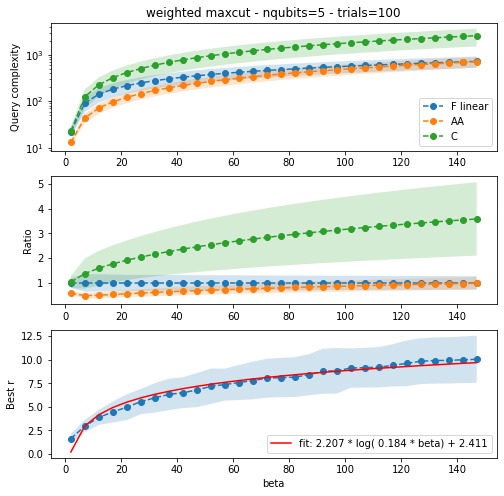

In [60]:
def plot_band(axs, x, cv, std, label=None):
    axs.plot(x, cv, 'o--',label=label)
    axs.fill_between(x, cv-std, cv+std, alpha=0.2)
    
fig, axs = plt.subplots(3, figsize=(8,8))
axs[0].set_title('weighted maxcut - nqubits=%d - trials=%d' % (nqubits, ntrials))
plot_band(axs[0], beta_range, np.mean(qref, axis=1), np.std(qref, axis=1), label='F linear')
plot_band(axs[0], beta_range, np.mean(qampl, axis=1), np.std(qampl, axis=1), label='AA')
plot_band(axs[0], beta_range, np.mean(qc, axis=1), np.std(qc, axis=1), label='C')
axs[0].set_yscale('log')
axs[0].legend();
axs[0].set_ylabel('Query complexity')

plot_band(axs[1], beta_range, np.mean(qref, axis=1)/np.mean(qref, axis=1), np.std(qref, axis=1)/np.mean(qref, axis=1))
plot_band(axs[1], beta_range, np.mean(qampl, axis=1)/np.mean(qref, axis=1), np.std(qampl, axis=1)/np.mean(qref, axis=1))
plot_band(axs[1], beta_range, np.mean(qc, axis=1)/np.mean(qref, axis=1), np.std(qc, axis=1)/np.mean(qref, axis=1))

axs[2].set_xlabel('beta')
axs[1].set_ylabel('Ratio');

axs[2].set_ylabel('Best r')    
plot_band(axs[2], beta_range, np.mean(bestr, axis=1), np.std(bestr, axis=1))

def func(x, a, b, c):
    return a * np.log(np.abs(b) * x) + c

popt, pcov = curve_fit(func, beta_range, np.mean(bestr, axis=1))
axs[2].plot(beta_range, func(beta_range, *popt), 'r-',
        label='fit: %5.3f * log( %5.3f * beta) + %5.3f' % tuple(popt))
axs[2].legend(loc='lower right')